### 1.2.1 : EDA: Advanced Feature Extraction.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [2]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing1_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing1_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing1_train.csv from drive or run the previous notebook")

In [3]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [4]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [5]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [6]:
if os.path.isfile('C:\\Users\\Khushmeet Singh\\Downloads\\nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("C:\\Users\\Khushmeet Singh\\Downloads\\train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train1.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [14]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('C:\\Users\\Khushmeet Singh\\Downloads\\train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('C:\\Users\\Khushmeet Singh\\Downloads\\train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [15]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'C:\\Users\\Khushmeet Singh\\Downloads\\train_p.txt')).read()
textn_w = open(path.join(d, 'C:\\Users\\Khushmeet Singh\\Downloads\\train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33194892


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


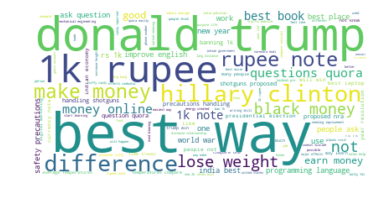

In [16]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


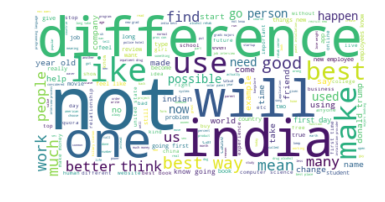

In [17]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilineadata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYEAAADKCAYAAABDsfw/AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzsvXeQ3dd15/m5v/x7+b1+73UOaKDRyAABgqQIZpFUDtZIluW4s+NQ9lg7660p727V7FZN7exsqK3dcrlcY894ncfyyJIsmTYpiUGJFBMAkgCJHBronF6Ov7h//Lpf9+uAQFIS1upvFcjXv3h/N5xz7znfc67wfZ8tbGELW9jCTyekn3QBtrCFLWxhCz85bCmBLWxhC1v4KcaWEtjCFrawhZ9ibCmBLWxhC1v4KcaWEtjCFrawhZ9ibCmBLWxhC1v4KcaWEtjCFrawhZ9ibCmBLWxhC1v4KcaWEtjCFrawhZ9iKD/pAiyhLWzZdfOAF/whFAQSQoQAH88rgFDwfRvwEKgIoSKEhhD6j73gW/jRw3U9CsUapWId1/OIRgzS6SiyLLXOL+YqyJJEKhVGCPGe3rewUMayHHp6ku9H8W8bvu/TcC0WrRJNz8LzfVRJJqXFiCohKk6dnFXC9T1iapikFkEW8obPmlgsYmoKhWoD1/PpiJokwiayJGE7LvOlCpWGhSJJdCaihHQV1/NZLNfQVZlKw6LasIiFdLLxCJIQ5Cp1cpUanucT0lXSsTCGquC4HrPFCtWGhapIZOMRwrpGtWlRrDaQJIlyvYEiy3QmgnM/KRTzVZpNm1RHFEXduO7+f4L31tm5c5RAG+rN7+P7DXy/jixlEVIIXT0ACMq1v0WWkjjeAsL3UJR+ZKkTWU6iqbt/0kXfwo8A18cX+cpXX2d2tggIDuzv42c/d29LCdRqTb785VeJxUx+4efvR5bf27j42t8dZ3wix//yb//Z+1D620fTs3lx4RRv5C8gCYl3ilfJ6Al+cehD9JppvjnzGler0/i+R1KL8Xjn3YxG+zdUfv/333+fTCxC3bbJV2r0dcT5hYcO05WI8sbVKf7xxFkatoPn+RwY7OJzxw7SsGz+7DvHMVQF1/OYKZTZN9DF548dpNKw+LPvHGe+VMXzPDoTUT59z162ZVO8cXWKr75yGtf18CF43v0HODU2zf/7/Ots7+qgVGtSa1o8sHsbn7lvH4q8YozwfA/bc5CF1JoVNr0mIdnEx2ehmUOXdAxZp2iXiKlRVKEiC4m620CTVBACQaBIhRBUnRo1p05KTwbnl/DDF85y+dw0X/j1R+jIRH+0DXqH445UArp2AN938fwSkoghACE0QELXDiHQUPw+hBRGllIINForhy38k4Lv+7zxxjXGx3N84efuo7s7garKGMbKgNY0hbvv3oauq7zHRcAdgbxV5q3CJe7p2MOD6QN86fpzNFyL/fFhnp15nYnaLJ/vf5SUFuPp6Vf47txJeswOYmp4w+eV6g3+u08+RKFa5z988xVOXpnk2K5Bnjl5jgOD3TxxcISZQpn//Wvf4eiOfrqSUepNm1y5xq8+cQ+diSi246KrCqeuzXBxaoHf/fTDZOIRSvUGiZBJ03H46iunOTTUw0cOjzKVK/H7T/+Q/YPdACyUa3z4rlGeOLiTN65O8lffO8mj+7aTia+UuebUuVC5QkQJjqX1FFcr19kb34kPvFl4hx6jiy4zwxv5t0nrKbrNTnzfp2AX0SQNUzYwZJ2aUyemRpmqzzBZn+HejsNtSmALK7gjlYCqbFv6tTa5ncDUP7DquNjkui38U4HjeORyVdLpCDtHuujoiKy7RtdV7rt3x4+1XLlmkbBiosu3b9LIW2UMScNUNjZf+vgsJ3YUQuDhI0sylmczVpuhz8zSH+pEl1T2xIb49sxrLDQLmyqBQ9t6yMTCdERCDGQSjM3l2dOf5YfnrzFfqvLG1SkApvNlLs0s0pWM4vk+B4e6Gcwk0ZQVc0lfR4xUxOTPv3uCh/YMc/eOPsKGxnS+xFSuxBc/eoxE2CQeMuhJxXhnfJbtnSn6UnH2D3YRD+mM9mSwXY9ird6mBBpek6n6DB4+cTVGWk9RcWtYnkNINlAllZQWR0JCW6r3kl1muj7HtnA/s80FPN+j00iTt4rosoYu60SUMCHZWFcv9ZrF80+9wdxMka7eJA8+sZfOniS5hTIvPXeG61fmUHWVQ/cMc+DuIXzf5+//5lX6hzK8fXIMSRI88pEDDI92cfncNJfOTiFJEpfOTdPZk+DxTxwikQr669m3xvnhd85iWw77Dg9y+L4dmGGNr/7FSwwOZzl14irNhsOhe4e5+/4RNP3HJ5rvKCWwOqNpsLTdbFq39vitTf8838f2nDaVIQmBJr0/1eD7Po7v4i19hywkZCGtW6Z7vodYKvPqc7eb0fVGtm/f9/GX3uWtEipr7xeBxwVJrC9P8BwP16+A7+PjIgkNz7fx/DquV8JQtyFt4ItZfp+Hj+f7bYJtbRkkRNv/ASzL4evfOMkbb13j6tV5bNvl3/67rxONGDz5xD4efmgXAF//xkl++MpFmg2bRx/Zzac/daT17PHxRZ574Qx9vUnGx3NcujxLR0eERx7ezaGDA8iyhG27nDg5xnPPvU2jabN3Tx+1mtV6hud7uH6wyhQIZCHh4fHSwmn2J7bTZ2aQJRnf93H9wAwiIVAkOfh76dsBFCHj4XM8d5b+UCfbI70oQl5X5yktxp74EE9Pv8xLC6cxZI3P9D6M63s4noOmqa32UkRgTrF9d+OOIECV5aW6Bk2Wadg2tuthaipPHByhOxUD4Gfu3ctAOtG6NWLqyFJ72ToTUX7jQ/fx2sVxnjl5jpcvXOOXHj681OZgqCtjyVAVGpYDgKkpGKoa9DkR1KXrtfcHSUhE1SgLzUUSaoy622CmPsu4lmI0uh1d0pisz7AtMkBINkhpSRzfIanFuVabQBYKXUaG8doUM415es0udEmjZJcp2CUyekfb+86dGifTHefQ0WFef+kC3/zaCb7waw/juR6arnDk2AhzUwWe/4c3icYMegfTPP/Um+w7PMSR+3dw+dw0X/7TH/DFf/NJ5qaL/N1fvczDH9rPoXuGee375/mHL7/GF37tEcYuzvLMV19n/5EhFFXhle+dx2o6PPjkPl589h3OdY5z7PG9lAo1/v5Lr9DTn2JwezYwZ9mT5Jtv43gNDDlJV/ihjdv5PeCOUQKe71OsNvB8n0TYQOLGQs5bErjqBoNoM4xVZ/n373yF2Ua+dWxXrI//48Cv4LoesiLhe1CtNjBDOqoq49guCJBlKbB1+sFvSVorLH3GqnP85dh3OVMcJyRrPJzdx8d77yalRdvKeKF8gbASJqklCckhpKWBnF+s0GzYaLqC7wcOT1WVqVQahMM6kiRhWQ6O4yJJgkw2vs6p5fs+lueQtypcqkxzunCNK5UZ5ptFao5F07NRhERI0UlqEbqMJIOhDLvj/eyJ92Osmdm6Xoly8wQgqFlnCGl7qNnnUOU0mtyFoQyu08G+71N1m8w3CryRv8ql8jQTtQUKdpWq08TxXTRJIaIYpPQo/WaakWg3e+OD9IU6UCQZWZa4777t7NzZxT8+/SaFQo1Pf/oIyUSIbCbWetdjj+5meDjDn/3FD5iZKbaVo96wOXlyjB/+8CIPHBvh8Q/u5cTJMf76Sy8TMjV27+7h8pVZ/tMff5e77hpkz+5eLl+Z5Y23rtHbmwLgdPEyryy+g+/7bAt381D2Lt7MX+Q7cyc4X7nOcLiHn+l7mIvlcV5efJuKU6PL6OCf9T/Kyfx5zpbGUIWM7bt8pvdhzpWv8fzsceJahG3hbj7X/xgy7W0oCPwCfWaWBzMHMGWDmBpClzUyRpL5RoGSXSOmhJhrFlCETFzZeBWAD9fm8zRth4btMF+qMJRNETN1elIxTE3l4GA3khA0HYeQplGqN5bKIVqTlWXYjks2HuHjd+9mb38nf/rCcc5NznFs1xARQ+Pi9ALxkEHdspnOl9g/2BU8a0n43wgJNcYHOg7j+R6KUBBC8ImeJ1ElBVlIHE0dxPU9NEklnjyAhARLKnbZl6BIMn2hbnzfQ5eDyUlaT6KK9aagnoEUDz25j8HhLJqu8K2vn6SYr5FMRzj8gR1YTYdI1OTNV6+wOF+mdzCNGdK4677t3PfwLg4e3ca/+9d/w8V3JgHIdMU5+uBOto92k0iF+cs/fIHpiRw/fOEshqkxsD2LpimMXZzh1PGrHDi6DVVTOHTPMA8+sRfP9Xnj5cuMX11gYDiLEGB7ZerOPJ5vYcgd677h/cAdowRsx+X45QkWylWeODhCRyTUft5zmKjl8HyPDj1K3bWYbRTYGe2h5jRJ6RGKVg1VVsg1Kwgga8TR5ZXGd3yPgl0lZ1Vax3L1CpMTecqlOv2DHTSbNs89c5qHHttNLB5iZqpAs2nTN9DB5EQO3/PJdMbIZGNtgr3p2fz5led5Ye50a+Z4tTpLhx7lw92HUVaxNwQSJ/InSahJekO9JNU4cTXB6y9folG3yXbGUTWZmakCqirTqFtkOuOkO2OcOn4VRZVxXZ/7Hx6luy/Veq7n+yw2S3x37jRPT53gSmUGx7+Rr2S29SuuhvmDu3+DbZHOtiuEUDHUQSQMFCmG61fRlT4UKYoixWANK8XxXK7X5nlm6gTfmn6DRat8g/cDZXiF8wA8kt3P7+7+GeJaGFmWGOjvoKszzmuvXQZg92g3qVS7OSgWMxno7yAWNTd8fLNpc+89w3zus/cQCun09ab4/T94lonJHLt39/C9758nk4nyL/75Q5imxkMPjnLlylxL9JXtGlk9yfZIL/2hTkxZ596OvZwqXuLR7BF2RvvxfZ+0nuD+9H5c3+Ovr32bz/Q9iu05SELwoe77SGmB4jqc3MXZ0jX2xrdxODm6rry+71NxGhStKlP1Bb428X0EgoQW4RcHn+Roahdfn3iRb828SkQJcaF0nSOpUbLGxkwmHzgzPstTx88wX6xSbljcs6OfdDTMEwdHeOH0ZQrVOoaqUGlYfPrevTdsrgtT85yZmCOsa+QqNQxNIROLYKoqH75rlKeOn2EqV2IqXyKka9wz0s+5ibkbPnMZkpDQRPskJKSstOvqc2vZUOqq1bwpt58z5Y37RrozTiweQlYkDFPD93wsy+HKuRleePotGnULq+lw7cocjhOs6jRdpSMTRVYkIjGTSNQkt1DBDGlE4yGiMRNZkYinwkhCUMxVWZgrce7UODOTecTS5HHn3l6EECiqTM9AB4oigwK6odKor6xEZWEgCxXPt3H8+i3V4+3ijlECAGFDY75c5cpMjsSwibKK5THTKPB67hKe57Mv0Y8kBOPVBfpDac6WJhkIpRmvLSCWjsuSzEi0m0PJoRu+03U95udKzEzlSXVEME0VRZGIxkyujc1Tr1nkFyv4vs+VS3MkU2EsyyGZDKNqK9WXsypM1nMtBQBgeQ5XK7PB7Fta6ZijsZ1sjwzzVuEUryy8QkyN0R/qQ2g+g10ZunoSQcc0VBbnAyHaP5TGMFW2jXQSjQUK0gyvmGF836dk1/iLse/wrek3qDqN26r7HjNFp5FYd1yWwphSYG/X1d4N7lxpI8/3uFCe4k+uPMfxxYubmyg2gCGpDIYzxNTQzS++Dei6Qk9PklAoqCtVk9E0BcsKyjY7W6SrK45pBgJGUSR6epLMzpUAOJwa5WJ5nCvVKS6Ur/PZ/scAVkxc+DS8Jify5ylYZRJahLrbbJmAUloMQ1oRXoIVm7+Pv26m7eFzrnyNuWaef73rCyTUCEW7wn+68hTny9d5IH2AT/Tez4n8eYpWmYeyBzmQ2NFaTa6FAO7dOUC53kQIweePHWC4K4WuKjx+YISoqXNhagHf9xnKplDkYGV9bNcQ/en4utl7ImzieT5XZnOEdJVPHt3D9m4ZX1g8dqCfhjfGRG6ORCjBxw7vImoKMgnBw3uHiZmBXT6sa3zk8CipyMbC+ccFWZZaQnkZvufzzFdfJ54K80u/+Ri1apP/+H890zrvOC71WrP1u9mwMZb6TrNhYVkOvu9jWw6e66MbKoah8sDje/jMLx9DXyI0BCujYHWkKJtTVH18LK+M41XQpD3vdxUAd5ASEAJ0VUFXFGaKZVzPa6OPyUKi5jQZDGfoNoNZz+XKLKokE1dDfG/uDNsjncw3SoQUnZQWadlNb/xegaJI5BYqlMt1kh1hEIJCvoqhq+QXKzTqNrIiYzVtKuUG0ai5zgQlWv9phyykdQP9anWMi+WLGLLJoeRBVKHwZuEUB/ccYbRnEGnpu9PZGHMzRRzbpbM7UAzpNSuQ1fj+3Ns8M3WCumutOycLCVPW0GUVx3OpuxaW57TOH0wMtSmqTWrrhmcXmmW+MfEqx3MbKwBVkgnLBrIk0XRtGq7VWqnE1BCjsd73zPFfC0WRNxxkPpv7X5ZdFz4+VyqTXCpPYPkODTcY/EJAVk/w0sIpZuqLHE3tpuY2KNpVQopBdI1ppq39BaS1OCfy58nbZR7LHlkjwANz3gpV0meukafq1EmoEYQQbI/0sj2ykUJeDyGgOxnjY0d2tY5dKs+jNiXmmxUyfSb9g9toeg5R1eBiZRbbcxGdDuG4gk97q/enE3zhwUOtv223zHjlacpulLA6yNE9BVQpSljtIKbq5JonSCeTDKS7KNvvMFnJE9O288l7M+SbLzFTNYjreyha5xDIJPW9aHIcAM93KDbP0XAXUKUIMW2EonUe33cwlW5cf7k9ZKLqMNImsRK3i1rNomcwjRCCc6cnGLs0x7HHgxVSpdTg9PExto10ce3KHPVak8EdGa5fnmfy2iIXz0wSS4R489UrxJIhunqT7Dk0wPe+dZrrV+YZ3J4lN19GMxTSq8yam8HxqsS1ESSh0vQKG04c3ivuGCUAgkq9yUyhxBMHRlrOrGWYksaV8iyGrFKyM0zWcpwtTtAfSpPUwpTsGoaicTA0xAuzp5EQ9IfTN32rrEj0D6ZJpsKkOiKoqsz9D40SCmmYpkY0ZmJZDrqhYoZ09h8aaC0hVyOlRekz05wvTbZWAxHFYDTWiy63V3PFqdAf6qfTyBJXA7ZD1anRE023FAAECqqze/3sfCPU3CZPTb6+TgF0aFE+0nOEvfEBYqqJLGQ838PxXSp2g4n6ImPVWY5ldrecjGux4tDd3K7r+R4XSpP8YP4MtreiAGQhsTPaw6OdB9ge6cKUNSQh4foutueSt6qMVWdpuja7Y/239K3ry3WDYzfiFwCdnXGuXp2nXrcwDBXX9ZiayrdiELqMDjRJDUwyamS5Fngke5hFq4gpB7z1Y+kDFKwyipDZG9uGhGBPbCjwf6wySQoEH0jvZ6FZQJWUdQNaQmI02s+Z4hX+n/NfBnwMWefu1G52RPta/PcbkQhupkjnG2XqjsVco4wkBJ7vIwuJ+7PbmbIKjFUW0WQF/JtTLiRJB1x0OY0mxRBCxpCzVKyr6HIKWeg0nHkkFOrODGG1n9naS0S1YRyvhissLDdHofkOXaGHkcUKi8f3HUr2JUy5k7ozS8W+hufbSEJloXESTYojhAQIIko/CPm2yRXBe5buESAkwSMf3s/TXznO2yfH6BtM092XbPkANV0hn6vw+//r31OrNANGUXeS65fnicZN3nrtKt995jSqpvCpn7+PcNTgyLEd5BbLfPlPvh/4GWImT376rqX4BNFehjVoujkUKUJY6WWq9sJtf9ut4I5RApIQDGWT5Kt1kuHQOmFzPHeZzw1+gKZrM1nLcTg1zL7EAIasoQiJXxl+BF1SkSWJzw3cjwDMW6DvyZJEIhkingwtxSMIunsCwSuEINMZaOtm02bfwX56+1Otc6uhSQr/YvvjGLLKmeI4MS3Eh7oOcU/HziUH1goGQgMsNheZa8wz25gno6c5kNiPhIznBgpkeQYmJHFLs+O38mNM1BfbjqW1GP/z/s+zJz6ALimtGafnrzB1bM/B9l30JUHned4qAm5gvHA9H8/zUVV501lIzbV4PXeRol1dqVsh8VBmL7+186OktWgg9NawoTwCxpbre5jy7UV827bL3FyJqekChWINWZY4e26aSFi/5Wjfxx7Zw/95/B/5D3/0Anv39HLt+iK5XIVMJoZAkNYTpPX1irhDj9Ohx1t/Z/QEmTXXJbSNg5CSWpTkJueEEHQZKX5l20dZrJQpVRuYmobiKUxOlYiFTbKpCKcuTtGbjeN5/lIrCSQJFFkmsco/8m8++0EMtd0pejg1gOO74Af9zMdHQmAqKmk9zIFkH7KQbok1JwsNVYqhiiiS0FFEmKi2nbo7g+c3kYSK41Vw/QaqHCWqbWe+/hqy0Cla5+kKPUJI6SFr3sdi4ySKFCIiDcJSuQSCiDqE41epNq9jyGlMuRNVilKzJ/CXhehSr7U8m7pbQwhB021iyiaO7wQubiGhCBnHd9j5SJqB+6Po8WC11bkrwi/9Dw+hRFy2d6T51d0fJEQYw1Tx/UD4W02HUFjnsY8epHcojQAiMRNVCyas2e4En/6FDxBLhFA1mWgssBh42iWOfUxmzwNhJD9K1T1NOhFiqvoqv/o/9WKGLzNeeoGotp/f/B8/jK4bLfmX0vcxU3uRxcYbZM173uc1QIA7RgkIAY7rYTkOtrvelHAgMchbhTEiisH+xAAhRSfEitCISisdP6beuq3Rw2e+VqViW/REouhyu6Ba/m0YGn1DKUpODVUoqFIgEIOuF/y31+zgvxn9BP4Sg6HmNlAlGR8fx3NbzqsX51+iYBeIKJGAeSQk0noHpcUys9cX0E0Nq2Hj2C59I12E46GbKoIzxes0Xbvt2Cf67mFvfGAd42ditoBlBVGinu9j6CohwyEeMZmaL2I7LqauYegKC4Uqruvhuh6j27IY2sYBNw3H4mxxou1YTAnxc4MP0mOmNrxHCAGeD45Al4NZeN0OBqwkCRRFxvN9+vpSIAscLyiH5wdD/+q1Bb70X16hWmmgawqVSoM//4sfYJoav/OvPkQ4pLFrtIf0qtgC09TYubOLZCpM03FIdEb49V9/lG8+e5rvv3SBoR0ZPvPZo8xMF2k6Dk3bQVMU9KWyuL6PBJSbFroioykKTdvB8TwiuoYsvfd0XJKQiCgml+dyXJ0s4nkehq6STUVQl0xbpWqDsTdyWI6Lpsq4nkej6ZCMmXzk2IrtOBlZ72PRZQV9k6Gvy1IbmeJWsGymieJgKllkoWPKWTzfoWxdw/VruH4DXepAQsFUurC8AqoUo+5OoTkx6s4smhRDWsPi0eUOZMlAlzvIhjqp2Fdx/Tqm0oksTCSh4Pg1xJIpaKYxQ92tM9ecI2fl6DF7UIWKIRvU3cCxmtJS5MQiZsjAEy5Nr8mp2ilkIVMqlJCERFyN80D6/jYHtNV0EEJghDTS2fWmHEkSRGIGma5423FZhNCMBl3GEKY6QNWK4GPTdB1S2WEa9iSG2EdIHUQzo20Trbo7h+PXkIVG1Z4kZRy4rba5FdwxSsBxPQrVOpIkMZUvkY1H2hzDnWaCJ81DN3jCu4Pn+1wu5HhnYY4PD4/QG9ncTuf7MNvIU3HqmLKO67lLncQnoUXpNJJM1uZxfRdFyIzX5knpMWQh4foee2ODyJKM7Vk80fk4GT3dJtyvvj3Om987Q7Y/TaPaxGpYJNIxwvGbO0tnGoVgdrcEVSjsivZuGCV55vIMruuRL9dxHBdDVzgw0oMiS5y6MIXjeowOZZmat3jz3ATpZJieTHzdc1bD9h1mG4W2YzHVZCTac+P7bJcrE4s4rossSRSrDTriITwPQqZGo2nz0Y8c5PW3rzM2k2dqoYztOCRjIVwZPvOz97B7uLMlHFcjHg/xG7/2aNuxrs44v/wrD3BpfpHZcoWrC3m6+6N8/r++n6btcC1XIB4O0bcny/VcgUrTIhsN0xWLcmUhFzCwqjVmimW64lF64jHOzcwjBNzV30Mm8t5zFy2jOx0jbOrUGxY+0BEPtcxUvZk4qVgIZclsWqk1adoOsfD6oKgfNeL6KDFtB7ASE5MN3Q9AQl+fyqUn/BjT1e+QNe+j4c6jSjF6wo/D0mwdwPUsqs4UYXUbupxEl4OVXVLfB/it69aVRY2R1JJE1SiD3gCu7yGEoENLUXYqFKwCuqST1jrQZA1ZyKhCZSQSONc936Xm1gOK6pp5t6YpfODRXa0AsNXo6kty6N7tmKH1q9mwth2fbSyTblXzHmCZJAAhdVvr2rXvrDvzRNVtxPURJPGjybV0xyiB5XEjgKlcif0DXW2O4R8VfN/HUFRkIWg4zo1jE/CpOQ2uVWYRIggciigGNafJaExBEHTU6UaevFUOnJ+eTcNtElcjLTOLIql8f+EHZPUMAonB8AADoX6SnXEOPLCbufEFsgMd9O3oJtV1Y+G7jKrTaAWpAURUg4hqbOgc3z8SCGbbcbFsB9f16O9KYi/HH8Qi9HclyJfq3H9oG7qmEDK0lsDZsG58n6rbzkhKaJGbmhSatsPliQVcz8PUNQrlGoauMjVXBHxkSWJ0KEvDshmfyaPIMqahUqo2CZsanufhebdnB16o1njt2gSH+rpZrNQoNZoYisx8ZcWUNZbLk42EURWZmKHjej4T+RLpSIhL8zkkIFetM1+pcXFugaRp0J+Mk46E37clezYVJZuKbmgvHu5r93etjjD+SUDchlNWFgYdxl3U3Xni2i4MJbvufg+bfOMMIbWbyCpW2o2DSCGhBSa56JL/ZnnQCSGIqlF6zO6WoF02IQkEQ+HBdcfWwghp/Mwv3r/he7ePdrN9tHvTcolVJuHVz75Za+lygpJ1BcsrostJMubRm9xx+7hjlAAAQhA1dEZ7M+scwz9KdIUjHOnqJa7feBYlC0F/KEtGTyAIuMlVp8GZ0rUgUhiPXjNNWDFxfBdJCFQRVLEuBYmuAHZEtjPVmEYWCoIgwhSgf7SH7uFO8jOd6GGdaCJ8yz6Bhme3MV60VT6AtejNBoplreCwHZejewcwdZVoyCAWXjar3VzAePg0V7GNgFsyKxiayl27+tBUGVmSqDdtQqZGNhnB9330JRrunuEuBntSaKqCpsg4roeiBAF8inJ7k4VkyOCxnQFlMRMJB31NgO26yEJCV2QajoMiBcwunwtjAAAgAElEQVSukKaiSBIH+7owNZVMNGD/KJJEzXbY150NMpiGzB+JzfZW2v8nJfzfDYSQCam9hDakHC/DRwgFyy2+K0ZM63qxwbFN/t7s2E8SklCJa9uRhE7BOv8jeccdowQEgqbtUKjViYWMdRG5a+Hj43oeTc/G9twlRo7fCu1XJQVNUpCl9RTNtbBch4RhkLipEpDp0ANz0bIATWpR0kYcVShISBiyRpesBUyDNZ7/5YE6EBogradxfTdwfC1RCoUQqJpCduDmrKZWPSzxzb11s8X10Z5rsVZwqIpMV3ojc9hN2sL38ZZSJKyGdAsDStcU+jpXHKqteo2GlsoYHO9IhEn5m5vFllN2WJ6Ds9Qf/CX3urS0atOW+kRY1wnrOgLoCIfWlXs1+2Z1HaXCwfsNRVm+kA6WlvWbzMSXy9V0bexVKUVgJa2IKsmoktKWNgPg6pkJGtUmtXIDz/MpzBUZ3tfP4O7eDdMfLzvam66N4wd1sPy+lXEhB+Nig3Qmy1is15goF+kKRzmfn+fe7v51DLebwfW9FtXVWdU3hBDIiJXxuUk5BMp7EsfLdbG6P3j+atJDQEaRlpzFqiRvmMLjvbz7vbaD57soUojF+pvU3TmyS2ak9xt3jBJYFmQLpRpN28H3VwTAWjRdm9lGgXeK13k9d5HzpUlyVhnbC9IRdBlJdsf6OJzazmisj04jvjTI2JAGWbEtzucWOdrVS190cx6+5TlM13MUrOqG54PvWBGZAsFQJLsuAOp4/gRvF99mpjFDTI3xQPoY93Xcu2m9+L7f4vW3/rkOlheYm8p2nfyayFzbc7hYnsLbJGJ4dTl7zA469OimcRXLju2Gay+9324rS921uFKZWXdfyanzVmHspoNZFhIj0R50Wb3hINzo3HKE7XhtnnOlSU4XrjFWnWO+WaThWkE+GsWky0ywJ9bP3R07GAxl6dBjqJK86XNvVo7FZpnpeh53yQ+T0qP0mCnkVYq/6jaZqC3wduE6J3KXuFqdpWBVg3QnkkxSjdAXSrMj2s2uWB87Il10GsmWc1nTVWKpCFNX5pifyJHt78CMGvieB2tSTViuw2yzwMXyFCdyl7lcnmauWaTi1PF8n7BikNXjbIt0cjAxxK54P71mB8YGq7XFRo2XZ8YxZYWQqq5T5pfL01SWghFlIdEfShPXgomM47ksNEtcqkzzZv4q7xSvM13PUXWCYLWwrNOhRxmN9bEvPsBorJceMxWw01bVueNX0eUktle7rdn58liZaxQYq85xqjDGWHWOmUaBolWl6dkIBLqkElEN0nqMXjPFzmgvQ5EsaT1GSosSVjY2pd4Mlmsz2yhyoTzFyfxyOxSoLJlr29ohuY3dsT56zY4NV811Z5ZS8xKO38D3HVz/9gJAbxXi3fBq32/4vu9XGhbX5wtcmJ7n2K4hMrHIOiUQpIyt8oO5Mzw9fZxzxYkbRqXqksr+xCAf7TnCA5k9zDWK/Nu3/4aL5anWNcPhbv7V8Oeo2jY7kx10hSObCoDZeoE/uPg0z8++dUvfpQiZ/+3QL3N/elfb8b8d/yr3pO7mdPEdhsKDNL0mR5KHN6sb5pslvjb+Q4p2jZJdo2BXKVjBv4rTaHMIvxv8t6Of5FN9925qv/d8jzfyV3h54TzFVe8u2jWKS/mAbhR8dTPE1BD/8ei/vKW4jrXlulyZ4fmZUzw3+ybT9fxN7wnJOkdS23m86yBHUyPE1JszrzbC30++xh9d/CaFJUrsx3ru5rd3foyYGsLzPSbrOZ6deZNvT7/JZG0B7yb1owiZnxt8kF/a9igRpX1FeiN7v+f7zDeKvLJ4nmdn3uR04dot9Yed0R4+2nM3x9K76TaTbc+2XZeKbSELgSJJmEq7gP7i8T/ijfyVwKkp6/zuns/weOdBmp7Nq4sXeHrqBCdzl6ktBdfd6Jt3RLt5susunuw+REJdcao33ByOV8Xx6sT1kVtSBE3X5mplllcWz/OD+TNcLE+1RfDfDIasMRzu5BO99/Bk96F1rLobwfN95hoFXl28wLdn3uTtW2gHAeyM9fLR7ru5P71rXTtYbomGu9D6WxY64fUmtPe8dLljVgKW4yBJ0JWMoqvKhgqgaFf567Hv8c3pN8jdLCcNQT6f47lLXKvOs9Asc2/HTiJr0vcGSackJBEs838cttWIEkYSMlW3xqXKZbJ65obXzzeL/OXYd3/k5doMnu9zMneFL137/k+sDGtheQ7HFy/yt9df4mT+8k1yJK2g5jb5wfwZLpSneKJrms8PPkBS3Vzx3yrKTp2q0ySqmIzXFvjjy8/yw4VzNDaI3t4Inu+RNeIbKuLNyub6HlcqM3zl+kv8YP4MRbt2y+W9UJ5i8vK3OFsa53P9xxiN9bbFkVwt5cg36oQUjaNdfSiblKHmNplrFKm7Fs/NvsV/HvsuE7XFDa9dC8d3OVeaYKK2wKJV4le2PUZ4SQE6Xo2aM4sqNkmMtwo+PnWnyfOzp3h66gTnShNt0fC3ioZrcbY0wUPZvdyObHV9j8uVab5y/Yf8YP4MpVtsBx84X5pksrYYtMPAMXZGe1rtoMkxNPnmUcXvFXeMEoiHghzkjuejbsAKcn2Pv5t4hW9MvEp1gxmGhCCs6GiyStVu0vBWBt98s8iXr79I1Wm0Otkylpfek+USw/EUSWPzGAMhRMvhupmZ5VZwOHmYqBJhX2wvi9Yi28Lbbn7TFlqwPZeXF87xp1ee50plZt1sTyCCOBJZo+k5VJ3GumtmGwW+Nv4yjufyGzs+1BbV+25QtRvU3CYlp8afXHmO7829fVuz0LQRYzCcRb1Flo3v+0zUFvjDi89wMn9lQ6GnSyoRxcAnMJmtvabqNPnO7GmKVpXfHPkI2yPdCCGwPJd8o0FUM+gO3zz9ykRtge/NvbOhApCXzHGKJFNzGtRda92aqOI0eGriNTr1BJ/p/0DgG5MilKyrmHKaJDfeMdB2Xf5u/BW+Mv5D5prFG157M3SbSfYuBVfeCnzfZ7w2zx9e/CZv3KQdPHyqG7RDxWnwwuwpClaV3xr5CMORrh+ro/+OUAJBIiUf2/EI0kdYREN6q/P5vs/x3KV1CkAAaT3GR7qPcCS1g5QeQRIStucwXc/z8sI5Xl28wHyjyGKzxNfGX15XuRKChG4EtmW72QrL3wgpLcKv7XiSzw0co+Y0Kdk1ik6Nsl2n4tR5cf4sVyuzNzWNdGgp5przSEKwI7KdjH5jM0hSi/AzffexMjtZ/fyAbfzS/Nm2ARCSdY52jJDSohtcv/yM4Pf2SDcymzNsJCHYE++/YRmqTp1vz7zZdl+nkVgyhYl116/Ax5R1Iuqt8dtd3+PN/BX+5PKzXKnMtswsspDoNTt4ILOHI6ntZPRYK89/2alzvjTJM1MnuFyZaS3Ta26TZ6ZP0B9O84nee1rsrXeDslMn3yzzzNQJXpw7u5TyOPBP7UsMsi8+QEaPYco6Tc9mvlnkYjmwm0/Xc+yO9dFlJG558BftGn948Zu8nru0ar+DIBvs/ZndfCA9GtiaJRXwqbs2Y9VZvj/3Dm/kr1B2gsApy3M4nrvEX419ly/u/AQpLYIiSchCcC43z3i5yCeHo0g3YOu9vniRVxcvMNcoIgBd1tgXH+CBzB72xgcwZQ0hBI7nMl3P8dzsW7w4f7ZtlVRy6vzj1HH2xPvZFetDFhoxdYiGm6Pdg9UO13N5auo1vnT9B+RXZQeGwNyU0iKtNOlZNU5UNlGERE3YzDUKXKvOcbp4jalaDtt3OZLazmA4g+v75KpVZEkipusBU2yDtinYVf7w4jc5vqYdElqYD6Q3ageLseoc35t7mzfzV9e0w0X+aszkizs/TlKLLBEUApnoE/RZSbz/IvuOUAIAluNy6to0E4slNEXiyYM70Zc2qMhZFb58/UUWmysmIAHsjPbyxZ0fZ29iAEXIbUpjONLFPR0jnCtN8GdXXuBk/nKrwlfDx8dyXRRJCvKl3ACKJNNpJMgupQtY3qxleduQxWaZa9U53Jv4WV7Lvc6lyhXCSoiaU+NI6jB7YpvPdrqMJF/c+fEbPvN6baFNCURVk8/238/e+MAN71v+rhsxeQSCezt2cndq8927JmqLPDvzVpsCHAxn+e2dH7+lhfWtpCjwfZ/pep6/GvsulyszrTeZssbjXYf4wuCDdBtJlKVobrGqP+yO9fNwdi9/cTXIsrpsry7aNf72+ksMhrMcSm571xTBglXlG5OvcbowhuXZDIWzfKT7CI91HiClR1b1z0Aher7Pk10eDdfiQmUKGYmMfmsxIbbn8LfjL/Hq4oW2DW9Got381shH2Z8YXMc28n2fkWg3D2f38oP5M/zx5WeZqueAIMX6C7OnGY318bMDD6BJMns6svREYgGz6iZMvZlGfklMC/pCaT438ACPdu4PVgCr2C++77Mt0smh5DCHEtv4s6svsNAstZ5zrTbPi/Nn2RHtpmJfw8W6YfyB5/scz1/mv1x7cZ0CSGlRnug6yKf67iVrJFCExNSlWXLTBTRN4vC9u5c2PApYTGPVWU7mrrAn3k9Ki3K9WOCpi+cJqSqHu3o42Nm1cTtcf4nXFi+2tcPOWA+/NfJR9sUHNmmHHh5qtcO3W74sx/d4fvYUu2J9fG7gGAJB1ZlEESYl6xJCKKSNI+9/ksX39WnvAaosYWoqpqaQjUdaHc/3fb479zbnShNtzrXeUAe/MfJhDiSH1s3glmlosqxxKDnMvxwx+PdnvsKF8uS69/o+WK5Lw3VwvVtbvi83ghzwQFsIMobeHLONOT7S/SRpLc3p4tsUrELrW13Pp2kFZYmYOkIEM/Gbce7Xvzmg4d1uCoCNIIRAETIKmw/IjYS4hEDfIF+Q67RTBl3XwxZLgXpC4Lke1XKDREcYaVUaBtf3+P7cOxzPXVr1lYKHsvv47ZGPEtkkXYgQAlXIZI0E/9XwB7F9l29OnWytCAIF9iY7oz3rzIW3ivlmke/MnsbHZ0ekm9/a+VGOpkbaTCkrJAwJRQIFGV1WOZoaua13nS1N8Oz0mzS9lTQhw5EufmfXp9gXH9gwPqTVhpLMh7oP0/Qcfu/8U63ZuOt7/MPk63yw8wCGMHh1epzXZyeRhOC/P/oQ5g1iMZa/KqVF+OfDH+TxzkMbps9YHpdR1eSJrrvIWRX+89j3Wt/RcC3OlyeZbxSJqVEUEcb2ymy2ClholvjGxKtMLymzZfSaKX5p26N8qPtwW78Mh03mm4t0DAZxHUFvDtpgf2KI/Ymh1rWSkOiMRMjX65uaw84Ux3l2pr0dtke6+J3RT7E33n/zdui6i6Zr83vnn2o9w/U9npp6nQ92HSStxyhZl7Hd4tJufjZp4y7WMsPeK+4YJeD5PnXLxvV8dnanW9GpJbvGqcIYJXtlFq8Kmcc7D7EvPnBLS/iRWA8f772b3zs/vc5O6+OjyTJJw0T7MQWo6bLOidwbxLUY47UJZCFzPHeC0cgoM3MN6g2Lcr3JnqFOEj/hnOvvN2zL5eyb15FkgSQHs0QzpFHMVVFUGUmWiCVCzE0V2J/YxmpZUrCqfGv6ZNvzskaczw88sKkCWIsOLcoHOw9wunCNa9VgsxPHd3mncJ0L5SnuSg6/q+9aziEVUQx+fvBh7ooO02jYARddCjJ12rZLtWYRjejomoIsSzSawTWIYELSbDqYptqKgpYkget4GEbA0Gm4Ft+ZPcX8qlVfRDH4RO9RdkZ7Nw0QXIsHM3t4YeYUr+cuto7NNgq8OH+WJzsPs7sjiyYrLDZqtxTvISE4ltnDo50Hbil/UkQ1ONoxwkvzZzm/anK20Cwy28gTUSRcv4Hjb+xk9X2fk/nLvFO83jY5TKhhPjtwjMc7D7YpAN/zKecrzF5fwIwYpHuTKEuWhrxVYKx6DUM26A/1EVHCdEUiDMUTZMwwPdHoutl3w7V4YfZU20omohh8sveeNufuzfBgZg/Pz7zFifzl1rHZetAOn+67l7DSS8GrkDEPU3dmeB/IQOtwxyiB5f1Gi7U6TWeFWnWlMsvYGjt7XyjNXclhQreRdfK+jlH+Wv8eM2vy2wTLXYmNttL7UaE/1MdkbYqqUyOqRNEkjYpTxXZdLo7PU29a6KpCqdogHnnvUai+75Nv1Lmcy7MtmSQden83brkduK7H3FQBWZWolhuoqsLeI4MszJWoV5s0GzY79vRQzFeDjKqrgqLeKowxuSZT6oOZPQyEbp1aKoRgZ7SH3bG+lhKAwLl5sTzFwcTQLQ/gjXBPxwh3xYZ5650JmpZDKhEiGjE4f2kW01CXjoXZNpjGMFROvnU9yHskIN0RZTFXxvODfhkyVSRJwvN8do10IcuC69UFzhTb2S87o70cTm7fkPO/GSKKwSOd+9qUQNO1eW3xIp/svYeBaJy4ZlCxrVuK3jdkjY/13H1b+3X3h9IMhDNtSqBo1chbVQx5G3P11zfdI6Bo1zhdGFtjIhYc7djBI9l9mGtYgMEgEji2w/TVOSLJMIO7A7rl2dJ5klqCol1EqSvsiAyzUKtyvVgkbhhULIt0qJ2ldK06z9k1LKRdsT7uSg3f8uo7SGVh8nDnvjYl0HAtXlu8wCd6j2IoGYR1AcerrUqd/f7ijlECkhBkYmFcz0dfGvi+73O9Ns9Mo53/PRzpYiicvS3bWFwLsy8xyMzMWiUg0RuJEdd0opreihb1gZlCGV1RSEXMJVOR4Np8nmrTYntXB+aqDb9vBzElxoyYoe4Gs5xBc4Bt4SE0oXHv3gEcx0NVZEKG+r6pJc+H2WqFbDiM53u8cPUqmVCITDjMZKlEvlHnYFc3vu/z+uQkMV3n8eHtxI33npBsdSyKpivc88goCHCsIFdRNB4ilgjhOC6u42GGNGzLRV2lAHzf55XF822DThEy93aM3n7WSzXMQDiDIWstc0jDsxmvLlBxGu96dzNdUnm86xCm0JlfKOO6Ht3ZGDOzJSan8qSSYXRdIVeoks1EMXSFRtMml69SrTVJJcI0Gg6FYg2EYOf2LIaucv7SDCPbs0iS4EJ5konaCndcQjAa66UvdHv7zypCZlu4k4QabsU6ePjMNPJcKM6g+Dqd4QjzpWoru+6NMBrrZeA24zxiaoi0HkVCtGbzDc+i7tlIQkOVolhufsO0EdP1HOdLk22Tww49yr0do6Q38K0IIegayjB2ZgK76dCorhBMbM8iJJuU7BI5K0fBTlFzPEKqyp50hpjerlB8329RO5chCYnRpcCv28Gm7VDPM9sooHIZ16vTcBZw/Coxbcf7rgjuGCUAMLFYYjJXZHdvwJu3PIeZRr4VnQiB7XkwnCGlb5yPfTNoksLuWD/PzbQHegmC+IBWKgCCZfn4YoEX3r7M4eFemo7DS+fGCOsaqiIzuVjkrWvTHBzs5sDg5kmjNsObhbeIa3EyegZEwBZa3gc11UqX8P6tSoRYSZ0A8OL1a9zT28dMpczzV6+wqyPNvb39PH3xAnsyGaK6RkTT3pcyND2HxWYFSQQrLQmBq3vIkoQRVokqBmW7QVW3kQ2B4/tYfoNMJNq29V/RrnFpTfDPQDhDp5m47RWcJATdRpKoYrYxVMZrC+SaZWJqkEpi2SSz7LfwfR9N23zIDIWz9IfSKJJEJKyTSITo7UnS35ti7+6eltkHgh3PZEnw4H0jrZTexVKdWNTgyKHBwI+hBvHH2UwMVZFpuBZXK7NtezYktQjbIp23NQNf/qaoatJtJlvCB4I9lV+Zv0y9pmEqKposcyhz8z5+KLENXVLb0jLcDLKQCCkGiiS3lLvlOku7zs0HlGx5vUD3/UBZXavOtx0fDGU4lBzedGJWK9cxQhqqprD94AphIqbGeLt4JjBNyiYTtUnicg+5ep3vXrvKgWwX+7Ire2/XXYur1TXtoIbZFs6+q3aIqSG61rRDya4xVpljJCLh4VB3Z5cmU/+EzUEAiixhqCuOxJJdW5eeOKIYdBqJdQ19s86nLIW33wokSTCYSTKUTeK6Hq9cvM59IwMUaw2+9dYFDg31cGiom6+/fuZdKYGoGqVgFVqxBgk1Qd6qULJrRBWTgl1FkxQSaoSwor9nYex6HoVGnblqhc5IGElI5Oo1KpaFIgIKXNIwUJaE7onpKT65c1ebYny3mG+UeWHmLKasMhrv5mo5GNwhWWNbJE0sZnIidw1NUpio5fCWqJX3Z3fQZawIgOu1+bbJAEC3kSQsv7v6CSvGutltya5RX9qTodl0mBhfRJYlQiGdSqWB7/ns2LmeJbKMwXCWqBLCNDQeun9n27nNYk9XK5WQqdHduV7omUtxM3m7yvQSE2cZUdUkq8ffVR2okrLOl2J5DilT55GBA4RU7Zb9ZEORThRJxvM86q6NJsk3ZdtBMBNe7ddbzvEjCx0f0OT1G/oEFPBCW0SyJCS6zCSdxuYMKz2kk+pKEkmEkFelHpeFjLK0qdL2yDb6zT483+czu6KULWudrMlbFabr7e0QU0NkjHfXDpqkrIsStzyHol0loe+i5kzi+Q7Z0NEfSfzAHaUEXM/DctzWHq9116JotTuGQrJOUlsfRWh7LhW7SVjRNly6CgRRxUSTlNuOJsxEw1ycDtIdx0MG+Wqdt6/PEg+9O1NJxa5gyiZRJbKUx0RbsjGOk9QiXK/O02Om2BPvZ1DOtG1s8W7g+T6265E0gwF/d08v78zNEdN1HhocImboGKrCcDJFyWpyuKuH68UiIx0d62yht4tgw5wovaEEw5EMmiTjeB6GHMw0AQbCKWzPJaSoSEhEVJ3wGpvuXKO4btOc+WaJpyZfX3ftrWC8tkDFblcqDdfCXuoblUqDE8evEg7rqKpMV1fipokxEloYXVYoWDUulxbYGc+iSgrK0n4SkhDM1ks0XJv+cArPD0gJjuchC4Hje9Qci4QWwvIcmq5DWPn/2HvPIDnS/Mzvlz6zvK/2FkDD2wFmMN7s7qzj8sjlLnlLc+QyjoqjTjrdF4U+6BQ8ncgIhXQRokjeKe7EJXnk8WjWcpe7O+tmdvwOZgYYeNeN9ra6y5usdPqQ1YVudDfQjcFQQ0pPBCIalVlp6s18/+/7f5//86ht7+eKVd9QKV+1G7zakkjYKUpWjcXG+uIq23UoWXVqtoUmy2yHieI7sPlpHctzmKoWaDg2I9E0Afn+NPBlMYDrmpjexnfVdO11C+MAuqjQE0jdfT3H8zj74iUOnN5N1/Dtkf2SmeNE/ChTtWmWzGVSapJc1WQ0n2e5XqczFCIV6G/vX7brGyipFbvBK4uXuV7ayEC8F4pWbcP92J5DzTGpWlM0nRIRdYhKc4qg3PMPOx3kuB7luondomparr2OfgV+1AxIGztfz/OYKOdpOg5HU10bAoFfhSgRkLRtB4HVafrRgS5uzi+jyRK7OlNUGk2als3uzp3lQFcRU2OUrBLFZhEQSKpJ+oNpYkoAy3MYDGYIKwHC8kZD+/uBIkmMpFKMpPzr9YDusJ9OW3v8U909vDY1SUBWabaMzt8v4mqA0+lh4qqv0bM3snHmNBRaL5ux2T0XrWq7g17F9fLMprTf+4Xp2m3aqCSKdHbG6O1NYjsuyWSIZvPuz40hqUiCyGK9zOuLY3QGoiw1luk0IszWi/QEYlwrLlKy6mSMCBdWZtkf62CmViChBbhSWCCsaoxEOrheWmSxXmIkmmUonEQUROpOc0PgWjJLfHnq9Qf2GzieS9U2ubS8gCrJdARD7Iol7/osqKK8zjp0oV5mplqkNxjDuIco4NYQcGkSkLo3pPssz9kgzaCIEsl7pIhlRSaSCFGvmuuuKSQHuVa+Tt1pIADj1QkM0sR1g4CiELtDRaDuNKncUXO0ZBb58tRr93Gfm8P2XBqORcPJIQoKTaeI6RTIcvqBnWMVH5ogIIkC3YkIS6Uqnufn5VcleNftt4X3qYfHTLXIjUKOvbE0qrRRilYUWgVh1oavr0O9aXFufJaVSo2hbIKQrnF0wO+81hZ93C8ORQ8wUZ1kxcrTqXeQ1lOE5BCx1gxHQKDUNFmqVcEQsV2XUrNBw/FleXtDUSLqzmchd16z63q0qPkARDSNR3p6qTabhFR/XWCr+/S/K9xT8luXFIw1o8GdKnauou40cbh/qY7twPXc9gJlOKxz/KFBgsHtzzL8gjCRsKKT1sMktSBXCvNEFJ35eomuQJSQoqFJMgFJYaaWZzCcZLFRQW3lxXsCWaq2ydnlKSRBoMOI+JaWgt/53TkoetDw8H0SOoNh8o06lWbzbgW7gO8bsRokxJZMsut5vB9RQQGRplNGFgobtrmeS/0OTSZREDHEe8w6BL+fqJXWd+AJNcGV0lVcPAaD/XQZXQTlIP0RCctxNoj/+YPTnWsT7QSr8uxRdT9Np4zp5EnqR/5hs4Ns10MUBE7t6iEW1AAP23M3qISKoogkrp+iep6H58FwJEm5aW6pQe1red97eqspMkf6uzjc14murorZrT/m+xmhT1QnuVa+TkAOcKF4EUVU2BUKrRvxlJsN5qpl3lqYomHbnO7so2H7D5/pOHeVt9gKtXqTcsVEVSRs26FS8XOqhqFg6CpNyy/YiioqUcPg3fcm6chGfRZLw6JWbxKNGFiWi2372viD/dufDTmeiYgCws7puLa7XosffGbM+6Fz3onVSmMAWZEIbaLZfzcIgv9tXZKJawE0SaYrEOXsyhRLjQqnUv0EZZVrxQUKzTodRpQfzF4lrGgMhBIktSBR1VchHQglWGyUiWvBtvy567lt6er2OaHVAT+YXLHcyuV3BMM4nkdMu/dsdJVgDVC1m/6oXA/yPsZJ2F4NVYphupsFAV/a/M5ruBdLTNNVnvncacQ7tMluVkZJa2mqTg1D0okqERaqFSzXZbZcwpAVDq+pGPa9pj/YdlBEf0DRsHO4XoOEfpiA0oXrWRt8mN8vPjRBQBQE8tU6E0t5Rroy7OtJ++YLd9rObdIAAEuNCov1qv/jbdnFeNsawYuCQEB7sD/0WkI7ciIAACAASURBVIxWx3gm+zRpLcX5wgUWGgvsCg2v2yemGQSUKt3BKBFVo+k41G3fQGejgcz2cO36PKO3llBkkXg8SDoVxnU9FpZKFIs14vEg128ssGd3lhPHBsjnqywsFLEsh0Q8iK4rXLw0g2U7HD/aj2XZ2w5GjmsyX3uJsDqIJqUREFDECKaTx8PG9ZoIyGhSAsstYnt1dCmFLPqzI3GTwLGqw6+ID6bILywHSGvvX7Uxqho83+3LgOyLdbAnkvGvXxBIaEH2xToQEHgiO8xjmaF2cdVQ+HZA/WjX3vYAfPX3XeVXrUVSi/BQYvi+K53vhCoq9Bpp3lmcBQ/emp/ml/cd2zZJQBZEZEGkwwgTUu6fYaaIIbLGqU019AXYhBjibUgX3gnbdliczJHqTuAFbl9bWkuR0TO8V7jQZp/dXFmmalms1GsMxhLrzy8IGwroUlqEE4ld97U+tRlUUWF3uIuYNowoSMxWfwSCRFo/QUTd9UDVRT80QcBtUfJc1+PmfI7dnUlkYSPDwPFcLHdjEEjrIVZde6QW1//OB9DxPJof8HR6OwjJIUYro+SbeRYai6S0jdzioKJyNHU7f/4g1gZkWSKTDhONGiiy79VrOy4eGuGQjqrKnDwxQCYdRhIFdg1lcF2PUqVOJOznRQNBjYDuFzHtxAPa9UxK5hUEBDzFxXSWCSq9FM0rWG4ZUdAQEVGkKA17EdutElC66Qg+C4AmqhtG/YdiA/z60EfahiYA9WoD23IIRgxcx6NWrqPqCotTy0STIVRdxQjp1FtsHz2k49oO9aqJEdKRFYnZsQWSHTG0TUzD7wd3VtCuza9LW81ahY0DGbnlRrUWnUacXx54hoFQFtd1aTQsLMtBkkRU1c/T25bvJS2KIoahgOeTMFa334mq1eTy8iKm49AZDG9p7rQZFFHEch3m6mUGwgkCktyupt6ZD7GGh4ckbAxuoiBu0Pp3W2Yyd4NZb/Lmd85y4PQIBx+7zd46FD2I4zkciOwjqSUQBIHHevtpOg6lpol8R/vJgoQqrh8kdrWkKgaCmQ3nnauV0CWZqGrQcCws1yWsaJiOjSZJ2J6HiEDTtXE8l6B8WzyzZs1TtxcJq0MYchbLKVO1p1Gl/Xf/AXeAD00QkAQBTZURRIHhjiSy5OcWtTt+bMu1N5hV+Iu+IgWzzmQlz+Hk5jQ+x3PaFMD/N3EkdpjLpcuMVW4RVaJbSkk/aDpYb0+cXUMZvyO44/ibWSwOtFI9m82ednptihRBlzMk9GOoUoxmvcB89SXC6jCWWyaqjmC5JRZqLxOQuwgqfW3lRICIYmwY8Vftxrp0YTlfYezCFJIsMXykn+kbcxQWiwwe6OXKW6NEkkHwYNeRAeYnligtVxh5aJDFyWUqxRrJzjgD+7u5eW4C4zH9gQWBBwVdVDaM+JuOTa3V+U1P5ymX6r43s65QKtXxXI94PEi93sTz/NRftbUwuv9AN7K8sWMOKio94ShXlhcZiad2PNOq2E3KTd9Jy/OquPZNBDGNIPds8wgeFWsayynhYpPUD6/bqogSYXn9Yq3l2nd1/PMP65HuSVJeWc+w0loBZSg00P5ssVrl7bkZgqrKUCy+TmLekJQNI37Ttanbm5vo3KrkSGhBworOYr3CbL3I8WQPV4rzdAWizNVKJLUg8/USC40yj6YHSWg+kcLxTBrOMpKgokkJIsrwuvfiQeDBrzLcLwRwXRfbceiM+1aHhqRuqN6s2SaFO+hZAJbrUrJMmq6z6XLUqu2cuU2Tjw8SKTXJqcQpHk6e4mjsMGE5BMDVwgKvLIxSbG5UO12F53ncLC3xk6WJHZ83HgsSaE2D7+zEVz/bzrb7DU6alGKx9hoNexFNStB0C6hiDEGQWKq/Trk5Slw7jItNzZ5Bk26zhtJ6dMOAYKnh0y1XISsy9UqD8UvT1Eo1Zm7O0zGQIZwIAR7JjhjVQo3pG3M0GxaSIjE3tsjktVmiqTD5heK6StIPG0KysYEeXbUbbdpos2kzPeWLqU1O5Lh2ZY7p6RXCYR1BEJhfKHD58gyXL88yMZHDczdPK5q2zVhxhZJlcm5prs3W2w5EQUQTVyv+XRzrEq59Hc/dntEM0PaGlkRj0/y3Ksqk7kjbma7FdH35rovRkiwRigVI9dy7qrdq+b4Hw/HEBnZQSDbaJI72/nZjA230TggtEdma3cR2XcKKzrnlGcbKOXJmhQv5WWaqBcrW7WfQdFcw5AwBpZuVxnlkKbhpAd37wYdmJuC4HkFN5dSuPqIBvVVJF6RDX18sUrEbLDaKuJ63Li8oCr5eed22uLg8z6Md/eu+Z3sOM/XlLW3+VheXhZaQV3su3vp7bXpp9e+1+dqd4PsLP+RU4iQJLc610nWqdpW+wB6+N3sVRZTI6mEuF+a5Vlxkf6yDpBbklYVROowwp9IDgF+E9UHAl8xwW1LMD3aMkAk8juPWkMUQtlcnqo6gyxmq9gQR4xSG3IksBHBanqqr6wHgV4PeWVAzUV2gZNXwPH8KbzVtEKC0UkGURMLxEBdevcqhx/ei6iqJbIz8QolIMszM6Dy56RVOffwo1VKdG2fH6dqVpVZtMDO2gGooHHvuAJIstQ3Jt4NmwwKhlQBxPSRZRBBFHNsBDwTRV0n1PFBUqb1NM+7Np4+rIbqM9fnpfLPCdC2H63n096fIZiKomkx/f9ovupJEAgGVaCxAf3/KT7fenKevL7WpWT3gD6Q8GIzEubqyRNVqIgrahrTIZrBdh7QewnQcnwAgpnHtMTyvzj1pRi0IiKhiiInKd4mrezbIRqiiQpcRX1fzY3suc/UVls3yhgCxCsd2qJUbCGJp0+1rocsyS9UqL43f4nhnFwfSt9M8CTVEp76+HVbMMtO15Q39UtlqMF0tMlUtkNXDLNRL3Cwt0ROIMRRO8vriGAdinXQaUSa0FcqWuY7557gNBEQUMYTtbt85bif40AQBSRComRZjiwvEgjrxoIEmymT1OAFJa6eATNdivLpIoVlZJx3heZ5fByArHEhkNxzfch2ul7YuqFmp1VmsVNFkiYZlEzV0yqaJLIjEDJ3lWg1Z9K0oTdshEw7et65O3aljeRZ40HAbNFyTlBZkXzRL1oggCiI3Szk6jAjvLk+hSwpR1aDQrDNTLRBSdlaA43ketlfBcsotTZYQprOCKCitfxqSoNJ0iwjIVO0pAnInihihYS8hCjKi4J/Tw0VERpF2JtsBLXaWaOB4darWBEGlF01KEpQH0KU0smAgiiqu00ASg4jC7Sl3SoswFMpyq7rQXrzLNctcKU6xO9yJIsiE40FOPHuQE88dQlYkjj29H9dxESWRruEsoiiQ6IiBINC/rwsASZLoHEpTadYoOGUEReDUPz2KIWss2XlqZoOsliCqbu9+33rhPG7VRjUUmg2bQEhDlEQsy6a4VCaaClPKV6mV6uw/tYtQPMDYhSme+4VH73nsoKwxFOogohhtVd2qY3KtNEu+WSahhgmF/WfSr0QW2vl8VRXa1clHjw3cNc+vShKO5/La7CSeB6/MjHOyo4fO4L1/A02S0SQZWfRJHYIYAmx2Kn8sCTqyoGF7G2dmggBZI05vIMVoZb79+WR1ifOFcZ7JHNowOPM8D6tpY5k2jnXvdEpcNzje2YntunQEQ+u2BWWdoVCWsGy0PUqqjsm18gz5ZmVdvUJI1vjZ/iOtexI4merjRNKXmRaAXxw62SI9wE/1HsLDa7PBAJL6UZYbZ1lpnCdlnPhAJC4/NEHA9TyatkOx2mA2XyYa0JFEkb5gig4jztiaxh6rzDNeXWy77wAt4Td/+2baIVW7wbn8rS3Pv1Cu8Mb4ZGs2IBAzdGaKRboiEY52d3J+dh7LcQmqKrWmxVO7Bu47CKS0FBeLF5lUIiw1lugN9K7R9xHQWy9R2WpwNNHNQr1CyWrQF4qT0ALcqiyzUC+TN2vEtXuLnXnY5BsXKVtjRNW9iILEcuMsshBAFoME5C4MOUvevEBU20epeQNFDGPaORbqbyALGggikmDgek1UKUZX8Lkd3XPTyVO3xzHtRRLGo4SVflyvgYeDLieoWTfQ5A4C4gBF8xwBpQ9D7md15CgIAqfT+3hl6fK6BcAfLLzHk5kD7ZJ9ZQ2rS2jJVa+FIPnHE9cssEpIrLgl3iteJa0lmKzO0hPoYCDYTc2uY6nb54QHowYL84uEEyH2nhzmxtlxLr1xg09+8WkuvXGD8kqVrsEMS7Mr6CEdSZL8WcI2IAirYnEpLhen2p9fLE5wuTjNo+m9WxZ1re0UtzN5DSkqu6JJAorCI52925oFrJ6nLxSnN+hLu3hOHj/rvLMaD9ezEAQZSVA3sMIEBLqMBLvDXeuCwKJZ5K3lGxyND5FQ13fcnuuxPJunczCNZdr3nMHPVytcX14mqKqYjsNpo3ddX7M30kNPIMWV0u12uFAY50ppitOp2+3g+wes+e0RWFtas3bbnT7OvtH8EoacRZMSlJqjRNT7kzq/Gz40QUCWRLqTURRZQluzWDXcUgxda9s4VctxNj/GSKS7vVDmj3b9dNB4Oc+hxPrF4XOFW8zWt85LdkbCPD7Yj4fP5iibJsOpBDFDJ6iq7E6nCGsa+Vqd0eUV7C3yqdvBsdgRzhXeI9/Mk9WzDLfoocPhFEFZI6YZHE/2smxWyRhhBsJJbpSWSGpBFFHyR4Th5A48bD1cLCLqLlLGCSZKX0OX0kiCjiJFqNiTVKwJouoImpRAFSO4nkWxeQ1NiiMLQar2FJbnT6PdTUr57wXLLVBt3sRyi4iCiuuZWM4KnmfTdJYwnUVC6r671g8ciw/RE0itk0i4WprmRwvn+Xzf4+9rIV0WJDr0JAk1RlQJkVRjpLQ4qqig36sIaQ32PjSMLqkEQjqBkM6uI/2EY0GSXXGOPLmP6ZvzxDNRoukwiY4Ykiyy6+jAto8/EMxwMNrPzfJcOxUyX8/zvfmz7Al3kblP/Zq1aNg2k+UCpuOsS8ltB7brMFMrMV8rMRJNExZWRd5sdsShF0RMJ7+BEruKuBriUKyfN3LX2kJujufyRu4qh2L9fCR7ZH3dgCDQs6cTRZUxa/deFzRkmZCqIgrCpr7jg6EsB6J9jFZut8NcPc/35nxzovR96jmtRdPNU2qOtt6XJlVr+n0dbyt8aIKAJIp0JyJ0J9bn86JKkEPRft5evkFpjR/n9+fPcTg2wPHEsF9FLEnsi2fpCkYJ3aFXstgo8o3pn7QlATZDPGAQDxi3mTB3UPTSIf9lKDdMMuEgifvUDQJfQO6x1KM4noMs3KbpDYRvL1iNRDPr3Ley+m2Zh4yx81SMiOwXagFBpZ/lxhmCcj9BuRfTyVG2xukMPkelOUHevIjjmehyByuNswTlHoJyL3V7HklU76sOVBJ0TGcJRYrjtjr+mjWKofQjIGDI3ahSHNstU7cnsd0imtSBJNx+AeNKkE92neD3rs2113aars1Xp94go8d4Mn1gW4Yma+F5HjXHxPNEDkVHCLQGFautn7kj93svGCGNo0/ta+f/I8kwnYN+Plnv18j0+W28toOIJrffnrqk8pGOI7yRu8pUS1LaxeON3FVSWoQvDn2E8DYNdtbC8Vzm63k6jQSyKOJ5MFspUbMsHt9BXUqhWedsbpqFeoWeYJSwGkBST8EO15cERCLKIJZbYrO1BEkQeSixix+HL/HWyvX25zmzxF+Mv0xI0nksva+tuySKAnqL7RWI3Pv3SQWC7E2l8TyPjlBoQ4euSyof7TjCm8tXmW5JSrt4vJ67QlqP8KuDz72vdugyEuhShrQRRkDG82wC8s7FKreDD00Q2AqCIPBMx2Fey13hnZXR9mxgupbj39/4Dv/Nnk+zP9qLIkpkjBAZI9T2/W06NtO1HP9p/EUuFSfbj9LdHum7RW/P8whpKkHNl8x1PLftPeB5nv//O75ju770hSDctq1Z/XttALjXtbyfUYWAQlw/0u7Y4vpBgkoXIiqKFCIrPkFKP4UiBgmpAwxIn0MSNWQhQEjpQ8CflrvYCIj3JQdQtyeJacdpunksN09UO0ZY3YcsRkHKsNoqomCQCX4cAbG9DrEKSRB5Mn2As/kxXl283A4EM/UV/t2NbzNameNjHcdI61GUdZ6+PuNktRTfwaPp2szWlvnJ8nXOLN/gkdRefnnw6U1+u/v73T3B8/n4no0giIitEW37t/Nu/73ZOTbT0F99BkbC3fx0z8N8afQH7bWyutPkWzNvsdIs8/N9jzMQ9FU9fctTYc1RVyuP/XqbZbPMhcI4b+Su4eLxbw5/AUNWeLZ3iIZj03DsbaeCAAKyii4plKyGL3chD3K/6SDHa7Su196UJdRpJPh090NM1BbXqQ2PVRf43evfZLQyz6e6TxBRgm2PZ2GT58H2XOqOyfXyLD/JXeOJzEGOxQcZjMXveo17Iz18pvth/mjsB+0UZd1p8jfTb7Fslvl832M7aofzhXHezF0FBP7nw19AEnVsu8pC/WUazjIJ7dB9KQXcCx/6IACQUsN8ru8xxisL5Fp0OA9fQOy3Lv4XPt55nBOJYZJqGFEQsT2HnFninZWbvLZ0hZn6Cq7nkdYiyILMXGPl7ie8A67nMV9foWw3MF2LmmNSs0yqjknNblCzTWpOk8vFqXXVvI7n8rezb3O5NEVQ0gjIGoakEpA0ArJOQNJQRZmEFiKhhh6oBMJa+B67t6f1kqCiS9n2NlFSUfBHo4oQQhFv51P11uLs+33wQspeKtY1dKkTXepAEGRgI9VNFOR11NA77yOjx/ilgacpW3UuFCawPQcPj9n6Cn926yVemDvLwWgfh2IDZPQoAUlrac1YFK0as/Vlpmo5Ritz5Bolmq6fH94f7dv0nDuFB1TsCkUrjy4ZLDTmCUgBegK+92/RKtJ0fGkT27VwPAe9JYjoDwpEVFHFci2aronj2SiiiiqoRFWfKSeLEp/pPsVUNcd3595t6wnVnCY/WrjAuyuj7I30cDDaT08gSUQJILUE6Kq2Sc4sMtVyUpuuLdN0/Ur04VAnHj6JothsULMs3svN0xWMbFtSWhEl9sTSWJ7jizgKqxpeO3u2JUH1i8s8qFhTm+bCJUHkycxBpmo5/mLilfYiLfhWmX86/iLfnXuXQ7F+RiLdZLQoYcXAA+q2Sb5ZYb5R4GZ5juvlWcp2Hdu12Rvt3dYwRxYlfrrnFNO1HC/MnV3TDiY/WjjPOys32Rvp4VCsn25jYzssrWmHmTXtsDvskxYEBArNqxhyJ0n9GHPVHxPXDiAi76jw7p738cCO9AFCEAQeTo7wqe6T/NXka9Rbox8Pf/r3Z+Mv8efjP/Y14kWFumP6U/w1x+g2EvzS4DOMlud2rLpouza/e/1bvLF0dUciZh4ery5d5tWly1vuIwsSX+h/kn8y9OyGKsgPAqa9CIKA6zWRhACu16DpLKNJHbheA8ertuiAUerWOLIUQZOyyELo3ge/CxQpSlw6teX2tamvu0EUBPZFevmNXc/zn279iHdWRts5WctzmK2vMFtf4Xvz57Z/bQ/wNVgdZ45Vx3A9B8v1Z4EpPY0hBsg3V5io3kKVNNJqmpJdImcuIQsyQ6Fd1JwqvldxhFuVUepODVGQSGkpTiYeaZ8nIGl8cfgjeHi8tHixrarpei4rzQqv567yeu7qfd1D3baZLBUxHXtHNQIANdtirORTJVVRum82iyRqdAefued+iijx+b7HqTkmfzvz9jpjlqZrM1NfZqa+zHfv8Ka+O7Y/0w1KOl8c+gge8OOFC+2UtfMA2gF8+YyaNY/llHA8k0LzCkG5D13eWZrybvh7EQTA1yT5ud5HaTgW35s7S95aX5jh4lG265TZWGjVZST4wsDTfLTjKA3b9KULdtDQHr7/6gehYml7Dk3vtofCB42ieQ7Hq+G4FQxlEEWMUjTfRRajeF4TUdDxPIuAOsRi7QWSxlMo4t2nxduB67mYjoUkSm3tJ0mQWp83qTkmrueR1CLYnoPcGukICLi46OJtrRdREDgU7ec3hp/nb/S3+OHC+Q3SwjuBIkobahDuFx5gug2iSoSwHMFpzVRUsZWPlgIMBAcJyEEMKYBuGXTq/sgvoSZpuiZlu4wqqvQHB9Alg5pdxZDWs8AEQSCphvm1oY/QaSR4Ye5dJqtLW9bBbAerhZkRVeORrl4kQaTSbKLsIB3keC55s07DsXA87wNJX9wJQ1L5xYGniSshvjv37joa8QcNQRBIaRF+beg5OvU4L8yfZeoBtUPrDNTsWVyviSKGEFH+YfsJ3A2CIBBXQ/zSwFP0BVN8e/YdrpVm7rrYq0sKx+LDfKrrIR5JjaCLCmk9Slg2KNkfTOHFg4LnuZjOAiXzPTzPJRv65AM6bhPTXsTDRrBnQHLQpCx1exJZCBPVj1BuXgHPQ5MyRNRDyNL7mwWAPz1fMguYrtWu3vZlPJp06HEs12alWWZfpI9myzTEFwMUSWoRBoLZdTlyQRDYE+nmV7Xn2B/1bUMvFCY2SIrcDWHZ4GC0j0dSezmZ3PW+73EVmmgwGBwmrKwnOQgIdBpd7f97eETW7CMgECBATPWDbpaOu64b+OmxKJ/tPc3+aC8vL17i5cVLGwxK7gZdVBgMZTkWH+Lh5AiyILaK4/wgfKe/7r0QUTSygTAT5RV2MqJ+P/CVbwP8o56H2Rvt4fWlq7y6dJmpWm7bgz0BSKhhjsaHGAx2bBCIu9f5s3qMz/Y+2m6HV5YusWTeuyhtFavtcDw+zMOpPe3UsOtZgIAsBtHlNHH9wLaPue3rfz+6+A8QO7oI07FYaBS4WJzkzPJ1rpdnWTEr2J7jy+BqcfbHejkRH2Yk0kNKi7T1T0pWjZnacltzJiBp7ArffdW94TT5hVf+gMk1Bt+rSGohPt9/ihPRAepVE1EUcBy/UrReNalVTArLFfp3Z5Fln3Xheh7BkNa2uCs3TX68eJ2FepHP9Bzj2Y79uF6d5forNOwZdLmLTPDjG859Pj/FH1z/IQ3HotMI8zO9x9va/aoo0xtIbdCaydffpGrdQBT0dmWur+ApokgJksbjlJoXUaUUdWsSD4e4/gi6vLWt4mqbXLvD4CUsGwwEM75kQWOF9/J+6kZEQBFlGm4TVVToD2SZbSwjAN1Gkpn6Mg2nSUQJUrJqDASz7Iv0bdA6si0H13FxcClQY7q2zJXSFNdKM0zVciybZT/n74HsioQknZ5Qiv5IhuGwTz1OaRGSWqQtzOZ5Hq7j4jpea33HpxMIwur6iYgoCu188tpBSFaPkdb8Yj/Pay0MOy6u67KGdObLocu3eeQPAp7ntdY8VrhcnOJKaYrJ2hK5RomqY/p6QpJCQFJJahG6jSR9Rpp9sR4yepSEGiYo61v6867FWGV+ndWnb5aewZB9UbRb5WVEQWAglLinxeRio8hio9AeOfuBMr6h6nd+tsBf/8mrDO3J8rHPHEfZotrZ8/yMwGKjyPXyDBcKE0xWl1g0i1SsOlZrlqlJCmHZIK1F6Qum2RftoT+QIaWFiakhZHFrLeI7zwfgOq7viS0IlFprT347TDNZXWLJLLVYaKvtoJHUwvQEUuwKdbAr3Ok/i612WH0u5quvYrllDDmLIoaIanvuvIT3/QD9vZkJrIUmKfQGU3QZCZ7KHMB2HZzWCysIvpKoIsqooryheCaiBIhE711gtR5CS2c8jNNa0fenuy4SCr2BDN3NBK+9dAlJEglGdDzXI5oIElOCeDmHerVBcaWCosjsPtjN7s4eXzZAEPjTsdf41vQ5Go5FxTZ5usOXIRYFHUkMIombX2/JqnMhP0XNadJtHGF/tI+wcve0RlQ/QUQ7wipPalWMyudji4iCQtJ4HBAJKXtxPRNJDNxzWq9JCodjA1tuz2gxnsr4lZN4q51fSyNGEBkMdfgjUEQGgh2AQN0xOV8YQxKENp22fe8rVf7wf/kGZ168TNdAmv/tK/8tHXqcI7EBLM/BcX0zEM/zuHZugi/99t+wMJlj8GcG+af/48dRWt62a+/JrDeZHc/xkx9c5MIbN1mYXsasW4iSSDQZomcwzb6TQxw8NUT3UIb90d5N79XzPGqVBmMXpznz4mWuvDNObt5nr6Q74+w7McAjHzvE0P5uVP1+nbfWQxAEYmqQqBJgd7iTT7onsD2nzWBb3ccvVhLIlxv8r199iYc/eZD+5OYL8VthKLT1gEBu/aYz1RIZI3zPIJDRo2Tu4gu8imbD4tbNBYJh7a5y8KvG7asDkKczh2iYJrVKg2bTQg9pSJJIrdxA131lWlVWkFwBTfVN6EVRbFUYW1SLNb8AUQDLtBHFln6WKGA37ZYKrct7L18h2Rlj17EBpIpHtxujL5Hi2dghJF2iUqoha7J/PFUhENJpVpvgQDQWQte0TQOwKkVZbrxH1ZrGkLObBYH3jb+XQQD8EYMsSm0e8AcJRZT4Hw5+imWzQtlqULYafGP6XW6WF9r71Gsm8VSIRCqMHlQprlRJZqJYTYuBPVk0Q6XZ8DVuegbTqNrtnz6s6ARlDcdzyeqRlm6PiqH0IYkGirjRbHs7cGwHy3KQZWlNRyDiugpW02fFSLKGKAntSmnTdrAtF02XkBUVxxIplesYIR1REhBFETxfm11tqb5uB5vJ/66FvEZWYPVvTVJ4MnN40/1d16NSqlHIlQlFfcaHJPjGIhrr6YQRwUCqgFd0EBt+DvlO1CoNXv7mu/zV7/+AuckcsiIRDBtIkkjTtFhZLHLjvUle/Po7nHh6H//Vb/0svbs2ypN4nsfyfJFv/OGP+d5fvkkpX0XV/Zfecz2uzo1z4c2bvPAXb/KFf/E8H/35RzB24F52L/hMMN/u8W6oiw61ho3zPooeN4MkioxEM4xEN0oq/13Cr9T1+4fFa4tcfvMGtuUQjgeJpsJcPTNKPBvFbtpEU2EqhRo9uzsZOTmMZqg4tsuVt25y8bVrxNIRmg0Lu2Uv6joukVQYx3aJZyIceWo/q1v4DAAAIABJREFUqiZjWw4LEzkuvnYN8AhGAuhBjb693Vx75TrJzjiX3rhGJBGmf18Pk1dnqFcajJwc5tDjeze9D1kMoogBotoIAtL/dymifxdYKlS4dGueaNDg0HDneq18D9wlkRNdg0RDfgHI+cIUo+XF9i79u7L078quE5lbC1/WYnMGzKPp3dieS96s8kRmBFEQsJwK1eZ1FClGwXyHoLJ7x41vWQ63rs5hW0570phIhZmfyWMENAJBDUkWKa5UKBfrBMM6kuwzOrr6k4TjQUYvz5KbL9LRm0BWJBRFolH38/pD+7q4f/7HRiwulcjna/T3J9E/QFOfO+F5HjfPT/H1//gScxM5dh3s4cQz+8h0J1A0mWbDYmWhxPTYIjOji4wc7SfVuXlgbpoW3/zjl/n6H76EJEsceXQ3Bx4eJt0Vx3Vc5ieXOfvKNW5dmeXPf/cFAmGdZz970g+ua3BrYYXZfAnPg6nlAtGAzsnhHtJRf33mxlyO9ybmcF2PPV0p9nan0RUF07J5d2yG8aU8uiJzZKCL/rQv4TCbL/HO2AzVRpNsNHRPa1DP85i8tcT1S7OUS3Uc5/ZiaywR5KOfPtr+/9z0ClcvTlNYqaEbCgPDGYb2dKDp69txca7AlQvTrOQqaLpM/1CG4ZEO9DUCep7nMTeT58r5KcrFOon0bU2k+4FZt4gmwxx4bISv/B/fJpaN0j2cpWnaLM8VqJXq2JZDoiOG2rpey7QYOz9B51AGx3aZHV3g2DMHmRmdY2W+SMdghkOP7+X7f/YyB07fHp3fPHuL/v3dRJNhXv7KT+jb182bf/su6d4kYxcnyfZnECWBq2/fRA9odO/uoJjbWgyyZs0giyEst4rp5EkbJ3lQ7mWr+P+DQAuiIDC3XOLW7Ar7BrLrgoDjuLx24RaxkNEOAndiM/nle+2ziowe4ef6Tt5xPRqKGMFy8ujS/VUKmnWLW9fm/A5GgEqhRjwdZmEmz+GHhykVqph1i9nJHHig6Qrp7jiiKGCaNkHHZXpsiUqpTjwdplKqMze5jCxLxJIhxAMP9mGcnStw4+YC2Uzk7zQIOI7LxI15pscWkWSRz/3XH+HRjx9GVm6/Hq7rkl8sMzeRI54Obzl6v/iTUX745TMIgsCp5w7w8//8o/SPdLYVO82GxbEnRvjS73yDsUszfPfP32Dk+AC9w+tnFVdnl/iTl97h+GAXyXCQC5PzzK6U+JWnTzCXL/HXb5wnGQ7ieR5f+8lFnj86wqldPbw9Os13z11nMJNgoVDh3Pgsv/n8aWRJ4htnLjOXLzGUSfLKlVuY1t3lP65emObLf/oarusRjga4dWOesRsLHDrez+mnbo9cb1yZ5Sv/+XWmx5cJRwwaDQtJEnj+M8d56vmDbeG60evzfP3P3+DWzUXCEQPT9Omzz37iMM996gh6qwOeGFviK3/6GjeuzpHKRPA8D8NQWV66u3Juw5pgufZ1bCdHNvzr6MpAe5uiKyiagqJKJDtiLEwu07unE3EgTWGphB7S18mkS4pEqivBzM0Fekc6iabCSLLYWsfzyM2scOaFcwQjAVYWitw4e4tYJkq2P8XE5WkkWaJ3bxeRRIiLr13lwGMjiKLIzXPj9OzpZNfRAUbfm6S4VGbk5NZ6QCF1ENMtYDo5wuquB84Mgg9ZEJheLHBlYoGH9vYiiSJvXppgb38G07J5+b0xTNPi1P5+Toz08Pa1Kd6+OkXTcjh9oJ+T+/p57cIYK6UauWKVkKHyM08eRrnDNMPzPK5PLfHq+VvUzCYn9/by8P5+ktEgw10pbs7k2vvdnMnx47OjNG2HXOEehhV3nGMz7GQkLwo6AWWYhjOLIsbvawpoBFVOPDGCqsrkForUa02yXTH2nxggEgtiNW1c12NgT0e7k1J1Gcd2UXUFSZY4/vhufxodC+K6LpmuONfPT7VVGdUtOus33xplamqFQrFGKKSTiAd4/NE9vPzqNcYncgSCGk8+toeB/hSvvHadK1dnaTQsUi0JhbPnJnj73XF0XeH0w8MMD2U+MKqh53pYpoVjuz7TJBlCvKM4ShRFkh1Rkh1b569ty+FHX32bQq5M12CaT/ziaQb3d68bcWu6wqHTu3j040eYHl1k6uYC5169Rs8m9yeJAo/tHeD4UDdv3Zzir14/z09V9vPDC6OEdZ3PnT6EIkn8yUvv8Ob1SfZ0pvjuueuc3tPHMweHqZkW/+ovXuC9iXky0SDXZ3N8/tHDHB/s4tWr41yYXLjzFtpwHJcffuc887MF/uW/+mniyRCTt5b40u//gK7eBM9+/BAAxXyVb335DJNjS/zqbz5HZ0+CetXk2199my//2esMjWQZ3tNJqVDju197h2uXZvgnv/kcfYNp6rUm3/vmWb72528ytCfL3oM9NE2bl793kXNnbvHFf/4Rdu/volSs892vv0t++e56/ZazyEr1mzTsURKBn2oHgZ49HXQMpNEDKh/9lacIRgMUFosEwgaSLGGZFqIsrgv6iipz9JkD9O3rxgjpDB3uIxAJ0L27g+kbc6zMFejZ00mqO4Gqq5z+9AkUXSGaCpPtS+O6LvFslKWpZfr39bQ+T5HpS2GENEKxIB0DGVzHJZZZvwi+NmMQlLuQAwFct4Em39sH4X7woQoC6XiI7525Rn9HHFWWuTW3zLE9XXznJ1fY05MhqCu8en6MvmyMgY4EiXCAXLHK985c5+S+PhbyFQrlOp94ZB9BQ93U/jBfrvPW5Un29Wfozcb52svn6UnH6Mmsn97XGhZnrkzR1xHn0GAnv/fVV7Z9H47rkqvV/LJ5QaDabCIIAsOJ7Rd42G6JlfqrCIKII9UIKP33/tIdUDWFbLdPNwzHA+DRZqX40Dakr+5MWyVaD+jqfsGwTjIb8XPPytaPTy5XIRjUMJsWuiZTrTZZXqlw+FAve0c6OfPOLS5dniUc0nn33AS/8LmHOX9xmqmpZVbyVV5+7TofffYAU9PLvHN2gkwm0ra4fNCQFYnO/jTJbJTlhSJ/9Dt/wz/+7z7OyNF+AiEdRbu7vMcqZseXGL86i+t69O7Ksv/k8KYpF1mWOHBqGP2PX6aYqzB6cWbTgNqTjNGXiqErMplICMfxqDRMRheWOTs2w5nRKQQBqg2Lw/0dVEyTd0anuTK9yF++fh7wKFQbLJeraIqEB/7xVIX9PVmUu1QBN+pNFucKdPUm6B1MoWkKgaBKOhthJVdpDxquXZ7h4tkJPvVzJzl6aghVlfE8j09Lp7h26Wu88oPLDO/pZOz6PO+9M87Tzx/ixOlhtNa9KorEtYvTvPz9S+zZ3838bJ7LF6Y4fGKA448ME4kF6AbKxRoXz+7cSAkgGLlNrFjVcQrH/Qr6rdpVEARCsSDBFomkvV/C1xEKx0P0jnS1F/ZXjwcQaD2nxVyZ6RvzDB/pJ5aKIEoifXu72sczQhtTXJ7nUGq8iip3YSi7EQQRXUrsVIl7R/hQBQFNkTm2p4drk0voqszh4S5sx2MuV2JxpUIsZNCZjFA3Lc5cnSJXqGI5DsVKvd1x9XfESceCG2YAq6iZTRzPJRkNkowE0FWFfLm+IQg0LAvbcUiEAySiAWJbpIE2Q65e58XxWzRtB0WS6I9GMZTbL/ityhLz9eKGghIBSGthdkd89oUiJVClFKr0/oq1HNdlziwyXVvBxcOQFPZGugisEdpbR7/EZx4tNUqUrAaWayMKIoakENeCZPXotiwH43F/9hAMaRQKdfKFKj85c4tQUOPGzQX27e2kWKqjawqJeJB4LEBuqUSpVGd6Js9LL19BlqW2zeUHBUEQOHBqiI//4qN89z+/zvX3pvjt3/gSe4708cjHDjFyrJ/OgRSJTGRD7n4tZsaWqBTrrYV2jwtv3txy36WZfMtcxqNcqFIt1VHT64OAKkvIUovB1Goez/OQRIHPP3qYzz16e6YrCgKmZZOKBPgXn3qCQ/23GTySIPD6tQm/RHKV0uh5d5WU1nSFVCbC2PV55qZWiCVDTE/kyC9X2Heoty3RnVsoUczXGNrd0aZtCoJA70CKQFhn7Lov9bycK5NfrjC4O4um3WZEdfUliMQCjF2fx/M8SoUahZUqh08MoK1hTqWzUcLRBzcI2O6scrP9Ut0JUt1bD+hWvxNLR3j8H53cdNtWxzbtCSbz/5pU6HMYyu5tXeP7xYcqCAAcGMhy9vo0oiDw+eeO+tWhw51IokgsZBAPBzB0leVilVQsiKbI5Aq3p4n3att4OEA8FOC9m7OMz/saQl3pKJMLeS6PzzOTK3JxbJY9vRliIYNLt+ap1E3KtcbdD7wGAv6LlwoGiWkaA/E41eZt+dqvTL7NX0281ZY7WIUkiHyy6zD/5uhnW2sCMUxnHstZQZe7t33+tXA9l5vlBf6vGy/y8uI1JEHg091H6RtJrgsCq6jaJufzU7y2dINz+UmmqsvU7CayKJLUQuwKZ3kyM8ITmT2k9c0dnLZCudygUm5wYF8XlUoDVZVJp8O4nsfrb95kbr6AZTtkMhEOH+ihtyeBrIh0d8UJBR9MRe9WiMSDfObXniTTHefVb5/j6rsTXDozxqW3x0h3xjh8ejcnnz3AodPDJDKbp4Rq5Tp208axXd544QJvvHBhW+e2m47virYNiKLIgZ4s5yfmWCpW6YiFKNQaaIpMUFPZ3ZnmzI0pBjNxdEVmuVwjEw0RCxoIgsiNuRzxkMG5W7M0na0LLWVZ4tlPHGb85gL/9//5fbp7k+QWi8TiQZ5+/mB7Fui6fjmWKK1/8UTJLzpbXUz2XA88b4O/gySKrdoat3081/U2LH2KorCtGgYft4UD/76h0nwPx/u7LWT90AUBVZERRYHedIyA5ndSTx4Z5trkImbTxvM8YiGDRw8NspSvoKkyn3n8IIIgcHi4E631/a0Q1FUeOdDP9eklmk2bZ0/sJh4yKFcbdKejpGP+dE9VJB7e38/VSZ8B9KnT+0lEtldfEFJVjnR0EtN1UoHAhod3f7SLp7N7KTZrLSGpMjlzY75TFFQCyhBNe3HDtu1iqrbCv7/xIq8sXkMWRJ7vOsSv73qKpLqxCrhiNfjm9Dm+PHmG8WrOr4MQRDRRxnIdpmt5pmt5zq5McL00zz8eeIT+0Oaj9P37ulh0pxlMxonoEUzTIhYLIkkirutx8EAPXZ0xwiGd557ex9x8kYH+FIl4kGQiyDNP7WVsfAnHce/KC98OHMddJ+y3FSLxIB/93MPsPznEpbdGuXRmjMtnbjE/meOHXznDu69c4/Tzh/jkLz7G0IHuDSO5Vn0YgigQT4WJpbcnEZ3tS7YLB7eDZw4OM5sv8ccvve0/74LARw/v5nB/J595aD9/9fp7/P533kCRRRRR5FefeYi+VIyj/Z387TtX+cnNKUQEkqG7P88d3XGMoEYqE6GrL8HIwW52jXTS3Zdov2ORaIBAQCW3UMJ1PCTZ/zy/XMFsWHT3+iPmUMQgENLJLZRwbLedTirkq9RrTdIZnxptBFQCQY2V5Qr2GrOdWrWJaVpsD38/A4DnOVTNc7je1h7jHwQ+VEFgNlfkpbOjFCsNPnX6dnl9OhYiHVvfaR0a2siY2d2zedGL53mMVWdpOE32RwYQAzaBnibHIwPtitqBzgQDneuneHpCIZvYuXZ/UFUZSW2dwngiM8KReB+ma9F0HF5auMpfjL9JeU0VpuuZNN0VyvULxPSHdnwNAMtmhX93/Ue82goAn+o+wq8OP0GnEdvQgVmuw48Xr/Gl0ZdZMst06FGe7zrIoVgvAVnFdGwmqjn+duY9bpYX+Zvps0iCyBd3PUlS2xhQBgdSzC5fZMlbxlPTDHQMMVUbR9pdYl94H6ZjMla9Qr0cp2Ogi3wyR0SOoMsi5ypvoQQVkod0kmqKW9VrUCvRG+hHEXfOGjLrzW1ZCoLfgfcMZejsT3Hy2f3MTyxz9ewEP/rqGcYuz/CDv34Lu2nzhX/5CbI9658XI6ghyxKyInHquQN84pcf29Y5g2GDSHy9ecvxoW4GM3HiQT8F0pOI8s+ef4RsLERQU/nCE8cYX1zBtGwCmkp/Oo4kCuzvzfBrz55koVDG9TzChkbY0FBliU8/tI/9vT7RojMeoWHZ9Ca3Xui+eXWOhbkCX/j1J9l/pG/T9MXg7ixdvQlee/EKD53eRSQWwHFc3n1zlJVcmc/+km+b2TeYpncgxRs/vsrpp0aIJ0O4rsf5t8eZnynwsZ86hiAKpLNROrvjXHh3gpXlCsGQjuO4jF6fI7e4PRkGQfDZcA1rknztW9TtG3iejSp1EQs8R1jbWsgQwHFrFBsvUm68heXmEJDR5B4i+hOEtZN3VfA07TlKjVeoNs9jO750hiRG0eReQtpDhLRj6yTSHbdOof59GvYYpjVOyXwTx62Qq3yFivnOumPr8hA9sf++pcD74PChCgKpaJCPnfJ58tvJwdfsBj9eOocsSOwKdZMzi0zWFtkf6ScoG7y1coUOPcGx+O6WumLrIRL8sv+60+BaeZI9oV6m64uElQDdxs6qJ+8HYUVfV9l7s7ywoeit3lyiUivguAnKbg2NJrIkIcvipi/j2tmG67nM1Ar8wfUf8tL8FQxJ5ad7jvErw4+T0sKbTqtnann+w40XWTLLHIh288/2PMuxRD+G5LsreZ6H6do8ntnD//Te17hcnOE7s+c5EOvm+a5Dm9oaikj0GF3U7Rqv515GFTUMyeDN5dfo0DvJaB10Gd2cL5yjx+ijYpd4a+UN+gID1Jwqs/VpVpo5JFHmRuUqMTVOQvUZEtJq4Rotdk/TRtrErN3zPJZmC1TL20/n+ccXSWSixNMRdh3q5dRzB/jD3/46b37vIm/98BKPfOwQme71rK3OgRTBqMHyQpFm02ZoX/eWZu73QjYaIhu9HVzDhsah3ixmvUmpVsVA4ORQD57n0ag1cSyXetVEM1S6ggGyuk95dF0PoZViMRAZSSaQJNEv/rvLjNl1PdLZKKoq87u//U1UTUEUBYygxvGHh/jkzz5EOGLQ1Zvg0587yV/+0Sv877/1dYb2ZMnnKly5OM1Dp3dx9JRPf8x2xfjUZx/iv/zhy/zbf/0Ndu/rpLhS5cqFaQ6f6OehR3chCBCNB3j8uf1MjC3ye7/zLfYf6aVcrLM4X0Tappy1gErFfJd87Ts0nTk8z8LDwfMc8vVvkwn9CunQLyGJ6/sYz3OoNS8z9/+Q995Rkp3neefvu7ly7Nw9nSYHYAZpEAaBADMJCgwKpqkj09JqLXotyRvss+uzXtlHXq191kH2UruUV1kWSYmiSAmgQBAAkTMwACanntS5u7q6ct347R+3urp7OswMgjQ++5wzZ7qqbt373Vv3fu/7veF5yr9F1XkDKb0V3EOSQu0vyEY/S0/yl1DV9CpaCSk9Ss1nmCr9PzS98yzpJ6zkLtJr36Uv9T+QjS3zgPmyzFT5t/CDGlLaeEER8HH8ydbfrDrGWnmd948byggYukY+de1DcqXPolPlp7Z8hLHqFJONebqsDEfL57k3fxPDsR4uN2ZZcCptQiYhBEqLCyZMdpq8MP8uSS1KWr9+r//DwvR0gtffzSNlnqbtkk0dZ/tIJzuGu9blTVmi7fVlwLnKbJgDmDlFTDP4qcGD/NzIPcQ0c8OE2A8m32Givkhaj/LIwC3c1bF1lQiHEAJL1RmOd/AzQwf55+98lwWnxktzZ7k9N0KHtf61C6TEwyMISRwwFJPR2FaqXqVNtSwJ8KWP23roLNVCBKF4TSADNCkYio4QVZe9ZTNiYMVMEGGD1sTYLKN7+tccv7JY5+RbFygXa6jrVIvB5jTWQggMS6dnMM8Dj9zKK08cpbxQo1Zea1QGtnYxuK2bS6enGTs2zvE3xth7x+iaOPiVx93o2FduO31pnme+9yaVxTqapvClr32MqYvzvPDYYQIvIJqwOPTZAzzz3dfDbXSVZt3hjo/tZWBrF89+/02atZBg75FffJB8z9oV4RKmxgt8549epLc/y023DmFFwy7ayfEF/vov3sIwND7/5btQVYV7PrKLfGeKpx57h9PHJ4knLB75mTu55yM7SbaSuaqqcPDe7XR0pfjRo29z+vgksbjJZ790O3c/uItMNtau07/zvh3EExZP/eAdzp2aZnCkg6/84gO89MxJuns3HvPytXKYLn+DuHELXYmfx9T68IMSC40nKNYeY7ryO6hKinzsC22vWkpJwz3F5cV/Tc15k4R5F9nYwxhqD1LaVO03KNS/z1z1TxBCpSf536GukN5seueZqfwhNedtUpGHyMU+h672gPSw/Qnq9hEcf5K4uX/VWHUlz/aOPwzHgMP5wj+h5rxFV+KrdMZ/btW2QuiID6FM6IYyAu8FMS2CKlQsNaQarnkNtsX7eat4mprfREHQ9G3m7EXm7RJFp0LBKTPXXKTkVMkZSV6cO8Le1DB58+ocJn9TyKVj7NsRctMYrfK+bCq6oRuwRBx3tjLDN848w7MzJ4moOl/acjt/f/Te9ufrwfZdXpk7hyd9+mNZdqd6NxQsVxDsTPagCxVX+pyrzFBy6+sagZyZD8VVFIvbMncy3ZzAlwEpPU1EjTLRGEcRCqOxbZyvnSOqxdib2k9CS+BJj5gaI6WnmGpOoiv6qhWMGTHoHcoTiZqUi3V+/N03yHWlSOXi7TLXcrHGM997k3dePB0mJjd4fuyGw9jxULe4dyhPMhNbM3GXi1XOvBOKiicyMWJJa81kpBsaH/upgxx77Rzj52b57m//mMCXbLtpgGhiefvAD6iWG8xcLlAu1th5YIjYVSQPZSA5e+QyuqHx9//ZT6AbGvVKk3NHLrH9pi3c+7lb+PZ/fIKxo+NEkxGGdvWxMFOiezDH+LlZauUG5YUad3xsLy/94G0un5nesOsZ4LUXznD21BT/7Dd+ksHR5R6GIJCcOzXNqePLZIGKorBrXz+79q01wivRbLjkOhL8zFfvXfV+bOW1kRIpJHtu2cKOA/2oQiFo0UKP7u7BDfw1Seg11woXUxtgS+Z/w9SX+Z3i5kFkYFOof5fFxo9IWndjav2t49Yo1n9I1X6FlHU/g9l/ha4uMwCkIvdjaH1cXPjnLDZ+TNK6j6R1V3vfrj+P7V1EUeL0JH+JmHFz+7sJQEYfIZA1VGV16FQIFUPrbI3BboWKBKoSb7//YeO/aiNgKQa7kmH9fLeVZVdyiKpXJ2emiGoWFbeOoegk9BgN30GLaHhByCI4EO1CFSq6otEbybWYAz98HqJrRS4TJ5eJX7PYSlQ1mLMr/Oczz/LczElimsnnB27lZ0fuwVI3j6NPN0oUnbAZbsGu8r3Lb/H09IkNty+t4O5fcGrY/trKFiEEOxK7V40/b3YQyKDFjSToi7QeUAF5s3PD8+yLbFn3swP37uT5Rw9z4eQUT3/3dWrlBlv3DRCJmdQqDc4dG+ftF04TiVukcnFq5fUTbtVygx9+62XGjo0zuKOX3lY5qBExwgl7sc75k5O88sQRhCLYc/sIW7av38W9786tfPxn7uLPv/E0b/z4OHMTRXbeMkTXQA4zouO5PrVSg4XZEpfPzqBqKv/433756kZAggzCCXfJyLWvbSuso6hhlY2qKu2Vkm7qIdOqF9Cs21QXa+y9cxtdA5s3HtVrNjKQV/SVQGG2TK3apLvv+suWTx6b4NypKeo1B8/1MUwNGUge+vRN9LW0lwt2hYu1eVShENNMap6N1yJtjKg6Td/l5szghqu6JaQjH0XXVod2FREhF/88hfpf0HTP0XTH2kbA8Wco2y8DCpnYw+hqfs39lrIeQFXi2N5lGu7pVUZAEVFUJYXrz1BpvoilbUFTl3NGIbHl+6dk/zBwwxuBUAPURkFDvUKT11R1tiXCH1FXNLYl+tfl7IHQSCyhgzQj8V68wOdoaYy0EWcwujlV8t8Wrqee+Y/GXuLZmZN4MmBLLMeneveR0iNX3ce8XW2Xq042FvmzS69f8/hs39tUwOPKY6+U0Fz12SZD3Gj8o3v7+dxX7+MP/s1jFOcqPPGnr/LiX7+DYenYDZdGrcn2mwf5/H/zAH/5u89x8vCFdfejCIHv+pw9Ms7ZI+NoRkgep+khYVez5tCo2aiqwv57tvPILzxA18D6deK6qfHZnzuEpqs8/icvM3Z8grHjE5iWjqar+H6AY3sEfgAC9t4xim5c/TFUVMGWHd1cPD3Jn/z7v8a0dD7x5bsZ3NnLa08e5cLJKVzH5cB9O3n3pdOrrqemq+w4MMj8VJGpC/NICbfevz5h2RKGRkOj/Od//DK33b0V3VCZny5z+LUxyot1Dn1k11XHfCV6+jJYls6Tj73D3Q/sRNNUjrx1kVp1WQOiYFc5XpogoVscyAxxpHYZPwiI6xYqCk3fYX/m6o2TEX07grXOj6UNoookrj+H68+13/eCIk33LBKfueqfUGo8uea7gXQIZINANvGCIlL67SSxpQ+Rsg7RdM8yU/l9as5RUpH7SVp3Y6h9myaT/7ZxQxqBMAlZ40T5OU5XXqHqLnBn7ksMxfczVn2LvshOsmbvut+9HmoBVSiMxvtCOll0nBazZhCE3pQMJH4Qdv2qmnJV7yOQPhV3Gl2JUPeKNP0Scb2DhNaFJ20afomomsHHww8cLDWFpnwwkpKPTx5hvllpCZTDWGWWp6ZP0BfNEt8kFwChJqrfMp5R1SBvJa5ZVCOpRzDXYax0A5ep5gy9VjeKUCg6i4zVLjIQ6SWhJyi7ZVJ6EkM1mGnOEVEiZM3rY0s1TI2PfP42urfkefb7b3LmyGUW5yooimBwezd3PLSHgx/bS89QnsPPn2Ly4jzmOsnjZC7OT37to4zs6efkWxeYPD9HqVDFdTwUTaGjL82Wbd3cev8uDty3g2xXCm2Dkk4hBOl8gkd+/n5uuX8n77x4miOvnGXy/Dy1SoOIrpLKJ+gb7mDvwVH2H9pOOp8IPXvCuTtgqdaU9u8gga7hDj72lXto1m10VSWWirD95kF/nXIsAAAgAElEQVS6+rM4tocVM0lmYnT0ZtANDd/z0XSVbTdtIZ6KkModwm6EZZaxq9Cp33LnVjwv4JkfHuFbv/tcmFiOGvT0Z/mH//TT7D1w/ZrMPX0ZunvTPPvEUXbt7UcogrHT06tKQYfieTqtZHslkDaiSBnq+Z6pTDHTLGEHHuZVVreqkuRKXeOQSltHU9LY/jhBqx4/zD018IJFQFJ3jlDfMPauoogYS7/UUoxRFUm6El9FV7tDI9J8nor9GrqaI2YcIBf7AjFj34a08H+buCGNQIDPkcWnOLL4I3qjO6l5CzT9MoH0mGgcxwuaGxqB64EQgkRLyu3EsQnOnp4mm40xPr7Arj19zM9WmJpcJJONsm//IANbNl9Cl5xJpptHyRpDSAKq3gxz9mm2xA5SsM+hCp2KEsUJ6lTcaTrM7fTFDrzv8wCYrBfZEsuxPzPIO8VLjFVn+aPzL9IdSfG5/gPom3giutDa8fb92S380z2fWbePYD0sJYzXvI/CueoFUnqSiltlujnLeH2KpJ7gdHWMulenK9JJf6SXmeYc4/VJPte3VjjnajAjBjffs43dtw3je2E/gCBsLtIMDU0PNRt+8de+EMbS10mqa5rKlu3d9I108Omv3EPFaVJs1uiNpECETUoTzUXy8QRpK7rKoAZSUnIazDTLCGAgliWqGUTiFttv2sLI7j4e/nv3hcIygWxz0SuKgqarqK1qr4bnMl2rYmkaTc+j5jqYqkbGDKt4is0mfhDQ0DzsmE8uYlDzPWKGTscV3avp/Or8TLT1Mtd97UY2EjU49OAu7ji0vd3IJQSomoqhq9dMIb4ehkY7+Z3/60kMQ8OK6GRyy/eapRqrKMdT+jJtw03pLUgk6jV51Zv1hcgNBGMkupKnJ/XLRPXdm+7d0LpZmWQSQqApeTrif4dM5FOUmk9TrD9Owz3DQv0xio3H6Yj/XXqS/wBNub4myw8bN6QR8KXL2eqr3JH7AnvTH+Gxyd8EQBUGlpqg7K1V+Hq/iEQMOjqToRc5lCeXiyMDGVYjAD2bJNHa+9DS+NKl6FwkbQyQ1PuIqFl86RBIn4iaQRIgZYCuRJhpnvjAjMBIvIP/ee/D7En38dT0cb5+6inG6wv89pln6LZS3NkxumGyN2vG2kai6bu4gU/8KuI0V4MvPdzAY9Ep40sfRQgSeuhBVdwqvvQxhMF0c5bJ5jQ1/711SS5VlKzn4a+EFTFgk7C7EAJN19B0eLc2yfcm3uZf3fpIe6r4d0ef5kuDt/BQ7+owSiADTpWm+eb5NzhbmeXXD/wEB3JhrkMoAt3QrincM12r8IOx02TMCNsyOdwgYKFZxA0CYrrBxXKRe/uGcAOfpudyeqGOqS5y38DQVff9XqFqKpHraGK7Vnzss/vZvruXZsMl35kku0lT3UqDez05u9CrX/bUgdZqy8ELFlGUKEqruicU2omgKikC2cTUeombt1w3YeHSSsPQOuiI/zS56E9Qc49SrD9GofYoc5U/wlR76Ez87HXt98PGDWkEpJR4gUPaCBWmVnxCS/2EitvgRGmCmzJbNhUrAbhUm+d4aZyReBfbk+sn9IZGOhga6Vgh+C7p7V+d2LnquAnImcMIFGJaBxDgSw9DiaIKg7pXIKn3gC7xAptmcO0apFfD1kQ3WxNdGIrGvZ07KDSr/N6555hrlvnts88Q1y1uSvevn3iNZkgZESYaRWYaZS7WCmxNrBVMuR740qfDDFdOHWaOQPp40idnpImn97Lolui2OmgGDqpQ8YJro034m0BvNMWDPTvX+orr3AKaonJn5wg5K85/PPH0ez6moWjs7+whYZgkdBNDVUkYBnXPRRGCjNmDqWkIAZaqEdFdvEBuPjEGFaSsgNIRer4fcJPRe8Wbr5zl8oVCuJo4NsHd9++gp//ayRWvBQ3nFGnrwTWx+KZ7Hl9WsNQRdHU5cawpaSL6Vqr2G9Tsd0mYd6GK9xe6URSLhHkbUX0nflChUPtLKvardCa+wno3U6juJwCJlNfaHf3+cWPcFVdAEQoxLcPF2rt0WsNAuLir+4sUnHG2xu+g4jZ4Zf4M25M9VzUCpqIxUV/Al8GGRmAJy3Pk9S93LSVJl7WnXf2yEhE1Q9YY+tDokFcirpl8pv9mZu0yf3rhNU6UJvjjsRf52o6HGI6vbYaLaSb7M4OcKk8z2yzzRuE8t2YHSRuxdfZ+bYhqUQ5k9q0YU4xRlllKeyPdIEIvrNfa2OAcKU5wsjSDAE4sTtMfy/ATW24ia8YIpOSVuTGemwmJ2u7uHOGO/BCmolH3HB4dP8qp0jRCCHaluvl0/14iqs6lWpEnJ09wuVYkrpvc27WVgx3DNDyXv7r8LscWJxmIra5+CaTkXGWew4Uf4QY+93dv49bcIOZV5BPPlmd5cvIkc80qezI9PNizg7SxdnLpTSTpTSRZ4YXQG1/hIYvVAYyFRgN9kxyV9C6A/TT4sxD9O0j3KCLymU3H+jeF1186x533bW+H5qLrsGm+XxQbPyIXewRLGW6/F8gG87W/ACQRfSuWtszjb6jdJK17qNnvUKh/j4R1Ownz7jX8/YF08INFVCWDIsIwqETiB1WkdNHVtcZMERZCmIRzymZ5RQ1ViSFlQNO7RCDd9jE+TNyQRkAVOntSD/D83H9hsnGSBWeCojPJmeorJLQ8I/FbqbhQ9Zr88fnn8WXAbblR7spv48jiZV6aO4UQgoO5bezPDNIVSdMfzbarWObtCj+eOcaiU8P2Xe7Mb+PW7Mj7nqCXNFw3+uxvEhkjxs+N3MPl2gLPzJzk+bnTZM04P7/1PjrMxJrxfLb/Zn44dYSCXeVHU0fpj2Z4uP8AMc1clSQOk2gSN/CZd6rEVZOMeXVjsRl74mbXZrJe4g/Pvsyn+vdxsGOYZ6ZP8+3zb/KLOw7x2twFvnPhMIc6RwmE5AfjR/GCgPu7t/HS7BivzV/g4f59OIHXjhAvOg0eGz9Cw3d5sGcHFdduh8l0ReWO/BA1z+aVufP8wvZD7XF4gc+b8xf5/OB+JmqL/MnY6+TMONuTG+scXKou8J0Lh+mMJLirc4QXZ88xb9f4udE71xiPZd/j2u6TjGUhpcRxvbY0aMg42rqe3mkQCZCXQdbBOwmERkBKSbPhtLuA1xu/lBLXC9o1+leDpqqoG+zrSkSiOntuHmh3U1/ZCfxej70ERURw/CkuFn+NfOwRDG0APyizWH+CUuNpdLWHVOSjGGrXiu/EyEQ+Q81+l1LzeS4u/Brp6EeJGXtRRAQ/qGF7l6g5b2Oo/fSlfgVlid1XSirNV5mu/DYx4yZixt5WRZCC689TtV9nsfEUqhIlad7NRg6mEIKYcROlxjOUmy8wVf4tkuZBhNDxgwoCnWTk2qhIrgc3pBEQKIzGb8dSE5yuvEQgfTRhMBDby+7UA8TUNBW3SNVr8tODd1OwKxxZvERfJMuPpt7lvq5dVNwmrxfOMhjLk72C28YJPE6XJ/niwMGQM2fuOKOJbjLreL5eEND0HTwZ3pSBlARImn64XPNlQNmpM9csowgFBYEiFHRFxVL1K+gcZJsvKCDcly8DSm6jdcNLGr7LbLPcEl0P96UJBUvVr7uPIWvG+eWdH2PernJ0cZzvj79FUrf42ZF7SGirm522xrv4xa0P8PXTTzJvV/n6qad4bf48H+neyVCsA11RsX2XObvC2cosh4sXqXs2/2jHR7mrY3PKW88PaDgufhA+1JqqELeuXVe3O5Li/q6t7Eh1kTEjfOPUC5yvFHhi8gS70z18sn8PmlBoeC4vz46xN91L1bNDzeZokm4rSUTT2yuEqmtjqhoDsQx5K95ObGuKwlAix3Atz6vzF1aNQVVU7uwY5qM9O2n6Hmcqc7xZuMRwIoexTphFSsnhhcsUnTr3dW+jw4oz16zw3MxZHurewWjy/dGT+IHk+TfP8q3H36JYrjPYk+Urn7mdvdt6UNUWi6YwaWmjglj2tms1m8e/d5g9Nw+wc+/67LSVms3/+ftP8cbxS9c0nl/44t08fP/eDSncV43dC/j3v/5X5DtDXYqPP7yfwZHl61Gp2fyb33uSt05cvqZj/7c/eYhP37ucyI3qe8nHv8hc9VtcXvyNFt2CD9JHU7N0xn+OXPSzqzh4hBBE9FEGMv8MvfzblJrPM1f9JnNLlVqEjV0CHT3ayWqPXgAetneRpnuG+dp3Vo1vKeeQj/9dsvHPbXouudgXqdhvUbFfYbr8n5kRv0s4E2gkrLv+f2QEhEATBoOxmxiMrS80DtBppciZ8Tbf/aJTY6ZZ4sW5U0RVg95IdkPPPKIaJPQInvRRWvXHsNYITDQWeGz8HaYai9R9h7rn0PAdxqpzBEiKTp0/vvAST0wdJaIaRDWDqGayK9XLx3r2klmx9K97Nk9Nn+Cd4kXqvkPNs2l4DjPNMmW3gS8lbxTO80/e+nZYYaKG/zqtBJ/uu/m64/QCwWAsxz/e9Qn+9bHHOFWe4g/HXqTTSvLIwC3oKx4CQ9X4TN/N+DLgO5fe4HKtwLOzJ3l29uSG+x+K5dcsl9fDhdkFHnvjJPOlGggY6cry1Y/eftXvLSFtREgaETRFJWvGEMBkfZEFu8bBjiFMVUMVCnkzzonFaRq+w33d2zhdmuE/Hf8xo4kOHujZzk2ZPrJmjE/27ebb59/kPxx/mv3Zfj7et5u+6OaJfwVBdySFpqjEFZWsEWXBrm3ITiqRLNg13ipcYsGutfUXhuO5tmMwM18mGY9gOy624+E4Hpl0jFjEIAgk1bpNpWbTmYtjXCHgUyzV+fq3nmd8ZhGAS1NFHNfj1//RZ0nELNB2Ie0fgVwA+yVE5JH2dzVVpaMriW5sLJYjpaRSb7JQuraEfdN21/To+H5AEMg1FVmf+dLtlBdrqJqK1dItWIlASiq16zt2eF4ZktY9WNowmcinSFp3s1B7bAWBXA/p6EPE9b3gX0B6tdBQajtAuuCPYckmg8mfpRL9BJX6Y9j+LFJJoARlDLWbWOQTWPpeEBYSiRc0UNBIWofoS/8LqvbbIBdxgwUaXpG4PkBEHyFqHCBmHkAVUbzAxpc2qjBRhY4rG2jCRBEauppjOPt/UKz/gJpzBC8oIYSGrnaSMK/9mbke3JBGYCNIKVl0p2n4JaBzTS173kpwIDNEQo9gqTo9kQxx3eJYaZwT5UkCKRmOjxNtdSK+WjiLF/gk9ciG8e/pRonHJt5holFc93NP+lyqLXCptrDq/dlmmbvyo6uMQMN3eGnuDD+c2phnftGt83ZxtfeVN+PsTfe/p2StIhT2pPr46ughfuvU01yqF/j9sRfoiaS5p2O1eH1ct/j8wK0Mxzt4duYkx0uTTDSKVNwmXuCjKgpxzaLDSjAYy3FzZgtDsc0FX6SUnLg8y3deeJdyI2wKumP7wHUZgabvhiEdKXF8H5+ApG5hqTpV1yaQEqW1OlOFQFNUcmaMX93zEKfLMzw+cZzfOf0i//LAw+StODdl+xlO5DlSnOR7l96m6DT47/c8tPl5IKl54fj9IKDhuy2DtFH4Q2AoGnd2DvO1HffTYcVb7y7z4r99fJzd23qYnS9TqjaxDJ0L4wWGB/JUajaFxSoT0yU+es9OcpnVj+rkXIliefUkeerCLE6r5l5o/Qj1p5H+g6DEESuSnL7vk8pESSQ3jsUrikI+HacjE6dhuzRtF8+/tvAMgON4TEwW0TSFgf7VpdWLC1VOvHuZwdFOZCpKrWoTXaHZrCqCfGbp2A5N27umY0f0rQxm/0X7tUaKntQvrdlOuseRjT9DqAOg5EAdBdkA7xwEFfBOkoz9EsmYhGABEf1JZO2PkeoWKsogC84EKUMBH6ruDBJJZ2QPUtlCNNJP3tqBG9SZqr9Ff/QgrqxTdieoNo6Qt3ZScScpuxPkze0EMiwlt9QUOXMritDQ1DQdiS/z4VNZLl2n/4ogkUw1TjNnX+S27E/xQNceIqpBVyTNXflt5M0EH+3Zx9nKNJ4M2qRqmlC4KR02t4Q1xoKkHiGqGsRNi+F4J5ENkstDsTxf2/FQewJYgu16VOo2+dT6xqPHSq0JL8U1i88P3MKtuaH2e0GwiOeeRlFzaOrguhUclqqzLR7Fcd5CVftQW7HM0UQn/+PuT2F7E/SbdUwlZEoMghJC6EhZIQjKGNoODnVsJ65ZTDYWUYXYsAQ0ohnc1bGVPak+LtULTDVK1LwmXktbIKaZ5Iw4fdEMefPqVBt12+XCbJFKw950u81wvlrgWHGKlB7h5bkxskaM4USemzJ9vFW4zK25LShCcKQ4wWA8R9qIMlaZx1J1RhJ5bs8P8nbhMk7gU/Nspuol0kaUm7N9nCpNc6Q4edUxeDLgtfkLHOoaZbZRZaK+yP3d29A2UBpThGBbspPX5y/yTnGcuztHKTuhMR2IZ1ARJOMWrxw+D1KSSccwdJXDZyZBCGbnK9Qa9oae+npvq+oVbpGIIrRBZFBB2i8hrIda3xUsFGo06i6d3al1jxExNb7w0Zs5dMsITduj6bg0mi61psPkbIknXjqJ621Mz+0HAefOzxGPm2uMwCvPnSbfmWDiUoFptcjojh46upZXAxFT54sf3c+9t47StD3spWM3HCZmF3nipZPXZZDWQCQQaqvZTe0KnznpARJEDLwLgAvaCNK+HL6WDQJ1CwvN8yT0PgwlwWTjLaJajoozSdNf3PBwBfsMZWeCgICE3kvZmaDkjpMztzHVOEwgPVwtR9oYRPlbqOC6YYzAtQiHBPg0/SqedIhpFvvSLYI1RSPdairpMHU6zNXLy+2JHrYnlquCppqLGKrG/swQXdbyQ3Di4gynJ+aImAbpuIWla5ydLLBnsJeqbbNvuJvx+RKqonC5soiiCQ4ObOHMxDwnLs6EegazVVRFQTc0FkpF3jw+Tr4nTCBdPj3Flh29fPGW21A1BSmb2PZz2M0ZDGMAwxzBtl9AEUl04wCedwrfG8cw70JREtj2MYSItY1ATyTNF7bciud14tgvo4kA35/Ecd7AMA4gZRXPGwckJoI70hXc2BkM43Y0bf1y0SUkjQh7jX72pkNajrIzSYBPTOtot8uX3EsYSpSYlkOgrru/YrXOmcn5TVt3roa0EeWVuTEeHT+CqWh8ZfQOkrrFJ/v2UHTq/OsjTxAg2ZHq4qO9O4moOkeKEzw+cRxfhlxRH+vdRdqIUPNsHp84ztHiJBJJXDf54mDYq/HOwjh/efldjhUnGa8v8suv/il35Af5TP8+NKHQE0nxG+/+kJLTYH92gL3pXspOkz849zLvFic4U5rl39lPsj3ZxVe33cXeTC8P9uzgiYkTfOfCYWKawYM9O+iPZUDAnu29dOQSGJpKNGLg+QH5bJxUIkJz0MVxPDRNJRG3liqj2+jrTJFPx6g1lhXr9u/ow9CayMZTqy9gUEX6FxDWQ8iWulfgB6sqka6EpqnsGulm10hIpyJlSEftej6nL87yzOtnNjUCshUGKlea4UptxeAdx2PHnj5OHh1fdwiaprJ7tJvdrD32qQsz/Pj1M+/DCEhQu8H6FPjTyMafI5R+8I5CUAD9ThAGEIDSg1B7ofkoaLsRah5dmWW+eRJV6FhqmrIzjhPUAEHZHafhLxDXumj4C8zbZ4jrPVhqmkV5EV2JYCgxPGkjZYCCTkzLs2CfR1diqCsqgTaiv/kwcMMYgbPV13hu9g9Rhb7hElsiqfmL7EyGVRtNx6NUa6JrCp7XoirWNRzXx9BUGo7LYqWBpilEDJ2YZYTJWE/wifQtXLxQwhow29oF56YKJKMWM8UKZyfm2DHQyd27h3j67TNs6czw/JHzGLoaCtPnUxy7OMNsscqR81PETINXTlzk1myWhYkFOvtzTJyboTBdomewg5nLBWKpKMlsfAULooGqbsEwbsEwbsNx3kDKBr60cevfQhEJFCVFs/kk0eiXEOv+XCJMcImwxlhRUigiQhCUEULB804jgxK6vgfXOYaipLGbT6HFh9m8XG016t4C8/Y5MuYWZhonyZpDCKFi+2X6o7cQWUcHWUrJXKnGyfH3rowGYd3+z47eScaMoCsaKT2CE/h4eNzbPcxPbLmJRaeOEJK+aAon8BiIJ/nyyC3UPBs7cBmJdyKAebtE1tL5ld0PkDZiGKpGqrUq2pHq4h9E78ULQvVnRYQdrAnN5DdufQRT0ah5DhJJTDOxFA0EfHnoDn6iz0FpVejoikpKj2CoGp/o281dHcMh+6VQiGkGCqGnbJoafd2h8HvDcfD8AMPSqNsuVkRH6KFE43qPQzoR5Ve+8hG+9fibFMt1dg138zOfvIWoaSNrryCMZeEUiU+b315KLo7NYVo6jutdFzeVqgpUVSFqGVctoFbVZd2LK7fdtqOH733zVcrlBvtuGVy1CrjasSOmsUkI7hrhjSHr3w6tqpIHJQYih/SeQwR1UDpARBAiglQ6QL4Nah+KiNMTOYBnNVGFSVIoZIxhBAJNiTAYP0QgfXQlgqWmiGd6WrF+lZQ+AELQ9BYx1QRRLUczWKQ3eivdkZtRhdHuaQhkQNGpMNmYRSLpiXSQM1KreLc+SNwwRsAO6phqnG2Jg2gb1MYGBIzXj7dfHz47gSIEl2cXWwLcCulEBAEMdWd459wUtuvheD71pstwT5ZUzOLdsSniloGuqWztW45pCwFRy2gl4QR+ICnXmwhCuctvP/s2t28foCuTYGxynmK1Tq0ZemKBlBzY2seeoW50VQUBOw4MtZ+AbTcPtv9uPxxCQWAgRKRVvaGADFC1flSlA8+fQKJiGgcJgjJ+MIcIkkjpIpZqlKWL7y8Q+AWCoIgQGkFQBGGiKOmWoIZDICtIwoY2w7yLDXmVN4ChxjHVBLZfIabl0BQrjG+rGTYqefOCgPMzC8wsrpXOvB4oCFKGRXdkmeq72Kzy0twp+qM5uiNJnMDlQm2W4XgnZyvTXKzN4cuAkXgX040ih4tjpI0IvgwwVY3+WIaEvrqF2FL1DRlXs60y2Jgexq4Xaw0uVRbbwiyVuoPRqoyxDB1hNskn45SrNgvVJqmoxVy5Rlm3UYSgbrukYxbTxQp3bN/CZKHMuekCc4tVPD8gm4gyU6py29Z+UjFrTfhHVRXu3j/M3fuHV70vgxpEfgphrOCtD8rgvNB6IejuTWNaGp6z1pP3/YCa7WBoGoamLpecXicaTZd0KkKhEKwpD/7Ip/ax58AATtMj25FYlQ/48CEQ+g5E6p+vftu8HdFKvApCgRnpT4ShIHUUofaBEKjCQGU5dKyuuF+Ulc1lglXbGWqYE1I1HU82cfwqaX0QfR0uobrf5M/Hf4SlhPT4L86/zU8PfILsh0R1f8MYAU3obInu49bMZzckVfOlhy4sCk5YOtaTS9K0XfTeHAJIRE1iEZPpQhlVVenNhSVomqYQNQ1MXSUVj5CMWQSBpN50MFdUXQx2ZYhbJqauMtSVQVNVLkwvcPNoL9lEhDt3DdKTDcm+6rZLKhbB0DX2DnUzWSgTNfQ2Nwywem7c4DkSShJV24IQFqZ5ELv5MkJYaNo2hBIjCMIKBinrCGGB9MP45QojIGUDRUmFsV9htpazAiHiRCKfBFSkbGLou/GDQmh0rhNZc4iMOdg+laXF6mZeme14vHth+rqPtRIDsQx3dY4Q1dZOFN1Wmm2JkKCuGTgsOnXKbp2kHmGqscieVBjy6ovmSBlRJJKkHkVT1E2ZT68Fc6UaJydmqdsuHakYCctkqljmwmyR3kySe3YNIQScmZrn3PQ8nck4Jyfn6M8mkUCp1uSeXUPUW1U18YhJxNDZM9iNqWss1hp0ZRKMdGdX3aNXg1BisGQAZAMZlEKv1vwYEHIq6YbKyWMTKIrC0NbONhme6/kcPjvBmYl59g53g4SRnhyJ6HuYpCXksnFMQ0NKucoQqKpCT4vv6MyJSdLZ+FVXA3/zCMC/BDhgHATlgxGcUhWDrDm66Ta+DDAUnZ8dfhgkfPPSX+PKD6+j/oYxAt3WVtJ6D+omiREFhazZ214WDXWFIQgvCJiv1JharJAzYxzYFtY+D3Zl1o2tZTaQrtw7tLqbWErYN9zd/t59+5Y7DO/YuZpFccdAGG64Xq9JVfOo6tJqJIYV+QwgEUJB1fqRMoBWB7Ku71jzfUWJYpq3w4ryMV3f+CZbub/N4AQh908oL9lSZVsx4V/LWTZdj3cvTl3Dlhtjd7qH3em1Xd4xzWQo1tFO6Cf1KIOxPJpQmajPsDPVG1YRaRGSegQ3SBBvef7Dsc5rEp7fDL3ZZNj3IMDQVDQlDDl2pRNk4hGyidDDs3SNrT15UhGLnmySdMwKV2QSYqaO1ur6jZo6u7d0kYlHWvFzca19Y+tCeuNgP4OUJUAF8xBC3wuA5/okkxEq5SZT40UGhsL7r+G4vHD0PImoxeR8mUuzRXLJ2HsyArbjMjdfwVzBm3T54jypVJRzp6exbQ8BvP36GIce3H3DGQEhdDDvBu7+mz82gopX49HJ50DCVGOO1xaO0mt1cGt2c2K794IbxgiEPEFXgRB0W1vpMFoeaTvmKKg0HBbrzRWbilX/r97NtcZBw71fC9bT7X0vEK0JYPn1BxsHvJb9NX2H1wtnqHlNcmaS27Jbr9u4SSmZLVW5NLdx1cT7QVQzV60OBqI5BqJhFUrRqTFnl4mqJv3R7Bra4aWCgveDmGWwo2+5iC+kw1j6e3m7bb15DE1thYqWJ/Yl56SjpSOcjH7A1AneCSQ+wrwX/Dmk/eO2EdB1DbsZepblFUI7QYvldNeWTip1u7Xce2/GMhIxGJ8oohsqu3aGjL/1qk00avL8U8cZ3hoWNywW622W0veLmcsF5iaK9I12Ek9FcZouZsTAcz0MS6c0H4YlU7k4pUIVRPh3vdLEbriYEZ14KkpxroyiKiQzMZo1m2qpQTIXQ9c1CtOLROIW8atQca+EE/gU7Rplt4kAOqwEKWPj1bih6OxKjuDJMFy3OzWKoejvhcnmmn6MigoAACAASURBVHDDGIErIaXEkzZuYONLF4GCqugYSgRDW30B/SDACwJK9SYNxyUTu/5wxxKCQOJ4Pq7v4/lhl/DKh1sRCqoi0FsPtrpBieBKeJ7PwkIN3w/IZmMYhv6+vLwgCOvlXc/H9wP8lSpThDXeK8eoiGtr519Cw3eQCBbdOq4MWhoF1zfgQEreOjexaQXJh4XReBd90Qya0Nbl9rnyWkgpsR2PaqM18QmBqath09UmaDRdGlc0SUUjBhFTbx8jEVntRUspqTWcdoOTogiiEQPLWD8XUa3bNB1v00qeJZiGRixqLq8k1E5Qt4CwEO6RVmjIwvclEkn/lixbdyw7X6au0ZmO85cvHcN2PQ5s7SPxHo2TaWhsHe1kfKLYDgcNb+tCVRVuvm2I2+7aCgiiMYN44oMxgPVqk0tnprl0eopdt49w/sQk+w6OMnVpnlQ2zvkTk+S606TycaYvF2jWbPbcMcrLj7+DYRkoiqBrIMf0pQILMyXu/vTNXDo9TbNms/fOrYzPzHLx5CSj+wY2NQJSSpzA50x5lscnjvF64TxFu44nA3JmnF/YdohP9IWqe03f5UhxAkUoDMZz5M0YCgJT0Vlsltthy4e6DpLSPxxlshvSCEgpKbpTvFN8nIu1d7GDGopQSOnd3Jz+OMPxWzCU5YleVRSCICAdtdp0BH4QMF2srElKpmMWWzoy7WX4EmzXY75c4+JckbfHpjhxeYbJhTLFaiN80AVEDJ10zKInk2C0J8eB4T5GurN0puNEDGPDiX16usQrr5zFsnR6ezMcODDI9Zp1KSUNx2WuVGO8UOLIhWlOjM8ytVCmWK1Tt138QGIZGplYhJ5skq29OfYP9zLSlaUjFSe6YnLaDGk9Rm8kQ8WrszPRf1UDEATh2KpNm7od1pLPV2o8+faZdbevNGzeOjex7mdXg6oo9OWS5JOrezCkDAWAQKIoChHFwPUD6p7T4tQRYRl4q4Jn9XfhqVdP8W//4GlcL0BVBPffto1f+9qnNr1ev/f9V/nuk2/juMuG7sufvo2/98hBIub6k3q96fL1bz7Ho88dA6AzG+cf/sy9PHhwbagP4Bt/9iKPPnv0mkoiP3loN7/6lQeIRQwQUWTj+wjnNWSwGOYFqt8A6yE0bR+lYp1o1MRcMU5T13jowDYGOlL4vqSvI7XheVwNbuuapJKRdnmr0coP3PORXe3qofs/vhchBLbrobTIBbVWYYXvLyeVr/zNNkIsGUFVFey6g91wmBlfoFKs0z/ShUBw/tg4u28fIfADauUGdsPBsX323TXIxVNTzE0WmblcwIzo6LpKPBXh3NHLDGzrJtuR5MjLZ5g4N8PgBvKiEDY3/uX4u/zfJ59lvlkNRYJaCKSk4S+X9VY9m//9yF9zubbI13bez1dGDtIMbA4XT3J7bm+7qz+mRdCVD4dM7oY0Ar50eXPhr5hqnGZn8hBJvQNfekw2TvFq4c9Rhc7WxIoSOClZqDUYXyizp78LMGk4Lt958Qi/++RqqcT7947wv/70Q+1luB8ETC1UeOnkRZ49eo43z47TcNZPwjRsl4VKnbHpBV48cZE/Ud9mz5Yu7t87yn17hhnqzKzLnSKEIJeNo2oK5XKD6ekSnZ3JqyqVLZ2b4/mcuDzLa2cu8/LJixy/NEPT3WCMjkux2mBsZoEXT1zgv6iH2T3QxaHdQ9y1Y5BtfXkiG3idS2gGLnkzyWCsgwW72la8WhqP5wfMLFYp1hoUq3UKlToThRKXZheZKJSYWChTqjU3jLufuDzLV3/zT6967ushHbP41c/dy+fv2rvmvCcXyviBJGJo+C3D5Po+IKg3HSxDQ1MVtnbnV01uiiLIJKMkYhYzhQouMDG7SNPxNpwEXc/nzMVZ6k1nlZN+6vwMrutv+L2FUo2ZhUp7hWToGj0dG1d9+H6A01rxXQ2rttFGENbHQdYQUoKSRGjDoGQJXIlp6VTKjVX9B03H5Udvnm6tbiVTC2U60nGMDXJom0HTVBYWatTqdruCagnH37nMvlsG29vNFCtML1ToziaYK9WIRwwc12e+XCNuGaTjEfryqauuupOZGFbUoFm3yfemEYpg8vwcmc4kQSDJdqfQzVBxDQGBH2A3XPq3dhJNROjoyxJPRojGQ8ZPK2ZhmDq9Qx1YUQPX9egd6iCa2Ph6SCl5Zvo0/+n40xSdOhkj2qpEs3j9Cj4qIQRR1eC23BCny69xpDjBvF0lpRtYqsl0Y56IGjq1XhBcb0HfNeOGNAKB9JlunOH23CPsTB5CIJBIRuO38fTM/8tU4/RqIwB0JGLUbOeqq+ZitcFcqUZHKo4fBBy5MM1/efYwr5y6RHlFTuFa4PkB75yf4tT4HK+eushP33sz9+4ZaZcKLiGVipDNxcObj9BLupbmOAhLER97/SSPvXGSM5PzrUnt+sb47oUpTo7P8uzRMT5+YDsP37GbbHxj7eGLtVlOlsbJGHGqXpNP9d666vOJQonf/KsXmC3VmCtVKVTq76+D8wNA0/U4P7OAEALH84lbBjXbIZeIMVEoUWnYJCImnh+QS8TWTNKZZJTObIKZQgWAasNmtlBhsHd9nvu5hSrzxeqa++3cxDz2BgYaYKFUp7BYa79ORE36OjfmLcpnYvR2pKjUmtSbzqpVx6bwLiL9MYRoGRihgTbU+tAm35Gg2XRhhYn3goCphTJ7Brva4anN6Ko3g+v6dHelKK441yW88sLpthEAQudhvoShq5ybLBAxdUq1Bk3HI2rqjPTk6EzHUY3Nx5LrTpPtSq16ve3mwbYRyrREo4QQ7Ll9uXgi3xte/2QmXF129C33vAzt6mNoVy+KoiClJNedXuW8OYHLs7OvcyCzi7yZYapR5pvnX6fsNtmb6eMLWw6wO91DUrf4yvO/u2bMpqqxKx2G5C5U5ynaNRK6hhO4ZIwUlmKE5aYfUo8A3KBGAAGGEiGuLRPACQSq0IhrOZQrhCKU9hL/6qGOYrXOXLkKdHHs0gz//vvPc+TiVCuU8N7QdD1ePX2Z6cVqWAe9b3TVBGuaGoODeQqFKoahMjCwuUzlEiYXyvz+U2/wxOHTFKuNq39hEziez7FLM4zPl7g4t8g/+OSddKXXjzGm9Ci90SxJLcqwZq5JeheqdZ5+99z7Gs8HjUTEZN9gD3PlGg3HYagzi+16xEyD3myyTXMcBJL0OrH+bCpKR3b5ejSaLpNzpQ2NwPmJQphDuAKL5TqzhQodmfWv7UKpRqEUToyKIujKJ4hvUn3z8bt3sX9nP03bxXF9mo5Lre5QLNf5sycOU6pu5Lg4IJthMxQaEB4jCCTjlwpMXl4glbkypAa1hkOp1qTZMjbv5bmQUrJQrFGqNKjVnTWfd3alOP7OZTq6wwnbsV0URZCMWty6rQ9NVfH8oPVMSyKmEYaIrgFracqX/76WlfeV+1hZHLLUtLYSbuDxzOzrDEZ7yJsZ3ipc4mK1QMaI8rUd93N35yi6ouIG/roTuSoUuiNJLFVjtlGh6tmoQiWhxyg4i6gipALxkpuXlb4f3JBGQEVjMHYTp8ovktDyWGockEw1zlBwLrM//Ulsf8nDECjSpOl6lOuNq3rKC9UGM4tVxqYL/Ie/fJ53Lkyu8eaECGPPKxOqgZQhK+ImHvzF2SK/9YOX6c0m2dHX0f7uxQsFTp+eotF0GRrKX9UIBIFkbKbANx5/lWePjm3qWaqtJPDSsaSU7bGuN9JSvcljr5+gVGvwyw/fw5aOzJpJvtNKk9JjLT3XD88D+SChqypd6TiZeAQp5ara+swKXcmNVj+ZZJTuXBIhwsmw0XTbDJ1XQkrJufF5KjW79d0IlqkzNReGo05dmGHP1rUx4yAImF+sUWxV5Oiaymh/x5pwyUr0d6Xp71peKSz9ttW6zQ9fOrGxEQgqEJRA6QThA07r/KF/S46OrhSapqy6HoqATCJCRzoeJre59lj8SkgJ8ZiJrivEIsaaPoHCXIVL5+cwzPA3uu+T+9h7Uy/xiLEq5NMudngfVRRe4ONJD0PRUYRCIENqeFM1UITAC3ycwA3vdRQMVUcVaiu56+JKD4HAUHS0pY5eAmzfJSDAvUIR70x5hopnsz/bz10dI2322I0ghMBSdKKaSdlpYvsemtDYmRhua3eE/GcfUiyIG9QISCQLziQXam9zrvo6ETWBL33qfgldGLxS+HMofAcJxLUsn+35n1AVQTxiXrWxptZ0OHZxhtdOX+bd81OrDICla+SSMQbyKbb35ulIxYmZBo7vs1htcG66wNjMArOLVaoNe91Jdmy6wO8++Tr/y08+SLpVpdTfn6G7J0Wz6aJpmz9UgZSMzSzw9cde5rmjY2Es8AqoiiCXiNGTTbC1O09fPkUyaiKAasNhciHsPp0qlpkr1drMkkuwXY9nj44RBJJ/9PA9DHdlVxmCmtfkudljnCyPkzUTfHX4oVUPYtTQ2da7OXsohCuZpY7qlYgYOv3599b9mIiYpDaoWBFCXFdj1UromkpvZ4p41KJSa9KwHSZmFtdMYBCuqi5MFKg3HXRNZc/WHgSCqbkyUkpOnp9Z9xi1hsPkXKkduzd0la2D+XaYcOkcgkCGDYdSIoHAC0LDFgknLkVTMQ1t87JkJRUaACUF6CDi7f1HY+a6XbqqqtKdTVAo1xBC4PkBuwe7iFmbK/ddCSHAtDSOnZygXG7S15chFjVxHA9VVfg7P3/vqmIDw9TW9dI/CL6co6UzPD/3Jj858Am6I3kK9iK/de7bfHXoETqtLE/NvMK7pdPYvk2Xlefj3XczGt/CglPi0clnuFSfQhUKe1Pb+EjnQSzV5PDiCZ6ceRnX9xiM9eKtaOQquQ28wKc3ksa4iurcyvNUxXILpi89zlYvE8iAslul5jXYlthCVPvgFdjgBjUCAkGXNUrO7L/qtqYSygzqqspIR5aEZVz15nn0jRMrqknCSXUgn+a+PcN87MB2dg90resBBTJMlj397lkeff0kpyfm1qwM/EBy+NwkLxy/wGdu24kQAtfzOX9+HlVV6NqkKUZKyWK1wTefPcyzR8+tuxTPxCPcsW2Az96xi9u3DWyY5HVcj5MTczz6+gmePTrGdLGy6nPPD3jh+AXS8Qi/9Km76EzF20tnXwZsT/x/7L1pcCR3eub3yzvrvgtVuNENNPo+STavJoecIYecGc0haaTRSNauVtr1WpbD6whHOBwb+rIf/EERG2GHvLbskHVYa41X0kZImtFQQ3JmODy6STbZJPtEN7px3yig7qqsrDz8IQtooFFAA2Rztu3wE8EgUJVdWciq/L/v/33f53m6UESpJTWxibnAga40f/6vfnXbv6P11/Df/dkrvHV9fMszh3vT/OG/+OaWxw2zyUqhSjTkI+BrXyIRWuQsgOnFAqoskoqFaFo2uUKFUEAnfJ/RzvavK9CZChMN+ShXDZqWw9JqmZphbnkvi7kSS6teP0DXZE4Od5Nr1b5dF0anlrEse52Ju4ZyrcHcUnH9d1WR6YyFGLs2iz+kUy3VkVUJRZGplGrYTQdV9z5fSRbZf3QP/AapA8HJeSUhDHDvP9fu1xS+89yp9d+vjM9v+Rt2A69sImKaNnXDZDlXJtCrcfPqLB2dUVZyZQ4e6fpcRdHWYLs2DcfTewJahlANHBwma/O8v3qF7/Z+lU5fmmKzTLg1hvmTpfdAgN8b+i6FZpk/H/87MnqKbn8HP1u6yPHIME8lT/F27hJV626pVhG9kWxzl57ZrusZSVWbJkFFQ5Nk/LKPX+/7ivd+XYe/nn71M5Mbd8JDGQQkUeFM/GsAWI7pjYgioUvBtmSnpm1TM5vcmFsi7NfpjO78Z21sYsqiyImBLL/5/BkeO9CLf4eROFEQ6EpE+PVnTzPUmeJ//Lu3uNFGHC1XrnJxdJpnjgwQ9uusrlaZnMwxNNSx4xffdlzeuTHBK5dutg0AXYkIv/zUMb5x9jDxoH/H11IVmeP9WQazCQ71pPnezz7m5uzypmOats2PPx5luDPFt544st4MjCgBdFHFJ6s0bK95aDomAiKOayMJErLicShEQQRBQEbCcAxs10ITdVRR27aUIIli2+zSdVwc2wvou8k+L16dJBr0ce5MYL1EoilyO2+gXSGTDBMN6Uy3lC4KZYNcvrolCMwvl8i1Ro91VeHgQAe3p5ZRFQmzabNarLG4UqarY3PDt1JrML9cWv89EQmgugIX3rlJPBVmaTZPLBVi8HgPNz7wgmc4HiDTm8Su7rHxLrQugrMEtITSdsD4/CrJSICb00vrC87rl0b5zRfObOE67AbeDsrre+ite+rWjTlqVYOL52+T3tDADYV966WhnyciSpC4GuHCyiecih1kMNhHQPbhuA4f5W+Q1uO8unAegGKzzFh1hpASoGrXORoZJKaGeTJxkjeW3l9/zbQeRhVlJqurlJsGoW0k29fQdGxul5ao2SZ9wQwhRadhm3yYv47juliuzXKjvZfJg8JDGQTAW/wnqh8xWn6PipVHFCTSej9HI18kpt5Tb3W9Uc+qYTK6kCMZ3B2bTwAGOxP83tee4nh/dtf1T1EUeOxAD//ki2f4N997nZrZ3PS847jcmV9hcrnAsb4M42NeZriwUMTv10gktmkaVmr8h7c+aVtCSUUCfPfZk3zj7JH1m9JxXMwW6ci2PAmD5YUiyXQYWZGwLQfdr/Ly6YP4VZU/+scLjC1sNr8p1Rv89fnLPHagh32ZOIIgULHqVC2DlBZmqpqjYOaZNSaRBZmAFKRmV/FJfiRBYsVcpmpVSKpp/HIAwzZIamlUcW8LR7nW4PzHY1RqDWJhH47jcHs6x0cjM1iWgyyLvPD4QVRF4mcf3CZfrjM1v8qjR3oxGk3euzJJvlTjiROeoFqtbvKjCyMUy3ViYT9Pn9pHpdbgvSuTWLaNKAg8c2aQbCqyvgPqSISIhu5+d4qVOsv5ypbm8HyutD7ho6kyfZ1xShWDWNjP4kqZhmlxZya3KQi4LlSqDRZyd4PAQFcCVZPpGkjTOZCi/2An/rBOPB0hEPZ7vSlZQvdrGNU9+jE0r60LoAnyADSvgvb0tofnSlVUReKH749woNsLGLli9VMPTAgIlEp1Gg0LtSUd0TeQ4saVae7cXOAHf/PB2oE8/9KxdemKzx8udouJm9bi/ELnF7iUv87ri+/yceEmX848RVKNYdgN4mqEmOrt3F/OnqPP34XtepN9WkvfTJe0TQ59R6JZIqqPqcoqP5q9zjd7T2zrueG6LotGiR/MeCZThyNZOvRwSy3ZaEm8wNnEMcLKp8xsdoGHMgg4rs149RJvL3+PqNpBWu/HcppMVi9TMOc5l/pNIkoao9pA0WRkWWIokyQbDaNIIrIk7mqU0q+r/NYXH+XEQHZXzN+NEIDHhnp48lAfr39ye8vzs6slZnIFjvZ2cORo1/pYaDjcfsbYdV1+evkOo3O5Lc9piswXjw/x9ccOb8rKVpfLjFyeRhAF4qkQ+VyF1VwZq2mj+RT696cZPNSJpkg8c3SAxUKZP3n94pZJo7GFVV77+Ba//cJjKLLERHWJS6t3CMmepeNjiS4WjTn8UoBUqIMFY5amYxJWotStGqIgUbKKiK0vu+ns3UBGV2UyiTAXF6YoVRskokFmFguMz6zyyy+c4NULI9yZyaHKEmOzK7z89GGWVrx5e0WWyKbCTM6vUijX6UpHUGSJo4NZLMvhtQsj9HXGaVo2V2/P85u/8ChvXbrDrcklUvHgOrfDr6tkU2EUWaJp2RTKdXL5zWRDo9FkdqlApeb9jYlIgHjYTzoRIhEJ3A0CUznOnb47JeY4Dkv5CuUNY8iDvUmiiSCnzg2jt2r0a8dnehPrv7uuSzCyx1l910SQDwAtDZzGGzsefqSvA9txObm/k6ePeYHUMC1UZW/loLVmrigJHBjMMDtfIBrx47ouR0/10tWboFpp8NxLd3keyfSDEWdrhzXdK8uxcFyXvFleDwIg0B/oIqMnGa/O8qOFd7haHOWL6cdJaBH6/J08nToNeJ+BKAiMVz12b8Wq4bouFauG6d5NAk/EuzkW6+LH8yP88ejb5BplXu46SlwLtFQ4PF/xht3kTnmZP7r5JiPFBbK+CE+k9xPTvCTkTOwwPsmTzVZE+XOTkYaHNAjYbpMrhZ9wKHyOU7GXW247LsXmMj9b+jPGKhc5qHyJ17/3Dtn+FKe+eJRCtU7NbNKXjO16QX/myADnjgzsOQCAd3NGgz6+dGKIN6+Nb2m+5it1FvJlbMel2bSZnMwxObHC4cOdHDves6WUU66b/MMHN9pOAvUmo3z32ZNttuUuZtMzHklnIxTzVWRZIpEKIYoC6WwUWfHMXnyqwtcePcRHY3O8ceXOphqj67p8//0bfOPsEbLxMPsCHSTVMEFFRxFlGnaFQ+HjpLQOZEEhHIvRsOvkGksMhg4RUaKtvoHQEtHb+/VUZIlENIBPVzY91pOJsr8nSeJ6gGqtQclxSUYD7O9OrC/YkuRZIQZ8d0tIy4UKPzp/g6BP4+bEEo8e7UVTZbo7IuzvSTIysUS90cTZkOkKgsC+Lo9I1rRsipU6i6tlHMddn+BZLdaYni/gut6OcKA7gSSJZJIhkvEgjHmL5+3pZWzHWR9tXGsmbyztDvWlUVQZtU0J8l755T1D6gBEEAtQ/ztcMbnjALVf96Z4Xnp0eN3P+Fe+cGLXjXYXKJTrWLaDJIrYjkMo7uNIMsBcrkg2GUb3qWS6FL713ce3OJrZThVR8Ehad/WKvBFR4TNMxkQVL8B8WLhB0arwxtJFFNH7m2bqC8zVl4goISqWZ9Xpk3RPLDL1KG8vf4hP0gkpAZaMFY5GDhBTw2T0JG/nLmE4JpcLtzbLhsgq//LAM0xX84wUF/jfbr7FX45dJK2HKDRqiILA/zX2Pn81/iFz9QJFs05I0flW70me6RhCEkRKzSr/OP823231BT5vPJRBwPPdXKHHfwRNursNCskJ4mo3pWYONaSQyEQptcg9+WqdjybnCGgq3fH7T55oiszXzx65L3t2J0iiSFcyQmc8zMTS5rqd67rkSjXqrVJRtdIg2xkh0MYlCuD9W1PMrhS3TBzJkshzx/fTl95s2uK6LrFEkGdeOIrjePT6E2f6cWwHURaRFXmTsQdAPOTn5TPDXLozQ6G6ebQwV6ryxtUxfu2Zk2iSQhCXcrOO7Tr0BlJEuVsSUQUVVVQJKdtf592S4daOrRtN7kznWFwpMzazQrylzbIm+bAm0Z2KBLgyOsfl0TnmcyWiIR8N0+L21DLzuTIB3wrZZJiZhQLNpsPp093MLBbW9XQkyQuK2y2IA90JfLpCqWpgWQ5LqxWq9ca6jlCuUGGqVVITBYGhXk9ELh7205EIrS+AS6sVFnN3+wJm02Js5u4uL+jX6E5/PvrwAIJyAgBXOQrWBKJ0/3KLZTtM54rsz3q7kFyxRjoauC9JC7x+zo3xJYoVb0zbth3PV0EUCAc0OlvTYIIg0JHdSo7L199EV3oRUXCxcNwGgqCCaxNQj3zqQNDtz/BC5gnO5z5msjrL8egwvf4sfslH02kyUZ1lpraILmk8Gj/KqeghAB5PHAfg3ZVPaDoWHb4Ex6IHiClhXso8zU+W3uP1hfMcjw7zTOoRAi1nQwGBwXCa3z/+Ff7Xm29yJT/DSqNCrtHaUbowUvSaTiIC/cEE3+w9ya8MPEKw5VUhCl72v9oookueLLy+Qc33QeOhDAKCIKCJflbNWTp9wwiC2JrbrVO2cqS1AVzXIZwIUi1527Jqw3NmWts+3w8HOpP0p2M7zmjvBiGfRiYW2hIEACpGg0bTIt2irauqjKbJW87pOC4fjc9Rqm0to2iKzDNH9m153DSa3Lk6jSiKaLpCLB1mfjIHridYV68YDBzqItkV2xQIHh3qIRUObAkCpmXz7sgkv/zUMSq2wa3yHBOVRSRBxCf6KDVMUv4AAVnBdh2KjQZhzZtmyBt1lutVuoJhAsrexgnXYJgWpapBRyKE0fA8ZbvSkXUZ4+H+NKGATioW5NhQJ5cnpgl1gBQ3uVOa4f25m+SkCuWVFbTFJvFYgEawxM/GriB01AjERaJKkGNDXj9pX3fCm2K557PozcY2sYmXVysUKwahgO4F9kKVhZyXeKztBLyfRbrTUQI+lVLVoFipM7NYWA8CTctmcv7ud6QvG0ffpZbTp4Fr3QS3CspxwME1L3oyEjug1mjyo4sj/O7Xn8J1Xf7x4ghfOXtoV+O8giDQ3xVnebWMLEvILQey0ellBEHAdpz1cmHb9+s2qJm3cNwqAiqWU2rxFGL41UMIn1IzQRFlTkQPciJ6sO3z3+n9CrZlMze+jFJX8Kf01r9TOJc6w7nUmS3/pi/QyW8NfGvbc4qCwNFYF79/4iu8tXibK4VZZqsFSs06TcdGk2RiaoDeQJxzHYM8kdq3aZxUQKDcrPKjhXda00oCz6ROE/qc+gIPZRCQBIX+wAk+yr9CxcoTUTqw3SaztRvUrCK98WPkZvMUV8rrWbCLt2DuluZ+rD9DcI/zz+2gyfK20xONpoVlO+TzVUZG5gkGNXp7E0TuUSDMV+tMLua3lJQAuhMRetpoyzTqJlcv3CYQ9jF0oheraTMzukjnvhQLk8vUygZd+zq2/LtY0Mdwd5rbC6ubgqXjukyvFJlfLZGOB1BFmUORHk8SulblyvIiQUXldEcnkihyeXmBuOYj4fMzXS5yNbfILx448qmCgCAIxCN+fuHZo9sec2K4a/3nL549wJKxyvXSHWpWmTm3wpEzUWqWjiSINIUyi5Q5/UQKWZCoWj7icZ2sHlknXq15596LSNBHKh5kcn4V14VcvkKpYkAHmE2b2cUCtVbjPujX6NqQzfdkYwQDWisIGMwsFjiLt9Op1c1NTeH+rvh6w/TzgQrmeWheA7cB6ukdj14qVHj1g5t8cHOGf/d372A7LrlitTW/fn8IAmQTIXrvmYhSZWldqmEn5PGL/gAAIABJREFUhPRHAHCcKoIgr++IZSHwczFfl2Rx14zi3UAUBDr9Ub7df4YvNw+zVC9TtgyajoMmSkRUHxlfBJ+0NRHwAtfw+lgreGQx23UQELBdGxEB6T5EtN3ioQwCIhKHI1+g4dS5UXoTw64gIpLU+zib+CU6tH3k9QoHTvVTWC5jOTaa7CkUGrv0Td2fSW47DrqXUoYsi9vKAK8xjJtGE0WR2LcvTTC4NWDMrRTJlbdqrAAc7E6hyVs/Jn9Q55lvnEFWJIJRP6IocvKZYfwhHx09CURJJBRtPyV1pLeDVz68iX3P31muN7gzv0JvKsZwiydguQ7jhQJRTUcUBJZqVSrNBiOry3QGQuQbdTr8QeL6p5fv/jSIqWGORYY8qW8BFEHGdh2kFivUdh0UUV7XnQrKvl0Jt4qiQH9XgkvXp7FbmX+pangLuWEyPrOyfmxfZxz/hkSiNxNb37lUqgZzSx4xTBQF5nMlGhuECfu79uYYtmfIPWBKYF4AqQ9a5aHtENRVDvdlmFjMc/ZQL7hekEuEd6+bD1v7F90d2+sibYQur3GC7nrWbf55b5ifzHHl/C1e/LUnufHBGOV8lWNPDnHxx9e59fEkmk/liZeOM3ishw9+ep3rF8d47IVjpLpiLM/lefPvPqRWNrAtm8dePMahMwO89f2PmLo5z+pSkf5DXTz7zTNE4jvLO4uCQFT1E1V3fx0VQeZ07NBmFQBcZmrLTFaXEIDhcA9pfXfX9n54KIOAIAgE5QSPJ7/NqdhXsNwGIhKq6EOTAoiChD+oc/77l6hV6gyc6KUvGSWgqUR89ycKhXyaV+ts0xB2XZdSqc6tWwvexT6YZSVXQVYk4vEgjUYTRZZwXJdg0FsYt8uW3BbTSlVlcrky58/f4ujRHgYHN2fo8/kyhW20gYY6k20zFFmVyfRtrvOmuuK4rot/gz57u4B4oDOJKMC9+46qYa6XtdYMWxQ8kat8w6BiNtgXjTNVKiALIj5ZoTcU5UpugRWjtuus8UFAEeVNnqtrVf6N2dO9j23sBLiuBVjgOp7M8ob3PtyXRpJEbMdmtVilUK7jAjXD5M6Guv6RfdlNqrHZZJhUPMStySVsx2U+V2K1VCMZDWwKHqoi0Z9N7HnyZk8w38dFQQj9a2hexq19DyHwT7c93K+rHBvIEA/76dsgaLeXcpULVE2Thm2hy8q67IjjOsiiSNNxaNoOfkVBEcVtXlvY5ue9oV4xmBv3eDHFlQorC0Wsps2VC6M88dJxUl1xki3touFT/cyNL1NslfkaNZObH03w27//LUYuTTD68RS9Qxk+eecmL37nCUYuTaCo8p6MZXaDNYmIqlXntcULfKv7i7i4/HD+bc4mjqGKCjXLQN3GB/vT4qEMAuAZotesAoXmAoZdIa0NoIg65eYKPjmMqinsP97LxI0ZREGgVG9we3GFWMDH/SqYsaCPgKa1/RI2mzbvv3cHSRJbpZwai4tFrl2d5WtfP8XERI5CvsrQUIZgsLXY3ue7Gon4OXy4C8dx2nIEcqUq5TZiZOARxO6tW++E3dy02Xi4NUa7mYBktOSY75VK2B+NMxCJrb/+/kgcl7tuavuj8T0b1zwItGvv7vYxx1nEtqbANVC0c2y8FYZ6U60EwTMWWsyVME2LcrXBVKuuLwhwaF/HpiAgSSIH+lK8f2UCs2mzuFJmabVMMhpgYu4uP6MzFSEW2Zns91khqI8iKCe88Ke/iOgUtz3WNL3xSVWRSQX9LC2XiUX9qKpMozVBpev3719YtsMb0+NcWpjny/sHmS4V8csKxYZBKhCk1jQpNRr0R6I82d2742t9VoiSiN2S2zAbTaymhSiKfON3vsDbP/iIKxdGefLlkwyd6EX3q2i+zWXMdHeCeEeESDxIfqnoSVGnw5x/5RPSXXFOnhtum5wVzBp+Sd21ZMQaTMfiZnGRsKpRbK4yUZ3jamEUB5ep2hxnYodoODYucCDU/cB2AfCQBgHXdVgyxnl35W/INaYpNZd5NvUbDIWf5JPCj+gLHKdLPUIxV8Yf8uE4nsZ9fypKZBfsxjXT+e0gIKAoMqLosLBQYGZmlbphEo8HmZ3Ns7JS4eQpbddN5aWlElNTK/h0BatpE436N231KvWWe9SW9wGxgG9njZhPAV2RCeraFt8E23Ep1xtUzYY3nYe30PvvVRK9Z7rm04zY7gU3p5cwTItyvcFyoUIqGuRof4Zo0IdtO1yZmGdiIY+qSBzq7aA7GeH89QkeHe6haphcGZvncF8H0aCPm9PLnNjfiSD4WmYr3vTFRqQTISJBH/UWEW8hV6LWUhVdeywc8JFNRbZ8BwZ7UqiyxxzOFSrrpLLZDWJ02VSESPDz0YFZg+tUwHzfYwzrL+PaM57T2D2oVAymZ1cpFOscGs4yv1Dk2o1ZnnvmIIosMT6ZI+DX2L8v1eYsm6FIIn0Rb3F6JNvFZKHAZLGAadvMlkucyXbxpf79/Nnljz73IBCOBahVDC7842XGrs8SjPhxHZe58SW6Bzu4fWWa5blVBo957OzJkTlWon56Bju8Ep6w+VvhWDZGzaRzIEUkEaJaqtM0LZR7+jqvzFylL5jgbHL3o+d1q8l7uXH+ZPQdfrH/GAgllht5PircxHEdBgLdBBU/daNEzW5QsT6bovC9eCiDgO1aXCm+DricS32Xj/P/CHhG84ZdZb5+m27tKJmBFKru6W27uNQaTZqOw/1uL02RtmUHy7LE4SNdLC4WCYd9aJpCOORj//6OloysS29fYlvSVzv4fCqaJoMA4XtIP47rUjettkJxiiyhKvIDzxgFQSCgqyyXtvYhGk2LseIS080l/LKG7Tp8KbNzPfnzxvsjU/zsyhhH+zNoisx7I9OslKp89exhPhmb42/fuUpXMkzVaHJlbJ5vP3uCV94foSsZYSlf4T/87BN+/fnTDPek+PsL11pBwI8gBrCtce710VVkib7OOAsrXiN3saUhtLkfECMU2LqbHOxNoigS1D1OwXK+4u0KVu9qN3WmI59K32hPsK6BPQ/WbVDPQuNnoD6y5bD5hSLXb8xRqzfp6oyhqTJ+n0rArzFyax7LdohF/ey2NKPLMqtGnWvLi+iyjCyK6LIMCBQNgzcmx0n6H2wZpR0iyRBPffUk1XKdg6f7SXfFUXUFx3FxHZcjj+1f12ISRZHhU/1IsoTjOEQSQR574RiiJNK5L0Uw6mdxZpVg1I8/pLM4tcL8xDLxdHiTfwHAlcIcP5y9RkT1cSTaed/32bCbvDJ7lb+48y63Sov81uCTPJE+Ro8/y6nYQdaUrF3XxS81OBDq2uSt/SDw0AaBRWOMJ5O/yr7gaW5XPHcwSZDRJT+GU0aSJTJ9XnZiWjaLxQozq0X6UzGC2s4TKmsy0e0gigLZzijZzuimbB28rEmRJQ4cyHiL+i4RjwcYHs5iWTbxeOAekoy7LbtZlXdWiqxbDT4u3GaiOo/hmKS1KF/pfILZ2jLvrlyn2KxyKNzHE4kjW8hH2zUlLdvxyFGCQIce5VpxCqfFltwJrtvAtRcQ5b4dj/u0cF340ukDDGTifP/CNT65M8/TRwf4+/PXONiT5ptPHaXWMPmjH7zLuzemSMeCzOaKNEyLRMhPqWZQrBp3x3BdG8fOIYhb/QJkSWRfd4L3rkwAkMtXqTeam0o6/V2Jtj4A6XiIeDhAvlSnaXklofnlInXjrqdwNhkmsIOHwAOBU/NMZNyddWf8fhVBFNa9jk3JolprsFqoEg75GLk1jySKxGKBXSUjXaEwT3b3ossy6UCQhmWt32+W41AxzZ9LEJAkkdPPHtry+OMvHt/y2ImnD2x5LJby5CLSXXHSXXGmRhco5MpYpo1RN+kdyqD7268zH61M8e9G3uC/P/YyPYFY22PAk7r564lL/Ont88zXi3ToYUKKjiqqHI3s33LPSaJE1TKIqQ/Wa/ihDAIe89TL1DdO6tiuRcOp45c3R19REPCrijcJsovJHo/VeneBd+95bu13t2XgvsY98PlUBocyyMreyh9rddWVlQqG0WRo6O54ouM4m1irG+H5BGz/upZrc7syQ0QJ8Fz8FH81/VMmq4tcLdwhroY4lzrO92ffocefosd/txktAPI2pSzHdUlrUQQcRstzDIay2+aAdvMWjnUdj1Zfx3WqaMHfvs/VuAvXdbBcE0lQNjRx1y08Nvclsgk642H8mkI6GuLKxAJLhQozuSLffvYEAV3Fryn0pWNML+fp64gzOpsjHQ0y1J0iV6yiqzLZeEuiQFAACQGZe7NcWZYY6rtb/sgVKtQNk/FZbycgCLC/u30QUGSJA/2p9Qby/HKJW5PL63aSsbCfTDL8uZfQkAdwjR9B8xNwygj6C20Py3REeOH5I9i2QyjocSFeeP4Iuq4gJ0XPFlXa+Xu4ET5FYV/0bv9oI9ZkE9o99/OA67rkGgVulSeRRBG/pFO3DXKNAqdih8g18tiuQ0wNs2SsIokStmOhiArVcB3/tzSOh4eYqM1R0apMOQsMub1IG4hsX8we5OPVac4v3eHfXnuN//rQ8/QFE5sWdE++osa/v/Mufz3xIcWmwZFolt8ZepqjsU5EQUCTNgcY07G4XZ5l1SyT1CJtJc4/LR7KICAKElnfEB/nX0FApG6XKFsrjFU/ZLUxy1Do8U3H182mx0SMBvd8YWzXZaFSptTwZr81WaJmNYm2iFDVZhNZFNcnHUqNBrIokA2Gdj0TPzdXYOzOEmbT2mIoI4oi4jYLgu0497XLDMo+snqCtB7DJ2kUzDKG06RXy5DWYwQUH7lGcVMQcAFrm8AjCgKSKBJXQmiSQnyHrEMQQ4jyARA0cGo49vTOb/YeNJwat8sXSGn9KKKOKCg4roXlNgjLaTTp7uepq/LdefNWpBYEAVEQNnnrrvFG+jti/M1bl4kGfJzYl+WNT+5gOw7713wQXBNJ7kUU09xbDpJEgd5sHF2TMRoW+VKdhVyZxVZ5KB4J0JmOti0pCoLAoX1ZXnn7BuD1E25PLa8r16ZjQdLx0K4X1U8NeRghkAH7OU9BVGxvjC5JIsEN3gKCIBJplToFQSAc1td/3i22O9Yrbfz8F/+NuFOZZrw6Q1KLIagCWV8Ky7FRBBlZkBgpTfBk8gQVq0avP8OKWaBglugLdCJ2i6iqglFsICK2rZA9lzmA47r822uv8ZP5EXDh9w59gYFQEkkQsRybsXKO/2P0HV6fv4HtOpzrGOQ/P/AMx2KdbYcYwJOo7vQlWDLyu5ap3i0eyiAgCQonol/m7eW/5KdLf0rVyrPamCVQj3Ek8izdvsObjpclEVkUCOkafvX+fgIbUWuavDMzxUq9vr7Y247DgXiSI6k044U8uVqV7nCEuUqJqWKRrlCYx7sk/LsMAn19SQYGUm29hSVRQN3GaMa0bBzXbSszsQbhnow5IPuIq2FuV2ao2QY1y6Dbv7khuManaAdZEjFpcqUwyWqjTET189XOR9t+NUUpA1IGbyfQQBD3KgTmElQSLBi3AAjJKWRRZdG4TVYfptN/eEemaMivsT+b4MPRGfZl41TqJhOLeY70d9AZD7NSqtG0bXo7vMx0YbXMYwfXGpICjr2IZY2iKKeQlaH11xUEgaBfpSsd5c50Dtd1uXRjet3ftzMVJhltXx4RBG+6aG33uLhSYmx2BatV8kvGgptsLD8vCIIIQgzE7csRd48Vtv39P0XG/nkiqPgZCHQTVoIEZJ2QHKBDT+CXdQRTIKXHiKohhkK9zLZ0hdJaglDLaS+qhDkeOUChWSapxbxgsAGiIPJ8ZpiaZfKHIz/lJwsjqJLE7x58lk5flEurU/zJ6HkuLI8hCQIvdB7m9w4+R1+wvY3pXXjJ2capvAeFhzIICIJAXO3k+Y5/xnx9lKqdR0QiofWQ9Q0hCZvnZGVRxHJcZvNFBlKxPTGBJVFkMJbgUFJEbZmoKJKIX1aJ6TrZYIiOQBBFEtFkmX3RODHdR3QP5KhSqY4se9IXluVsGrcTBRGfqqK0Gdk0LbtFMNps67IGVVQ4FOknJPtwgUfiB+nQY8TVEDfL01SadZ5IHiWpbi6fOa5LdZuRVE2RCWs6aSvCqlkmogS2LQc59iKOPeP94tZxnVXEdTPz+0MRfSTUXvxSBNu1CMoJZEHBJ4W9XcB9mpECAt946ih/9cbH/NE/vIvZtAj6VM4e7MOvKfg1hbrZJBrQSUeDXLg+SU9q42idCK6FbU9uCgLgzc33ZLwgAJ53wVpJJ5uKkNzGnxkgHQ8SD/tZKVZZLdW4NbFEs+ntUJIxT3V0r3BdT1PLbHrfiWJLrG0jaoZJrlDBsn1oqtxi6372stOaAZNpWhhNi5VClXs3kuWqwUqhStCvoamesu+DWKzWzt0wLRqmxUqxuiWRKrXOHfCpO55bEASOhPdvWUhjahjD9u6HoWAvAclHwOejy9ex6bik5n134i15aYT248eSKPJi5yFqtsmfjr7Dq3M3UESJRxJ9fG/8A64VZvHLKi93HeWfH3iabv/9A7V3Mdb+92ANZh7KIABeJhNSkoSUJI5rI7AducRzwnLxxhvr92j73w9+ReV0tnP9o7zX1/RQMnX3S7eD8NhOeP/9O1QrDRRVZt++1CaugCBA2K+hqwrNNgtzvlrDcd22RCxFlOj1d9B0LG6X5zkQ6kEWJBRR4VR0qMWY3QrDbFJtbPUskESBkE8jrPkYFLPEtSAJNbTtdXedMq6TB1Rwqzj2atvjtoMkyISUJEGlJZvcere+e3o+547to9G01tm5R/o6SIYDxII+MrEQv/b8KWZyRRRJZCCTIBsPYTsO//wrZwn5dGRJ4rmTgwx1pQj718obfhT1FK5reOWse+DXVXo67t6cc8vFdeXQbDJCdJvpMEHwTFQGuhOsFKtYlsPyahm39ZrZZGRdpXM72LbDzYkl3r0yQd0wqRuelpJhNmlaNk3L8RbEwubpriu3ZvmDP3kdTZVRZAmlZUPp11V8moJPV3j8eD8HB7Y3N6obJh9en2ZkfJF6S8OpZpieBIrl0LRsylWDxj332WsXbnL19jyaIiNLIooioaveOf26Sizs54kT/fRmt894a61z32ydu2Y0qd9z7lLV2KK0++r5G1y5NYuqyMiShKKI6JqCX1Px6Urr3AP0ZmPbigdKgkSXL42/pSIK289D7WZ35JNVvtZ9DMd1+JPRd/jhzFUuLI+xUC8RU/38ct9pvjPwKB2+8KbXyzXy6wFpI2JqlAXDa/Jbjv1Ad2gPZRBwXZeGU+VW+Ty3yxepWnkkQSal93M8+iIprQ9xQzNGEkQGkjGifh9R/97kC+69lA3bZqFYJletsi8ZB9eL7JbjILcIZI7rEtI0tF1a7x071kOzaRMK6fj9W8cKk2E/YZ/WljA2t+qZl7ebaK3bJhdXbpPUwlTtBneWFvBLGk3XpmE3SWlhDkd6CN7jTbqQL2/JIsHbBaSjQVbMMquNMik9wu3KAidjA20N50W5F1HqBEEE18Sx23vr3g/3C639mc0LR0csREcsRNP2ymVDXUmGupKeCbvjNcxURebk/rt6Q13JCF0bhdAEAVHafvbdpyv0ZGNIooDtuOu9mUjQR3dHZF0iuh10TWaoL8UH16aAux2HcFCnJxO9b1ncdlyu3p7nL77/Po7jGcs7jntfi8GVYo2VYm3TY6LgTf5IkogkCoQDOgcHtmpKraFmNHnr0h1ePT+C7TjYjouzi97UzGKBmQ1cCPACpiR6503GgmRT4fsGgTc/vM3rF27u6dzTCwWmF3Y4dzxIZzpCb3b7jFsRZRTxwZbpQorON3tPIgkif3zrbebqReJqgH86+ATf7j9DWNG3rAWfFG4xWZ0jZxZQBRlRkHBw+E7vy3T5EnT5ksgPWE30oQwCDhYfrv6A66Wf0eU7SMY3iO02ma/f4vWF/51n0v8ZPf4j68fLkkg86CcW9H8GormHi5MziKLA+EqeyXwR8G4+VZIIahr5Wp3FSpUvDw+yP3m/Op6HVCrE6mqVRsNC17dSvjvjYWIhH7OrpS3Pjc6teI3PNgGnZjWoWAZhxU/NMmg6NpboBYCI4qdiGW23xaPzuS3beYCAptKXijFfz/NR/g4BWScs+xC3vaoeq9Z16uDWcJ0csHXcbq+oNUzqpuWZ8Pg1TMumZjTRFBlNkSjWDHRF4dr0IqIg0J+OEQ/5yZWqfDI+x+n9XcSDfvKVuuc3IAoYTcuT6JVEIoH7JwqiIJCKBUnGgiyu3J3xT0YD9GRiOy7kmqow1JtCFIRNC7cXBHaz9fc8KNbGSj8LHNez7FwL+s02IoWbzuy6NJrWOinuM53bcXEcmybeAm9ZO1tkui40zAd/7rrRbJv0/DwQkDV+qe80QVnjfx55g4LpBWm9jXAcwLnUaY5HD/DK3Fv8cs8LIAj8YPZnSAgk9V2WjfaIhzII2I7FWOUDzia+xbHoC+siYFUrz2sLf8Rk9fKmIHC/7dtekAj4MW2bY9kOXKBkeAupKIhEfTqyKLI/maAjvPusYW6uwI9/fI1Cvsq5Zw7y2GP7Nn0BuhIROqIhrk0ubqn2XZ9epGFZm+SN15DUw3y168xmTZzWK+SMMqbTRBO3ftmuTi62zSqDPq/R2hOO0BdI4Ze0TeO098J1KtjmRVy3BK6B61SQtSd3eVW2x7WpRWZXigiCQHcyQqnWYD5f4kBnCsdxmFkp4tdUKoaJYTZZyJcY6IjTk4wiigKO43JrbpnzI1OE/Rq249C0PBZo2K/zjbNH7vseBEGguyPKS08fZm7pbpY50JXYMaMELyk50Jfmq88cwdhQNunvTNC5Cw8BURDo64zzwhPD9z12r0imNUzHRBXbD1BoqszRwc5NE1cPAkG/Tjqx8+CApsgcG+pcL79OVnKUrDppLUyHL8JcvUBA1ggrvl3d647r0nRskqEgHTs046uWwXy9wGCovbLsvZirFbian7v/gYLnGaCIElHVzxcyB/i/xy/yw5mr6JJCWt96PU4metAlFcMxuV2ZRkCg1Kx42lV2g2Kzik/SiCq7423sBg9lEACQRZW42r2+wAkIKIJOTOlc9978PHCoI7WpcXRvE+pQx90Swm4/BL9f5fHHBxkfXybSxiYw5NMZyiY5f2NyS09jdqXE1HKBaJvsdSednJQebvte8pU6IzPLW/4uQYBsLERPIuL1FQSPmLJgFBgOd7V9LW9EtBdBCADi3Sbxhtdsh438i3aoNZp0J6MkQn7euTFBMhzgWG+G4a4Uf/veNV48dYBPxucZncvxyFA33YkIb10fpyfpNe5c4MbMMp3xELIkcmsux/G+LKuV2pZM2HEc5idyXH7nJvVKg2RnlFPPHCIY9dOTifFf/Mr2vrw7YbA3xb/+F1/e9fFLs3lGLk0QS4c48sg+nj7t/QfQNC2uXRxj3+EuwjFPU952bcYqdxAQSGkpylaZslUmo2ewHIuIGqXYLGDYBg3bwMElqSW5Vb7JleInDAT2oYgK8/U5VElDEiRSWhpZd3nmXJZffuEkkyNzfPjGdYya1z+SFYknXjpBz9DuFsvt4NgOs2NLXLkwilFtkOqKcfoLhwmFdL794im+/eIpAP6XW68yGOxgMJRhX6iDW6V5oqqflBa+773nui6rZoWpao5T8YEdj80ZZV5fuLLrIPDhyhS//9Hf7+pYWRTRRBlNkpEFERGRkdICf3D11ba79P/psV/hyfQAJ6LD3CxPgAvD4QGCsp9is8rN0gz9gQ6iD9Bb4KEMAqIg0e07zHTtKim9H030PEqLzQXK1jKHws9+bue+t3H0IKJtKhUiENCIRv0E2kgNCAI8MtTN3753bUsQMC2LN66Ocby//Zz3XvHB6DS5NnIRqiRxZrAbVZHJmxWuFacw7CZLOwUBQUYQ4whCCAQRkc0NO32bBqjHknZQd+ipjMws4ddUOuNeMJMlb9IlHQ3x08t3AIgGfIwv5lnIl0mFg4wvrjIys4xfU8lEg1yfXqQ/HScR9Lfqw+KWskC1WOcv/uD7fPjT6zTqJtFEiF/6L1/gq//kGeTPU+XzHiiazOpyiaW5PIdOD7BRKt5q2lx68ybJTHQ9CCwZi+TMJXp8feTMHGWrREAK8EnhI4JyiAPSQSar46yaq8TUOIogM2VXqds1wnIYSZDINZaZqU9zOHyUqlVhojKGT/ZRtWqk9Q7Gb8zyV3/46rq6pu7X6BxIf6Yg4LoupXyVP/sf/pbL74zSMEyiyRDf+Vc1XvqNpxAEgWrT4HJhisv5SXr8CWRRYqqa4+LKbR5LDpLUwkxWlrhSmEYSBJJamMFQhneWb1K3TfYFO8j6ory+cIXxyhJly+BYtGcL0/ZKYYpbpXkaThPXdRmrLPLR6gR12+Tx5BB5s0rGF6XLF+eni1c5FRsgrgW9Ka1dzuqbDtTYOoRhufa99BTA270oosIj8cMcCg+0vI1FVFFBRKTbn6TTl/j/fmMYwLAr3Cl9wFjlEgE5guPaFJqLWE4Dy7W4UXoTFwhIUb6Y+Z3/1G93R1QqDWzbpVYzsSybWGxrFD/Wl2GgI85iobypEWbZDm9fG+cXHz9CVyLymT78Us3gtY9HKdeNLc8FdJUvHPUyT11U2B/MICCQ923f93BdG8e6iSj1gqBjNy8jSt3QatoHtxHzM5s2pZpBMtw+mxEEGOiI05uKEgv6sFoBQxIFHhnsZrVcQ1c88php2Z7eS8A7LhEOEPKp+FSFvlQMXfUMSnRFXm/qb8TM2BLvv3qFetVryi/P5fnpf3yfL3/3yT0FgUtvjqDpKqvLJaolg+FTvczcWSKRifDBGzewTJvT54Y58eQQ7/34GquLJYqrFXxBja/9xlPEkiF69ncwc2epdW1dRi9P8+5rV7Fth0Juc7+o2CwQUaJkfZ2Mlm+hCCpdvm4uFz9Bk3RMp0HdNjBsg7SWRhBE5uuzBKUgSS1FUA6RN1eJtl6j6Zj8eOk1gnKQY5HPVytqenTrRWp8AAAgAElEQVSB91+/imV6u7Ll2Txv/MeLvPhrTyKKoEkKg6EMSS3E0WgPCc1bvBuORdGs4eIyW88zU1vhhexxoq3+10hplq90niKtR/DLKlk9iu3YDIey+KXN38W8WeVGcZZuf4KKVado1kioIU7G+rldnud6YZqML8Yn+UlkQWS1UVkvtZ6M9/BvTv7C53JthsJpLMe7Ln7J2/2/ufwhJ2MHcXCZrecISBrZBxgIHtogIIsqvf5jAC0JCRddCrXIUeL6ByKLn90d7PPGjRtz1Osmq6tV+vuT9PdvnUrRVYVvPX6EKxPzVIzNmcPkUp7vvfkxv/uVJwl8Sjc0s2nxyoc3+eDODHabrvBzxwfpbpVTVFHxHLnsBiFl80z7xhFa117AMj8A9z0EMYqkHIEN5Jl4sP08fLFW5/Z8btsgkImGCLZsO+/dMgc0lUCrP7LRSnTthogF75bNfEll03Nt30uuTPMeNdXVxSLuNozq7dAwmtSrDaZuLVDKV+noiTM/mWPmzhKnzw0TS4X40ffeJdOboLBcppSv8MK3H8Mf1JHaBJtq2eCT86McONHLwMEsf/YH/7Dp+S5fN+dX3qZm1UhqKZYaC7y7cp4DwWFs1+aD1fc9xq8SRhO96TBd8hFRIkxUx73yqqjil73PQBFVYkqcul0nLH9+3sfgXfO1ALCGlcXC+mcpixIpPUxA1un0xdBa+vlhxbfusyvglTz3BztAAL9lciLWx08Wr3EmPsDp+D4SWoiKZdDh2yq7XGl6Spw9/jg122SkNMfV4jQjpVkqTW/Y4nisn7l6nsv5KQaCaUKSp1rbE4jR6Y/i2A627aAo8oNpSALncx/xYb68yU/4k8JNhsP9OI5AqVmj2KyR9SV2eJW94aEMArKo8lzHP/tcz1Eo1FhSStTrTUIhfX2xkWWRWs3EdV0kWcLvU8itVIiEfQSDOobRZGW1QjIRxL9LEbDHHtuHZdkYRnNH8s5Thwd4ZKibN66MbXrcaFr86NItOuMRvnH28LYZ9nZoNC3euTHBX79zmZVSbcvz6UiQbz5+ZF1eu2LVuZC7SVDRSWlhuv0JqtUGtUoDw2jS2RVDkgVEuQvV9ysIYgQX09Ph2bDgHuhqP4K5XKpyYWSKEwOd+Nq4sm3372Dt5bdntJaaZeq20Wpoi1iOhYPjSQOIMj5JJ6KE12+yRCaC5lOxmnflebsHM4h7tBpMd8W4+t4dT3vfrzI9ukA8FSa3UCAcCxCKBpAUmXLBu/6d/SkiieAWKeI1mIanNxWK+glFAwTv6SX58PNc7AVkxSuT9QX6vT5L69oc52SrtHn3+mR8Xkmx19+/hWletSpIgsSh8KEHWmpoh0QmiqormBumn7qHMgjb6lk55BoVlowSqijT1dqdii3ukOt6E3ydvhiuC7O1PMNhA11SWDSKTFSWyPiiLdN2D2HFjyDAaHmBhmNRt0wW6gUyehRHcyk0qyS1ECktzPXSDAO+FBO3vV5aMhUmnghQazSZHF8mnYmSTO2VLd8eC0aOzhZfYQ0T1VlERGy8cVnTaXpDH9KDSYAfyiDw88C167PIQzA2vkx3VwxZFsGFQFBjbGyZTEcEo9EklQxx89Y8J4/3Iooit24v8MGHE7z4pSMMtMno26FcNrh+bRafX6W7K+YpN7a50XyqzHfOnWRkeomFQmXTc8ulKn/5s4+wHIevPXKQeGh3piSG2eSnV+7w7396idG53JbnNUXiG48fYV8mvonFHFU9n2FV9Bbpatkgv1olv1KhIxNBakldOM4iIhaWeRFBjKHoz7G2G9ifiRPQ1C3ENMO0ePv6OKf2dfLkof4dewN7xXh1ktn6ArIgIwkitmvTcExcXDRRJatn8IV86K3yQLY/zbmvn+HCKx9j1EwyvQle+vWn9twPSGajzE+t0Hcgg+ZT+fjtW3znv3qBj9++xSfnR9F0Bd2vkumJc+fqzKbM0XEcpm8vMvLRBMtzhfUmcCQR4NrFMZbnCuvlKvACxI0Px3Edl1RXjM4BT6Zik9zDDqmp2GbOvG7XiatxUtr2HIIHha79HZz7+mk++PE1jJpJtj/Jl7/71JYE6WxysOVM5lJsVknrYc9Aqlmj0xcnpNwNjHXbZLyyjINF2uegiBZZX4QOPchsPUdIUXHcBg4WqujDJwkcCmeZqC6jSzJPpYaJqQHGq0sEZI2ML4pPVpFEkYjiR2sofHx1AsOw6O6N8+S5A4iSyNjtJSrlBonk3nXL2uHxxAkyemLTAq+KMgHZR8Gssj+YxcGhYhn/fxD4rPD5VPL5Ko1GE12TWVwqkctVOH6sG02TyReq+H0qoiiQToVJp8OsrlaZnl6lUjH2VC5YXakwM7OKZdmeOFsbdzHwSGnH+jP84pPH+D9/8uGWstDMSpE///EH3J5b5uUzBzm1r6vt6Ch48+B3FlZ49aNbvPbxKFPLhS3HCAKcPdDLV84ME9ggv62JCiktQt6sYNjee3Bdj7Rk284m2rprzdB0PkAQO3CdFW/YW/Ay9GjQx+n9Xbx1fXzLuccWVvnjV9+nUDV4/sR+Qnp7p7eNcByXasNEU+RtA0enL0tUiawvdLIg4+AgC54kiC7qyBuIhv6Qzq/9Ny9x6tmDNGom6e44w6f797wTCEX8PPnlYySzUVRNIRwNkOlJ8Ojzh5kcXcBuOhw9u59QLMDhRweQFXmTM5UkSQwc6qJnfweqrqD5FM48c4iJm3MIgsCLv/o40aSXbZaLVeYnl6kU6pQLVTr7U5+5HJHUUiS13SU1azDqJqsrFSIRP5pPQZK2Z/WvQRAEglEfv/Hffo3HvnSMRt2koyfO8OmBLdNkz2eOrv88FMoyFGo/HCEIAik9zC90n6FuV5ioXGbJGMcvhzkak1GEJqazgmHbuDiE5DgrjTkCssBw2DNx7/HvRxYVjkQ9j4GmY3NpdZzR0jzHYr0k1TCJZIiZ6dX1np5lOZgN64FOK/YFvL/RZY2g6HIovA9BECk1aywYq/T4U5sC4GfF/2uCgOu65OYL3PxokqNn9xNJBFlZKKL5FHwBjUqxjmM7hGKBXWVxB4czRBQNw2jS0RGhIx2hbpgkEyG6umJUKw0CQQ2frpJMhJBliWjUz9nH9nHieA8dHbuvm8biAXx+lXq9STS2s25MQFP5xtkjLOTL/ODiDcx7RhpXyjV++MFNPh6fpy8dY38mQXciQtjvOZ1V6ybz+TK3F1aYWi4wvVzYVkrjYHea3/jCaXpTsU03r4uL6TSpWgZLjQLHo/1oukI47EMQ2JSxSeoZBHsGUd6H6yyzsScQ1DVeOnOA90ent1D9Hdfl6tQCi4UKr350i6N9HXQnIvg0FQFoWBZVw6RcNylW6xSqBivlKj5V4V++/DiD2c3+ymtIaQnQElt8hdv5DIPHLE13J0h3t6+xrhojuDgElAyKGMJxG4h4/rm2a6KIARzXRBAljj9xV38omfXq0KnOGKnOzbyC3numa0RRpHt/mu79m4X+Up1RUp1b69nBiJ9oMkQxVyHdHX9g9ei9oFSs8dr3P2Zm6v9h772D5LzPPL/Pm9/OYbpnuidH5AwQBEWCYtJKpMJqV7fa1Sbd3u76zne+89lV9pXjnc+uLZftK6+DNvi2tMHaJK20orIoUowASAoAkTEYDAaYweTQPZ3Dm/zH29MzPd0DDBi2qFt/WazCdHj7jb/n93ue5/v9rvDUsweYvLXIU88ewOu7f6pSFEUSfbEmj+z3A5Ig4VcirFYXWKnM4JH8GGKVsl0kpMQpGGkcBxYrk0g1Rm5QiWE6FWSUDdsR6PG2Ea9xFDRBwevXCEe99fFlaSGDrEhkVu/t9LUdefuNqNgGL8yf5lr2FlXbJKT4+dW+T6GJKk6N+6CI79/Q/VMTBABK+Qpzk8vsfWiQ0fN3KGRLLM9nGNrXze3rM1iGzY5DvQzsvr+jj9er0dMRRZElwiFv3SRmLccY3uABu8by1XWFRG3wf5Cln64rPPbYThRFRNPu7dUqCALtYT//+BMnkESR758bbVoRmLbtDvDLq7x1YwpFWpejth2XHWrUFEhbQRIF9vR08C8+8xhHBjubJJFlUaLXF6dNC/BOegIHB1VTuH5lHEWVGdowiAlSJ1JNSVQQIw01Abebp4efObyD758bbWrPdBxYzORZyuY5Oz6NsmEmuZbntR3HlU6wXXXXZCRAcRuM0s2D/btTfYKqnaVspVguX6HDc5SccRe/0oXtVClbKXQpRslcosP7ENLf0WAsSSJ7jw+x59jQlnn0Dxr5bJlCocLwziSVssH8TPo9E8wcx8F0KtiOjSLqNcVw9z9RkOozbgGx9qqNiNTwPCmCTlIfpkMfwHYsJEGubdtGEmRiWjciIu16b21bAqIgIQqNQ6EoiCQ2FJSXl3IszmVIdkXw1MxkOhIh7k4uN91bawN1zqxQtUwMx9rSM2Qz2j0BDKfKXHmJx2KHKZhlUkYG23FTQCvVHP3+98bT2IyfmiAgCALBqA9v0IOiKxTzFbwBD958hWyqgCRJ+IMeqhVz2ydckkS6uprZn/cbpB8UMzNplpfzjIx0IIpiS4PqjRAFgUQkwH/2syeJBb387ZtXmU/nmj7nOK7S6ObVwr2gqzIPjfTwn376MUY6W8/EqrbJWHaWlUqWIX8SUXAFwXx+ncxqoSEd5J6PtZVX43EJteP44lNHyJcqnLp+p+W+Oo5bvH4f1AI+EKhiGNuxMZ0SplMib8yiiF6i2h4m8y/gkztQxPdveX4/rMxnmL61QOdAO7eu3OXRZw/9na8G1lI/q+kC1aqJJEvb9tzeCrZjcjv/Dnkrxa7gSWzHZLW6gFcO4JMipI15TLtCXOsnb6YomKtE1CR+eb2eJQgCsqAArdOkUu11mQfLpwuCwNJSlmy2RP9gnJ7eNgzDIhzxkc2UGsaFjFHihdnrPD91kfHsAnmzsm3dzy89/AWOxrrwyR6Cip+CVaZolrCx8ck6w/5Oly38Pl7wn5ogAKDqCrFEmFy6wMDuTu6OL+DxacQSIebuLKF7VWKJkDvIvr++C+8JwaCH0dE5BAF6uqMkks1L/Fbw6Sr/8OmHSESCfPPNK4xOLz2wSuoaJFGkOxbi8b0D/OLJg3S3bZ3O8kgqD8eaNYBkWaRUMh64fXI4GeO3fuY4fo/GSxdvbmsm/2GBV05QMGdRRA8BpQfbMSmai/jFJIroeu+G1Xcn77Ayv8rMxCLpxSylfBnLspEVGY9PIxwPkOhpI9oRQt7UQRQI+6iWDabHF/AG9G0HgHKxwvzUCgtTK2RW3NZYSRLx+HWiHSF6RhKE2vwNA+pWCIa9DAy1c+n8JLlMiYceHUZroYv1IBAEEUXU8BJCEVSWqvMsVyYZVo+zVJlksXKbspVHETXuFq9i2BUcLLxyCGmLocwybbLpPCtzq6SXsuRXi1RKVSzLRpIlFFXGH/IQ6QgR74wQavO37ODz+TV27enCth0iNQkKr08jFg+ib2jbNm2L56cu8qXRV8ibreXaN0MWRGKan3ZPkIjmRRNVDoR2EFVDTOSn8UkedEl1vQ0+AP2gn6og4PXrHH96j+sqJQpEYgEQ3JnRyMFedhysLfE+ZEYYwaCHhx8eAlwJiQeBrsp88tgudnbFOT16hzOjU1yZnN92MJBEgaFEGw/t6OGRnX0cGuzErz+Y8Q6AJAn09McIhb3ID9jNIwgC+/oS/LOAl5HONl6+dItrdxeb6gT3347LA9C3aKu8F17++tuMX767rQC29+EhTnz8AJIsEVR7CahusdDtTT9YP6acMU1EG8GvNBYsTcPiyps3eftHV+qvffyXP0LvziSCIJBeynLux1c59/I1Jm/MsbKQoZQrY5kWsuoGgWhHiGRfjN0PDfLoJw/T0Rurz7S9AZ3Bvd0szqToGmi/77U0TYvxi1Oc/t4Fxi5MMj+5zOpyDqNiuG3QAZ22RJiBvV08/LEDHH1yN96AB1nd2uNa1WQOPjTAnoM9CIKAYZhN+/Gjvz7Dneuz2zrnBx7dwfGP7UOTfEiCUnOak4iq3fjlKHkjhWlXUEStlipyU0Kq6G05Ky4VKoyenWD03G2mxuZZmk2RWsiSSxcol6rYpoWk1IJA2EtbIkyyL8aOQ30ce3ofyf5YQzBQFInd+7oo5ivk8y7ZUhAEZmdSLk+ghsl8im/dvUTerBBSPBxt62UgEEMRJL4y8RZ+RePp5C40UWaulOH04gSKKPK5/iOc7BhmyB9HlRR2BwfJGDn2hYcREevEsQ8CP1VBAGoDfO2ar+VDwzE//lBjy6SuKHzq+G4ODDR3FIR9+rrX7HtEwKPxhccP8cT+oab32oM+ogEPqio3eAg8KBRZYndPO/3tEZ7YP8Tt+RSXJ+e5Pr3IXCpLKl+iVDEQcINGyKeTCAcY6Iiyvz/BcDJGdyxEyNssXbtdiKJIsitCskX6bLtIRoP80slDPLKzj/G5FW7MLHJzdpm7yxlypQqFchXTciW7dVUh4vMQDXpJhP10tYXo74jQ0xZG9cp89/YoAgIBVUOukQdn8ll2RdvZ0xZvkr4++/JVXvnGWext5K0Nw2Tf47uQFLE2CAqYloWmyJQNE0VyHZ4qhka12sNCpUAivH4/WabF2IVJ/vYPX6q/1jnYTu/OJHdGZ/nmH77ET166Snox21Q0rJYNqmWDzEqe29dmuHR6jItvjPGr/+Wn2Hm4H4DcaoErb46j6gqKqhC9R5OCYzu8/q3z/M2XXmB6fKGhNx/ArppkVvLu712f4cqb44xdOMKnf+OjeP064haud+mVPGfPjPP0cweYn13l1Reu8PO//EhDYfitFy5z+nsXthUEREngoWf2EVW7sGu5/7CSwJHd9GGb1oMuue5eASXOjsAJqnaplgpa38dCtsSF10d54zvvcOvyXZZm0pSLrWfkdsXEqJgUc2UW76YYPXubn7x4lTM/uMQv/POf4fDju+qBYHkxy5VLd6mU3cA5ONyBUTWplk3MqlXXwrqQvstCOUtA0fni8CN8snsfUc2H48C3716iTffx+f6jJD1hskaJR+K3+NLoq0zmV3iuex8+RaNklfnO7GusGjmUWq3iZ7ueJKK21gN7r/ipCwKtICsy8qaVqCyJDCXaGEq8N2adYVrkS1WuTc5zdnSa2/MpVrIFyhUDVZFoDwcY6mrj6I5uRrrjhP2emkF882DrOA44Rfd/MYIguFIGhVKl7iqmKRKBmvGJZdvkS1WuTy7w1rVJbs2ukMoWKVdNBFHAqysc6k5yYDDJUFeMsN81UJEl0XVCU2S8moIk3r91b83BKVsoc2t2mfNjM4xNL7GQzlOtGbqE/TpDnW0c29nDrt4O/B4VeVNb4ExxmYxRIKoGCKk+SmaVvFmi09NGzihStCr4oyJPdwyxazjChRWVLu0AnXoM23bqHmqiKCCLonsssoQqS2iKOzNdLBWwHIeKaZAzKnT7QywU8+iyjF9VW0pfS7KMrEiYgHMfjfqqafHCxTFkVWK1UManqezsjLNaLKHKEjdmlhBFgajfS3vIR8grNASBVrh1aYqJq9P88f/0TS6dGquzlEVJrBG+BBzHDSCmsV43yWdKnH/lGvnVIv/0f/4lhvf3YBoWmkdlcF83/i3MbcAVnnv5b97mK//bd1iaSTe8t/F3bdvBMi0s02ZhaoVvf/lVVuYzHH9m35b1K59fQ1Vl/vqP38AwrJbpILk20zYN677nfA265N/w73VGuSJqhNT1guiaERE0Fv1Xl3O8+NU3+cmLV7A2SVcLguAesyQiCDSdb8dxyK0WuHRqjJX5Vf6T/+ULHPjIDrceGfJy+Jir5VMpu9dOkiXsmrbPGibzKYpGhR2hDn5l8DgBxX2WDdtCleRaB7WAX9Hw1dzF5kpZ/mT8NN2+CL8x/BFsTNLVLD/X/XT9Xg7I759g3Gb8BxEEPgjYtkMqV+TM1Um+/tolbtxdxDRtVwFzw+duTC3xxuXbfOVH59jZ084vP32YE3v7ttCsr2Ab74CdQ9QeB0HmznyK3/3aa5wbc30MHj8wyO/89nOUqyaXJ+b4yovnODs6jWFaTb8tANfuLPDi2TH2DyT54ieOcWxnD9p9nKtaIVMoc+bqJH/z6kWuTy5iWBaO3fx7py7f4S9fusDuvnZ+7uR+HtnbRyTgracNDMfkTmGB2/l5nug4SN4scSs/S5sW5GxqDE1SWalk2BXqZamaoSQVCQc1ugKhbdsRtnt8fLLfzcO7nSNCfYDZKtgde2oPHq9KZiVPPlOkXKhgGCaVksH0+HzDgOHgauoHAx4S4QAC0BsPU5kzcRzYWWM0e1WVsE9v6t5qhUtnblLMlzn/yjUcBzSPQudAO327knQPJ/AHvViWxdydZW5emGR6YoFCxm09tG2Hmxcn+dqXfsg/+R8/j8enYVs251+9TvdgB4dONtckbNvm3MvX+Kv/4wcNAUBSJNq7Iowc6KV/Txdev4dSoczc7SUmrs0wM7FAKV/h1W+eZWV+lUKuuf3xzq1FymWDUMTHpfN36OyOoihy06rm4Y/tJxjxkU3lyWdK7jmvmpRLVabHF7a1KtuI7RRDk30xRg70cvH1G5TMCoomE4r6Cbb5aUuE6R7uINoeQtUVjIrB/N0Vxi9NMX1zgXzNkMdxHGZuLfLn/+t36fr9DmJJV6Lc41WRZYmy5ioKGFWTWDxAIhmu33dZo4Tp2AwG4vjlxnZZXVIwHIuS5a7GBEHAK6s81j7EN6cucHpxgp/p3EOnN4AkiKxWc2iS2zIdVD44X+r/Pwi0gGXb3J5L8ZcvvcOL526S38KPF1whQMdxsE2HK7fn+Z0/f4nPP3GQz57c3+hkBbDW9GavAIb7bwcMa73DZ2pxleVMgbevT/Hl773NnYU0W8HBXe5XbYtzY9PMrWT55597jKcODT9Q3n4hneOrL1/ka69cpHCPAW3tWCuGyYXxWcZnlvnE8V388jNH6ImH6znrQs3oxrQtqrZBziiRNYqYjsX+QBc3cChbVURBwC/rLRms94IgCM12m/cZHx7/zFEe/8zR+t9m1aRYqDA/ucy//tXfY3VpXaBNliQeGu5hR3ejbPhDQ91N+7HdHvDZiUVmJ1xxuFgyzEc+eYhnf+0kvTuSDV01juOwPJvmB39+ihf+8jTLsy7Jz7Jsrv/kNpdOjfGR5w4R74rQlgwTS4ZbynIvTqd44S9PMz+1zhLXvCqHH9/Fz/7Wk+w7MYy8abIwd2eJH3zlFC9//W2WZtNcOjXW8ljeeXuC5cWsS/wKeMiki5x+dZTegVjDfffk547z5OeO1/82qybFfIXpWwv897/yJQqZZgmT9wpREjnx7EHeeW0Ux3bYeaSfXUcHGDnUR7wzgtTiuViZX+WHf3GKH/75aRanXYtUx3GYvDHHWy9c4pNffJybY/MsL2YJhDwYVYvjjwwjyyKLCxmWF3M89uQuhA0mQrLQuEIWgICssVTJkzPWxxNBEAgoOp2eELfyy6xWi/T6QsiCzEsLbxGoeXw/lzxJWH1/Utib8fcmCFQsAwenQT+kFRzHYX4lxx9++wyvX7rdoD/v1RX6O6K0R/zoqky5arKQzjE5n653vORLVf765YvkS1V+7ePH6GzbmMcTAJXacNry9zP5Es+fusqPzt6oBwBNkelPROiIBvBqCqblsJjOcWt2pWHQnlvJ8mc/PEd72M+h4dbyz5uxtJrnL158h2+8dqmhayfo0+nriNAe9qHIEhXDYmk1z+25VP0386Uq3zrtyl//y889TjToJaz4eTy+n1XDlb3QJY2EJ4okCIwEuvArHgZ8CfyKh6VyBhGRiOr/O+c7yapMUJWxTKsugVF/TxQYbI+0TunRKDf+oDWWaHuQT/+jJ3j21x4j0EJNVhAE4l1RPvvbT2GZNt/+8isUc24hMjW/yo137jB8sJfb12cp5sp09ERp72okjJmGxflXrnP1rfF6Pl6SRA4+uoNf/1efoX9XZ0t+QbI/zuf/xcfxh7184/dfZHW5uS0Z4Oe+cMI9F846q3U750JWZYJRmXg5gtSCVGFUTW6MzpFaytEzGCcaCzBxYw5RFAmEPPhDHoJhL3cnlgiEvEzdWiSeDNHVF2sgiPbtSPJL//JZwrEAfbs670sebUuE+dnfegpRFPmb3/tRfQWWXy0w9s4kz3y+ilLbhiAIJDrXzYuMqkWhUGRxPkNHMoxf1pAEkeVKvvl3dB+3C8sslhsVYQXBNa0qGBWqloUmaXw8+REWyykcHOJaFL98b5Lpe8FPZRBYi7bbTR8AlK0q59O3UEWZkUDXlsYUVdPi669d4vVLExi1FIEgwLGd3fzso/vp7QgT8uooioRhWmTyZW7NrfDDt25w/uY0VdOiUK7y/bdHaY/4+YUnDq4Lvjkl3NYmt7WwFVayRb72ysW60Nuevg5+7uR+RrpjhP0e1FoeMlMoc2NqkedPXeXSxCyO4z6Kt2aWeen8ODu643Vj9q1QqZr86OwY3zlzrR4APJrCI3v6eOboCH2JKAGv5normzbZYpnb8ym++foVzo25BjJVw+KlczcZTLbxDz/xEOGaZnuHxy0gh1Qf3V6Xj7DW3uaX3VRZRPFDoKvhOlw9M8bbP7jIp/+jp4l1uUJhoz+5xZlvn+O533ySjr445WKFK2/c4PyPr5BZzuIP+dj32C6Ofmw/Xn+jn/K7RdE0kEQbtw9BxHZsLMdmoZSj2xdGFWXyZoWSWUUURDo895+lyYrE0af28rFfeqRlANiIQMTHyU8f4cLro9w4fwdw00KztxeplKpE24PkVgsuM3nTrZRezHL5zE2yqXXfiFhXhI/94iNuh9I9+vl9QQ9Pfe44t6/N8Mo3frLlSiefLfHS9y9xa2we07CItQf5wj96vE6kejcQRYFMqkA2XcDr76GQL3P9whSPfmwvS/MZspkSqqbw9iujdHRFKObLTN6cx/dJndjG4rgosOORIRRJomJbVCoWxapBsUw0wd8AACAASURBVFIlU6ow1B5tkElZO+4THz/IhddvcPGNG4B7vpfn0qQWMgyNdNA/GEdV5fr9qukKew/2YFYtdE+NQOYJokkys8VVcka5XhMQBIEeX5QX50YZyy5Stgz0mjpqyTRYqeTr19FyLEazt7lbnMcBOvQ2TsaOIIsfjL/FhzIIGJbFy+MTPDk8iLLB0NtxHApVgx+NjdMe8PNof2/D9ybzSyxUVlkoZTAdi5FAkg49TFwPoksqEdXH9ew0s6UUe0I97Ah0NdCvHcfhzNU7fPvMtXoAEEWBjx3dwT/+zCN0x0JNhbLuOOzoiXNsRzdf/v7bfO/N61QMi1yxwtdevcRQZxuP7h9AEl05bEGQEeRBEFoPVlXTYjlTQBQEHt0/wG9/6mF2dMeRZQnbdhAENwgmogGGOtvoT0T50jdPcX5sGqf2/QvjM4zPLHNgaGvmtO04XBif5W9fv8Jq3p35BLwav/DRA/yDJw7SFvQ1MYm7CDHSHWekK8bvPX+a1y9N4DiuINzzp67wyJ4+dva2t/q5lmgVhBenVjj/4ys8/YV1m8rl2RTnf3yFxz/3MO09DpdfH+Wr/+477HlkhD0ndrA8m2JmfI6HPn5g2799L1QsixfnRtE1lTbdR8UyKZkGlmPXjHZyWI5NSPVg2hZ+Rd9WEEj0xnji5x8ivE3Fyb5dSfp2Jrl5caqeP1+aSVMuVNh3Ypih/T2omxjojuMwd2eJa2/fqr8mSiI7D/dz5Mk99yUqAkQ6Qjz09F4un7nJ8mzrdGQ2U2JxPsPQjgSyIrEwu4ptvzfGsCRLBEIeBFEgFPWRXsoRCHnoGWwnlymRz5YoFStk0gU8fo1oPIDXrzcFnncmZ7l4d559XR2Mzi+xoyOGV1MoVQ0mFlOUqgaH+zqb9Ke6BuMM7O7k0umx+gqqkHX1mZL98aYUqyi6BWPLtAnWVF53hxKEFA/pSpELqWlOdgy7n0XgULQHy7Z5df4GByJdPBIfxLAtXpy7zlQhRVwP4FVUylaF24UZPpk8CQj8YP4N8mYRr/z+THA240MZBKqWxVfOXSRVLPGpPbvwa65mxkIuz1cvXuHHNyf4Z4893PQ9v6IzUagQVDxEVD+KKFOx3Rlu1ixSsqo8mzyKJqkslNNYjt3AKyxVDP7m1cukNxTDjox08dufepje9vCWy11Flki2BfnnP/8Y00sZfjJ6F4CFVI6vv3aZvQMJogEvoOE4ZbDzCPKOrf0Xgb0DCX7xqUOEg16yZbd9slCpokgSqUKRQ32drifrYIJnH97FnflUffUwvbjK3cVV9gwk6vlieRMBJp0r8sLZG9yeXwFcPsGj+/r54icewncPHoEsiQx1xfiVZ45wd3GV23NuDnV+Jcd33rzGYGcbyvuoCroZlmWxMreKKInsf3QXI0cH0L0aggDKFmJ6DwoHh5xRQddUOvQgWaNEzqigiCKyLbFaLSEJApqkENf8FLZBChIEge7hBH37u1ktllFlCY+i3JNlKysynYPtaB6VUq03vZgrs7qSwz+/Sj5TYnU5x6PPHap/xzQsJm/MsjSTqr+me1UOndyFZxu6PuAObjsP95PojW0ZBBAgEPQQ7whiWw7Td1YeWCOnFdrag8xMrjB6YYqOrgjhmi9xR1eE2zfmWZxZpWcwTs9gO7dvzOH16U3kLp+msjMRI1Uo4lUV4gEfsYCX0blluqMhwl4dy7ZZZ7q7kFWZWGcEj1ejWDvf1bJRt9fcjGKxyrm3bhGNBdh3wOWS7I100uuPciU9y6X0NI+1D9WfpV2hDvZGOrmSnuXfXPg2ff42SqbBVGEFy3E4EOki6XHTx+tNIGv9ch8cPpRBQJNlfm7/Hr528Qpl0+Sz+/awXCjwpz95h7GlZX7rxDFODvQ1fa9NC/BEe2sTca+k4ZE05sppknqEPm8zyebc2DS3ZpbrN3PAq/HJE3vovkcAWIMgCAS9Ol946jDv3Jyp6+S8fX2K8ZkVju/y1gZ9G8dewC0Mt4ZPV3nq8DCCInJ3JUO+XCFTLDGSjCMKAsWKgbWWEhNFju3soT3irweBbLHCwmqeqfSqO5jJCjva1p2IbMfh7uIqp6/eqXfV+D1aY+rqHhAFgR3dcR7e3ceduVR9BXLp1hwzyxn6E1u7kb0rONT3U5Ildh0f4vIbozz/+y8weKCPAyd3sePIAGot/bVazWI4JgWziCzIqKJMUAnU5aPvB1kQOR7rY3csWT9nByLNNZYHeTxVXWHHoV7uZnPMpLJ4VIXjw934tHsT9/xBrytzXkOlXCW9mEMUxZbyKNVSlbs35xvaMXWvxu5jA00rBrChZtK0Ge09bcRqXS+tBne/X2fX3i68fo2fnB5Hr6mIvlcke9vo6HI1qERRcP+NGxye/fxDDWzmfcdc5dHN5293Z3uT2RDAw4PdTa9thCAIaB4VWV0PDpZlYxmtZVkkUaBSMVlN5euTLZ+s8XO9hzkQ6eKpxHrXliAIRDUfvz50gt+99hIzxVUup2cAd5UwHIzz6Z4DJDwhTNui39fFC/OnERBI6LG/fzUBWRT5xK4RTNvmu9dvMJd1BzTbcfjPP/oox3q6aumVZmx1gZcqGa5lprBx2B/q50C4MSdrOw5nb0zXUyMAI10xdvbGG1JS98PegQT9iSjjM25XRtW0OHX5Nsd2diNiI4hJkEw2z0I2ojMWZN9AgmQ8SL5cxaPIJMJ+PKqKLArEAr6G7piOqJ+gt3GpmC9WKBsmo8vLBDWdHW3rfdWmaXHl9jyL6fXiVX8i2tANcz8EvBqDySheXa0XitO5IrfnUu85CGy+gmbVxKoV6AVBoG93F7/xP/wCV8+McfXMTb72u9/j0Ef38Knffgp/2MdKdZXbhbuUrDIeyZWO3hUcokOMbauQK4siI8F4Y3dHi+89yPxMUSU6BzsI+zwsZguMzy9zsC/J/Sbnsio35PBtyybc5uehp/chCFApbfKkrpjM3l5qeE3VFTp6m3WiLLtA2ZpGFLzocieisJ5WkRWJtmQYRZWptpD5CIQ8HHxoAMeBtngQTZfrefH3iq1kvDfP+O+1imp5vbZx7QVRaFyh1+JfNlPCsmx0XSGzWqQjEcIBVFXGNBrTYM907uITwp6mrjdVlHm8YwTHcfjx3A1mS6uIiAwE2ngmuZsT8UHyZpGqXWVXsJ9ojRwW1yN1X48PAh/KIADgURSe3bUDWRT5k5+cR5Yk/ruPPcHBzuS7WhwFZS9BxUveLBFsocWdK5S5u7TaIHA2kGyj8x4aO5shCAIeVeHwcFc9CABcnpjDth1EIYdjp2sF4q3zpx2RAP3JKNGAt+WMZjNUWcanq4gbWtTKVZOwppMtV9AlueH7VdPi2p35hm3s7mtvqgHc71gjQS9Bn14PAplCmdnlzLa30fJYPEqNiemaf9uWzfJsmvzqejuhIAjEuqJ89B+c4Ogz+zn97fM8//svcPipvew8OkhSb0cVZRRRqRnL2ITkD6a9bruQZIm2RIiKYbKwmqM7GsKjyvcdmDa/7TiQTReYn1om2R93tYM2wDBMUouN1yAY9aO3KNiado6SMY0iBlHEMOKmzrlIPICsSi2DQCZdZOzaDMcf20FbPMDpV0Y5emLoPesHfVAol6osz6SZu7NEZiVHMVemmC9TLRsYVROjYlCtmkxen62n3jZi9NoMdydX8Ad0/H6NjmQIo2oiCO6ztvE6qveQeQ4oOh/v2suRtl5WKgVEBNo9Ado0P6Ig8PbiRaZLC+TMAjggCSKiIPG57mf+w28RnUqv8vbUTMNrguDKJu9PdnBuepYL03OML7m5zsPdSYba3Bmn4zjYmGSNJTLVOQy7hLOpBbPbe5i9oT7KVpWIGmh6+GZXsqxk1rspFFkiEQ3ge8DZjapIDHU2spTnUjlWsgU6wiqC1AmiF1flsHmZLYoCsZCPkG+9q2A7UBRpjYYAUMt5wo5YjEK12tBLXjUtbtxtnC0mogEM08Z2ti/uJotCQ3GtUjXJFCst+9a3i66hDnwhL9/+f17i5GcfYn5yiTe/+0696FguVjj3o8ss3l2hZ2cSSZK4c+UuvqAHf8hdMntkjW55XS7k/VBcdNnMTn0FuiZ1vTEltNXqFNzr6vXrJNrCFCpVSlWjRnJ78HMlyRIXT42xNJsmlgjTs0Ha27ZsSvnGGkUw3MqFzsawVykYY0T0h5HE5m4lX9DTsq/etm2y2RK3xuY5VFsNXDx7m/1H+t6XILCdic/9YNvuebh+doJzL1/j1uW75NIFivkyRtXENFymsG3Z2LaNbbsTjq0kLnr72giGPITC3rozoCSJ7NjV6ZpMPcB1VESJTm+YTm+zkOS+0DBJT4zXFs/xVOJhREHg9aV3MJwPThHzQxMEJlJp/uzcO02vC7ipGst2+Prlq/UT7VOVehCo2AUupr/L9ezLgNPyoT8SDXN5NUWXtw2frBNWG2/6dK7UQAoLeFTaQt4HakMFt3CajAWRRKFu6F41TOZWcnSEw+As41gpBKm35fdVWaIt6L3ngNIKTZrmuF1W15cWOZRs1E8qVwzmU4094P/+O2/xZz8890A5DsO0KG7gKRiWTbFcdanx7/L57dnZyS//q5/lhf/3Nb72v3+X7h1Jnvj8CW6cnUDR3byzrEhce/Mmp791FkmR6Rru4Df+7edJDridSe+nzO4aLs7MUTZNHhnopWKaLOeL3FpKsVIo0BMJkS1XeGpns37UGgRRQPMoVE2TxUyesblldnXG3xW72+PT6BpsxzStJo9i23IoFxqDgNZiFeBgIwoqXmUAUdCb9PTBLbS3SrlMTizx/F+9xdi1WSZuLmBZNt29bQ8sLLgVKlXTlQ2RpNrgul4TEreQZKkfl+NQzJW5+tY43/iDlxi/NEWlXG0ytl+DIAiIkoAgCiiqjG3ZDbIda4jFgwTDXoyqVa99ZDMllpayTfIUTfuEsxUtqAlRNYQsyjiAX3Z9kC3Hel/dyzbjQxMEPtLXy8EvbN8swauszzhWKlOM504x5D/BSPAjaC1mNXlDJulx6PHGCCrNRZZSxaCy4eKrNd2dB4UgCGiKjKbI9d5723HIFssIohfHlkBQcE99C40bUUTXFLLVMgICqiTVZREEwS0ibTdAOEC7z09lk4Z/vlStB6g1FMrVe7KFtwvLsrEd1+zjfnANcCzk2jGCO8s98vQ+jjy9r+Gzn/rtpwF3MDj0sf2MfHQXfk1BFiUM20KTP9hbWRQEVgpFplKrpApF3pmew6eqGJaFQHP3VTMERFFkNp0l6vdyoDeJ/AC1poYtCQIO7sxT0eTGWajjYG663q1m8w4WFXOGqrmER+5uet/9ntgymg8Md/Dr/+RJrlyY4tEnXWP6VgXad4vJmRSmZaGrCrliBU2RMW0bVZHpSYTx6K2NmRzHIbWQ4bt/8hrf+eNXya02MpI1j0K0I0ww6sPj19E0Bc2nons1dI+K6lG4dfkuV94cx6g0zrxX00XGb85ze3yRjmSIJ57Zi6Yr5DIlom2N/sKWbTNbWmWhlKNoVTFsC9uxtxUHDkd7CCoaPd4Ez8+8DECHHsX396EwrMoSqvzu5FINu4Qm+dkZPEm73no2JgkFYIGbuVn2hHqaVgIVw2x4eCRRfNcPqSQKqBuCgOM47ozZcRClXpD6YQupBEGAolXl7NI0OBDU3HY2QRAomlX6/BH6ApFtrVDSpRIJv5/AJmKMO9i/93a+VtiaC90M07JZyhWJB7yo2xzEDctidG6JbLnC/u4ONNkhVSjRFbm3wuJCJkfE521wL3sQDLe3sZgrsJDNE/RoDMfbsB0Hv6bSEfBTtbZn7OPVVGZTWQzL3pawXyvkVgtkzucpFyokemNui2htM4IooG6avKyJ1W2EiIqu9FG2FhCE1ilP27JpaDPagGDYy5GHh96XjqCm33Uc7sykKJaqVKomkihimBaKLBEJevBskXLKZ0r88C9ONwUAf8hbl48YPtBLoi9GJB5w5bKVRmeyv/3Dlxh7Z7IpCGi6jGM7jOxK4vNrgIPHq2IYFrcnlti1t9st1FsmP54b5XszVxjNzJOuFClbBtsLAa6pzJPJnTzT8TBpI+e6HKqBv3+FYdtxyJUr+DV1W7NeWVSRBAXDbi7orGHtXvbKGmYrUotAy1TI9HQKAUinCu5AXKq4+ulVC49HQZRETMOiqydKPB501SBp9hWt2ybaC9jmNILchSC2knYQyBoVpnKrODjIBRFZlPDICplqiXbP9oWkvIpCtlwhv8l7wLSsppH65IEBEtHgu07jrOHISHc9QNmOw9xqjsvTc+iKwq5knJsLy8iSxL6uDmZXs8yks/j1Lkbnl1jOFQnoGkPtbVyfXSRfqTDc3sZQe1t9e3eW07x0/Ra9bWF2W3FuLrjtkImQn6mVVSaW00R9HrojIc7emSYe8NMZDvD9yzfob4uwrztBR3B759A0LCoVA0WWEC2Hk/29VMpVKkUDqSwTbQ8SiQUeyOLRo7hF/GvTi1RN612lznSviifg4e7YvEs82/B9URSb0j+V0j1WeI615UBfLlW3FHmTZQl/4IPhgyTiwXotThRFHMdhdjHjahVt0U5l2zZj79zhxb9+syEAtCVCPPfFxzn56SMu4Wsb/uOt4A+4LbE+n4ZpWgiCwMpSDp9Po7ohYJxPTfEHN15jPLfodg+JEkHV42oJbeN3VMkdkmVRJq69/wYyrfChDAJV0+L/fOMMR7s7eW53a9emjYNsWOkiqvZwLfMSkqDQpvUiC403S6qaR5MUdFElYxSaCjm6IjcUOdd8elfTBbKZEqlUob7kFWv9wbU9we/XCUd9RKM2giBi23ZDl5EgCPh0FQcbx1oGymAtgtjsdQDQ7vHzTPe6abkqSfUul4CibTvjHdA0Zks5/GrjoCBLUtPI89ThER7bP9AyB7xGXNnO6kNVpHrB07AsJpZSFKsGFdPi9PgkneEgkihy7s4Mg/Eoq6UyparB+MIKHaEAc5kcy/kipmVh2Q6rxfXALuASgTpCfnYmYgR0Da+qcns5jWXbjC+uYNkOneEg6UKJW4spdiXiBHUNw7RJhAL4te0X+lOLGS6eHkeSRTw+jXKxijeg4/FpLEytMDOxyLEn9uALbp/J6dM1uttCXJ6ad4PxuyADeXw6Q3u7CUZ89G/y0xYlEV+gcUWdWck33e8OFqadQ5ZCW65KS/lKS9/gByGFvZuVTiToJRL0NvxOW9iHJImom2buG/f1wuujzE+ud+XpXpWnP3+Cz/zmE/WmgfvBMq2WzOflpRyFfJlQyIOiurUKRZXp7Y8Rjvrqj9ObixNMFVKEVC+/Mnicg5FuPLKCyPZWTIOB1pavHyQ+lEHAtG0uzc7zWAtC2BreXP4LRrOv1v5yMOwypmNwp3AeSVCaioMfT/7XpKt5LNvmUGSwaXteXW0o0lUMk0K5yo6DQ1iWXfMCWO9Nrs/2nZo2u7zuHVyqGJQ3zL7FGpEMxwBBRRAHEaQ4mz151+CRZLp8jemNjaSd7T5YhmWRrVSJeX0N34kEPE0DumFaBH06RsUkk8qjqDKarrgyBNNpKuUqQzuT6F6NlZoZiiy7hCXLslEUiUrZRAzoVB1QVBlZFNEVmetzSzy5e4iFTI6gR8e2beYyOWRJpGpalKoGgiAwGItSKFfx6ypv3pqiKxKqrwLWjtunKUR9HqI+D7IkosoSxWqVqmmhSBLxgE57wIdXVdjT2c7ZOzM8vnOAkFfDr6tNUgH3giiJ6F6VasUgnynh9euEYwEsw0L3aQTCXkzzwbo2ZlMZzk7M0NMWxl8jt9mWXSdHbQe5TIFzr1xD1RSWZlJ89LPH6u+pukyiL8b4pan1z6cLZFMFQg3GRgKSoOOR+9Ck5smI4ziszKWb0iJlw2Qhm0evpTtXS2VUSSJdKNIdDWPaNoVyBVEUGYhHHohjs/a768vUtQBp4NHBfV4sHEdk41JWQCS3WuDiGzcaA0cizKd+46PbDgBrReXNxwyg6wpn3hhjaTFHvCNIb18b2UyRTLpIoVBhZKd7DgtWFRuHY219/ObIo2ji/duAW+3HxmzC2rO/tp0HbVa5Hz6UQUAUIOr11lm3rdDlda3otgtJ8OCXdSRBqhWyGk9kPOwj6Fuf0eVLFZYzBWRZQn0AO8OqaTGznG1YYWuqTLItCIKMYy/jmG8heT6LIG49g3y3ZJeGzyNQNgyWCoWG1wNenbDfw8IG8/rJhTS245BazvHmy9dRNZlAyItjO3h8KssLWfwBD119bVx46xbLC1mCYQ+mYaPpCvlsCdtxSHZH6Rtqp3sghmXbrBZLBD0as+ksezrbuT63iCpJ7E7GmVpZJVMsM7uaoz3gR1dkYgEvmVIZXZGxHYfxxRWO9a+nzWRJIub3oSsyhUqViaUUuXKV+WyeqN9bn+mnCiXSxRJBj44siuzrSnBhag5ZFOmKbI/7EUuEOflJV5LBsR0Q3l0w3gi7tkKaXsm4dYFSlaXpFULxIIHI9tJUlmkTjgUIRHzMT62wPLtKOB5AUWVUXaV3pLHBolKqcvv6DIceW19Vi4KMT232kV7/jsHC1EpTPeHy9Dz+5Q4K5SqrxRIjiRiyKJIpVbh0cRTTsgl4NHYm4tsykdkMx8ni2EuAgOOYCIKKY6dwHBNJHsK2F3HvbAmwEcQIghinWjbqMtDgXpveHQnindtPqRRzZVILmZbdQbpH5djDQxiGVbOIFehIhNE0hdIG57L94S5eUkcpmVWqllkXiXsQWI7D3XQGw7KwcZAEkXylgldV8GsqyWDwfQ0EH8ogoEgST40M8s7MHDvb43SFAk21gV7fQXp9B7e9zfHcHHOlNL3eeMvFdyIaJB7211vtTctmPpUjVywT8m+/YF01TCZmVzZtO0Ak4AFcprBjF91c7AdUnK3vi20x3NZG2WysCSiyyHBXW0MQGJ1axDQtgiEP+470YVkOxUIZf8CDLIu0J8OEoz5EUWR4TyfJnii25SDJIr6ATrVsIEoiudVizbFKxDBMilWDR4b6WMrlCegqP39kbz21NNIBJ4YaW2Ujvi5Oj0+yrzuBKkmUqo35bL+m8tDAejfLx/e1Hsh6oyG6I+7DIggCbX4vezrb3/XDszHv/166YCI+D93REOPzK1i2TXa1xJVTo+w/uWfbQUD3qHgDOtlUAd2rsjSbxhfyuEFAU+ge7kDVlDrJq1yscvXNcQ4+umPb+z4zscDKQjPxLxHyE9A1cCDs1VEkCVGAkEfj2EA3iiSSK1dp83uRHqBWsgbHmsaonKoVq2UEMYIoJXGsSRzRh22M4Th5BCGA4xSR1YdAanf5ERtbYwXw30epdTPmJ5eZubXY8j1JEohEfJTLVYqFKqIooKgS4zfmKJcNduzuQhDgo4kRJnLL/Hh+lC+Pn+Z4rJ+4HsAnq00eA60QVDxYls1bk3epWCam7SCJAmXDJKCpjMRjtPl86O9jN9yHMggAVEyTc9Mz3FpJ0RcNo8tyw+D91MgQBzvdGY/lmFiOgSI0e+gadhnbsVFEkVQ1h+lYBFUv3TTm3ryaymCyDV1TKNUenom5FWZWstsOAo7jUKoYvDPeSHrb259wl/p2FhARxA/GK3QzgppGTzTUVAjXZJlDw12cunKn/trt+RSTC2l293Wwc7+7fN64tN54XgdqM83Ny9VK2aCQKxOoKSrqiszRvhAL6evsjEGbOo5V8bopMfU4grCpi8U2yJsFdnRGeGPqMh1aO7sS7diOTdbI4pE8KKJCySpjORa6pCEJEhkjg1fyNWgDtTKeeVDuxQeBaMBL0Kvj1RSX4S0IVMsGpQchHAkgCCKxzjC25bDrSH/9LUkW6Rpsp3u4g4mrNbnvssHVt2+xPJsm3nV/SQ/btrlx/k6DIc0aeqJhdne2u30Um/Z1q2aIB4EgtiOrD7v3hmOBGEYQgwiCH0EMISmAoOPYBSzjGm56yEYQRVfiYs1D2QGjvP1UnVE1GT1/mzujsy3fT60UGLs+S6nk8mC6eqKUilUSnWFSKwXWKvxh1csv9B/hbjHFn916kxdnr9OuB/ApGorQuuV2I35z5FF2BDo41JVkIZfHtG26wq48NTgEdK3ZUOk94kMZBCzb5srcIh5FIV0qkZktuzO6DWFgf3J9yZupznEl8yOG/Cfo8u5p2NZU4QLzpRvsCX+SZ5PHkASxqT0U3GtzYm8f3zlzjZmKOwMan1nh+uQCI12xbStjXro1x93F1frfsiS6BVcBQESQEgiCXpOSbn0xLcchX3W7kGRBpGJZZCpliqZBbyCEYbtBzXRs/OrWhWJFFNFkmc39FIoicWCok0jAU1dMzRXKfP/tUXb0xOuD5XZE8zb+W/eoDfoxkijSFfaT8Bg49iLuKiiNILY3HXvFqjBRuEPJKjHkHyQQqSLJGe5UcoT0fdwpTBHXYgSVAJcz17Adi05PkrgWY6Y0R8kqcTx6jA87FEliV2ccx7FRZQlzrb/+AXInsiwzd2eJ5blVjnx0V9P7Hb0xdh0brAcBx3GYuHKXMz+4xHO/fvK+HTLzk8uce/lagx/BRmy1mno/eAKiFEeU1jSs1s6JAGIthSd1uO/YRUSxrTahcmfl4XiAQta9nx3HYfbOEtWK0dQyuxlrLmIv/vWZusXkZqiqTFdPG45jY9S0ggzDrHcGrt3OmWqJv7p9lqvpWcqWwUR+mYl8czDdCp/uPsDecCc722P0RsLYjoNPXd//94uLsREfyiCgyjL/xZOP1XVwWiGgrQ9teXOFhfJNhv0nmj4nCQp3i5fZG/4ZBvytu3HWsLu3nSMjXcyncli2y3791qmr7O1PsKMnfs9UguM4pLJF/uKl8w21jOO7ehnpigECOEUccwrHXkSS+7fc1lQ2w/cnbuJTVPyqynKhwGKpgE9ReEecZaVUpD8U4VBHAr+6PWXMjRAFgYFklCcODfH8G1dreWqbH58fZ29fgicPD6PI0rZbFx3HwTAtJFFs7hsXVS0HIQAAIABJREFUAkjaSdZSYe5rEoLQOBCV7TJ5M0+vtwev5EEUJLq8ncyW5jAc1xWubJfRbR3LsWjXYxi2wXRphuniDKa9PbmLtdmq4zg4ttNSIdK2HUzTRpTt950IZVru4L+ULVA2TLfmpCt1gbztoFKusvNIP3sVqYkdDBCIeHno6b1cfH2UmZqlZTaV5zt//CqhNj/Hn9mH7tOajskyLZZm0nzz37/M2Zevbimh8KBodc43b9necC22c84F0Ysgrhd8PX6d4f09DemchallTn/3Ao9+6nATs3ptf8yqyZ0bc/zRv/k6Yxemmj5T375XRfcoyLJUPx5dV6lWLaanVugfdAPXD2ev8a27F0lVC8T1AP2+NhI1o5ntMNk7vaH6OfCqfzc6TB/KICAKAnH/9vN5lmMgIKKKzV0AmuTDdKrYzv0fMkWW+KWnD3NxYo6pmrXj1dvz/P7zp/mnn/0IQ51tLQlkhmkxs5zhj777FlfvLNRfbw/7+dzj+wn7PS71XQghKiM4VhjXZrI1vIpCbzCEZdssFgu0+9yiacW0au+FUSWJTn/wXQskRAMennt4N9fuLDB2dwkH157y954/RaZQ5uSBAeJh35aEJtt2KFaqZAtlljIFRicXOb67h4Fko26SIIggtLqWjdv0SF78sp8buZvsDu4kpATxy35CSpCKXaVklShYRQJygLAaIqQEMWyD1WoGn+yjVRe2bTtkU3nSi9m6JLBlWq7ZeaFCqVBhZT7TNJBOjc7x8jfexh/04vFraB4VRZGRZBFJlpBkkVgygi/keeDgMJPKcHN+hZV8CVEQsEwLRVMIxrafItQ8ao2rYhJLRprSSKIocujkTh791GG+9UcvUy66KYy7N+f5g//mq4xfnOKRZw8SbPO7ZkWWTbkmQf29P32NK2/dwrZt2hIhMqkCZguy2VawbYfMSo7VpRyWaWGZdsM5LxYqLM2kMMqNQfv2tRl+/PW38QV0dJ/L4JVV2T3fkogki8S7ongDzSlfcAlhhz+6h7d/dKVeG8is5Pnzf/ddyqUq+x4ewhf0IisSlmlTKVfJpQtceXOcb3/5FebuLCFKIm2JEIVcuemeuHVznly2TFdPFK9PIxz24vGq2LZDZ/d68flmdoHVapHhQDu/c+SzDAfbt6IgtcSD+m2/H/hQBoE1lA2Tu6sZFvNubiyk6/RFwkS8jTl6WdAwnSo5c5k2p2+dmOU4ZAx3UBYEkYrltiIqQuteY4ChzjZ+5Zkj/F/feIN8qYIDnLpym1yxwqce2cNAMkok4No8Vk2L1XyJ8ZkVXjw3xoXx2bonsd+j8tnH9nFkR/eG2bGEY6/iWNMI8tbtrx1eHw939tSPwd3/Zl339zI7FQSBvQMJfuGJg/zRd9+qawlNL2X4v//2Dd66PsmJPX10x8P4dBVZErFslzuRL1VI5UpML61yc3qZa3cWEEWBkZ4YA61/7b77o4oKu4I72OW4hd645tZsQoo7OH4ktr7Ka9fXJa+7Pd1bchhMw+SN77xTHwjLhQrlYqUlg3YjLp+5yeUzNzecK1A1Fb0mMaB5VL74X32GR57dfmPCGoJenWQ4wOH+JEGvzkq6yPJMitRcmkT/9qS8c6sFLp4ao1KqkuyP8eizh5pOse7VeOYXH+Hu2Dxvv3i5rm+zupzjb37vR7z41TfpHGzH49OoVgxW5jIsTC3XeQHdwx187j/+GF/70gvMTrQulraCWTV59Ztn+d6fvk65WHGDbbF630By4bVRLrw2Wv9bEEDVa5IOXhXNo/Jb//rnOfZ0a78QRZXZ/8gwR5/cw5kfXKwf7/T4An/4336V/t1d9Iwk8Pp1KqUqqcUsk6OzLM+msSwbURIZOdjHc79+khf+8jRX3hxv2H42U2J+dpVioUIiGSYc9mIaFrlcCVVbbwONqj50SWFHsJ094XtnHj4s+FAGAcdxyFYqfOPSNV69dZvFfAGrlhs72tXJZ/fvYU/Hut57QInhlUJcWf0B4BBRu3FwSFWmuJZ5kTath7IlcHF1FK+k0euN06G3NoqRJZGnjw4ztZDmW6eukitVXJXEW7OM3V2iuz1EPOQazVcMk+VMgbuLqw0m7V5N4ZmjO3juxO6GtlM3HSIhSEkQtpfGuZ+m/XuBpsg8c3SEUsXgT394luWaimqhXOWVC7c4dfk2HZEAAZ+OIomYtk3VMMnky6TzpYa0V1vwvWubCAj3jBeO42A4FqZt14tjtuNQsU2KZoVOb2M7oGM7pBcz3L0532pz24bjuCmYSrlKZsX1YPj/2nvvODnO+07zqVzVOUzOETPIGSAJgjmJlERJlExZkmVJ3rXW4db2eu29vT3fns/6rO/j9cl7tw7rLMteWVorUyQlipRIMIMESeQwwMxgcurpns5d8f6oxgADDAiApGx40c8/DNNTVV3TXb/3/YXvN5dePXd8JeJBg3jw/CJGEAVC8SCBa7h/qqYQrzcYPz1LJB687D1r72vk0V99gErJ5I3njq/4WWYht6qRvO+A1sjHfvk+bnloC89/9wDTI3NXXbJwXZfF2ffonpdMKiWTpWqz3eXy9edo7Kjj/Z+9nfR8lhMHRpYDQblocuLACCcOjKz6e6Iksm5XL4/+6/vZeHM/x14f5vjrIytSdFu2d+Fs8f0Ezn0PzwXM1AX38c7mNbyxOMZYYZEzuXl6QlfnYXHp+/dwvfKy0J8vjCnBZUyA3g3XZRBwXI8fnDzNd44eZ293J4MNvrHLXD7P00Nn+JvX3uB/2Xsz7TE/fxZW6lkfvYf9qf/Bc3N/jiH5hg9FO0NITrA+cR9Fx2OhvETZtVBFmUb9UhlX8L8EsaDBp+7dRsjQ+Ma+Q8sPx5JpMTSxwNDE5Qs9AU3ho7dv4pHbN9Fad2E/ugdeCtc6CIhIch+X8xn+xyQc0PngnvWEDI2//v5ry2kw8FVBJxaW4Co8AgRB+IlvZR3P5UhmHEkQOVuYp8VIkDYLbIi2MVteuiQI/HPAKlvk04WrHhQDCIYN1mzpoqW7gfqWt3e9W7Olk8/8hw9R35rgpSfevERU7UJkRWLr7Wt5/2dvY+NN/RghnY7BFg6+ePKKSpnXA1L1Yf653/oI3/3LH/PykwfPdwtdBs1Que3h7Xzgc7fTs74NSZZYs7mT5797gMLSeYOp1WaFBFFgYG0L+dz5qfY1kUZ+rv9WvnT6Jf6vg4+zIdZCayBGRDHQJHnVtOWFbEq0Ua+HcNwc2cobeHgoYhLXKyNLMQJKN8JVTh9fLcJ74Qv6HrDiIoqmxa98+3F2tLfwyW1blqvjluvy2tgEf/nqAX5qy0YeGDwvrWC7JllrjpnySdLmBCCSUNtoMtYQURoo2jYvzh+j6FTYnRygxUhcUZK2UDY5MjLD1587xIGT45RMG6eqPX4OUfQVJBVZor+tjo/ftZXdazsIB/SLCqsenmeClwdEECIIgsTwVIo//NYLvDnkt5WGDI1P37+Dj93x9qmG5WIb/kLwC3/7NM++dRrH8f//B/es57Pv27Vcj7gSpmVzZirFE68eZ9/BYVJL56UbLizQC4KfejlXBA7pKht6mnnfrgFu2dCN8S58fm17hGzuj5HlHkLBn0EUV/bN267DG+kRGvUoxzITCILIbHmJHckeFspZ9jasXZEWcl2XzHyO9Hz26i/Cs/Gw/Q6ut6G+NUF4VZ3+83nxxQv67GVZoqW7AUVb+TDJLeaZHp6lfbAVI3TpObPpAoszmeVVpyT5ufFg5OpnV1zXI5cuMHZyirdeOMmJA6NMDc9RKpSRVV8DqXtdGzvv2cDAti4SDZFl5dHF2SUyC76QmSgK1LcmVkzgep6H7TnV7j0RPI/0XLZ6z/0Cr+eBi4vjuciCVH0MCjjVOp0kSICH7bkIgCyu3r3U0JYkdBV1mHN/9zOHx3ntmSMMH50gNbNEKV9GlEUi8SBN7XX0bmpn0y1r6BxsIXqBEmh+qbicJlI1hWRzjMAqfxvX9fwVu+v5fh7An57cx5OTR5ktZclaJVRRRpNkZFFCvIrS8H/a/mH2NPRiOgssFn+Mh4CHhSF34HhlksadF+8E3nV64LoMAvmKyWe++g1+Ze/N7O3pWvHC8fQSv//s8+zp7uSntmxceRDPw8OtFoH9lamAWFXgrFBwyjiuiyrKJLSrc+lxXZeyaXN6coFXj49xZjLFQrZAxbTRVJn6WJCe5iTb+lvpa60jZGhX1Dy/EMd1qVSDi4+ApkioV9CZt2yH2flctYvC12C3HBfb9h/ckaBGQzKCrinX1OVj2g7pXJFjo7McHplmbDZDOldaVnEM6Ar1sRDt9TH6WpOsaW8gGtRRqwW8d4NlnSC99Fso8lqikV9HFFdO9nqeh+O5iIKA7bn+5qo6Uenh+Q+Yd5kyK1depFx+lmjk11cEAv9h51J2bHRJXnZx852f3vk5lxayHH91iO71HTReZU3gneK6fnHctl3fQKVaUBZE3yBFVuVr+uwCFOwKJ7KThGSNiBJAEWUkQWDJKpFQgwRlncVKnoprkTbzRBQDRfDv33Q5g+e5NBsJHM/F8RxKjsVgZDVhxWvjXCeSZdm4trv8wAZ/4SaKfrFZUlZXEHin/OcjT/GDyaPv+Pd/Z+vD3NzQg+WkWaocQJOaMZROyvYkshBCVy65N+/6wq/LdJAoCMQNg2Oz82xva11ulbJdl7FMhlzFJGqc/4JabpmCvXi5wwGQt2XeTI/6JunhlqsOAqIoEtBVNvW2sKm35cq/cJV4nkfBNP2OH1VBEiVmc3laouGrkpUslkz2vXoKTZWRRJFSxfK1eCxf4XBtXxONddemCnrOC6EpEaEpEeGubf1X/qWfCJfvQ5erraXqTyT15FGpvIplDy2bmZzDxWMoO8dkYYnmQARdUsjbFQYijRjyO9/9ROsi3PTQ9vfg2q+MKIqImohy7V3Fl2WymOJ0bhpdUhiItDCSn0NAoOhUuKVuAEWUObB4GkmQiGshDqbP0qhHmSylcD3fZWussIAqyfSFminZ1+5M57kec+MLzI7OoRoa6dkMfVu7mRtbIJfO072hg4aOOlzHZeLUNDMjs1SKJrIm09zTSPtAK7IisTidZmZ0jmh9hNmz8+TTRcKJIF3r2ok1RilmSxx96SR9W7pINPupR9f1mB2dY3pklsGdfTzSuY07mi4vx3El+iO+MZIixakL3LP8/0Pq6kKa7wXXZRBQJZE7+rr5h4NHKJgmXYk4iiiSKhZ5aXSculCQdY0Ny69PVcZ4ZeErlz2eIIjUaw8i4u8IQu/Qt+C9xAOy5QqTS1kSgQCO63JocoazoSAhTWVrW/Pb2xUKAolYkNYmPydsWjaqIqNr/mouEQuiv4vUzD8lgiBgmgex7NN4XhlZ7kJTdyNJCS4MEI6TxrRew7bP4Hkgyx1o6k4kqf6i181QMd/AscfxsBHFGLLci6psQBRDuG4e0zyAZZ+iXH4K182Sy/9XfAtQMIz7QVzDicwsGbPMfDmPKkk4rseaSMOKa/c8h0LxqyjKWjR1G55nUyx9F9ddJBT8GQRBw7JOUTFfJmA8jCAYWPYZLOsEjjMH2EhSE5q6HVnuAgRcN0eh+D9Q5DXo+t4V57PtUUrlH6KpN6Eo69/zouGVSGphBiMt6JJKe6AO23VZNHNUXBOnmt5pMuIEJH+oMRBuQhMVQoo/LBmUNCzPxnQdQrK+wp/X8zyymSJmxSYa91Nvtu34ba2ui3ZOgM91OfrSSb7xxcfYsHctx146Sf/2HqyKzezZeTbsGeSj/+b9SIrMk3/5DKmpRURRJD2bQdEUPv/7n6Z9sJXhQ2f5+h98j0gihFydPl5ayLLljvW8//P3YZZNvvp/f4u7PrGX93/+Xv/+WzY//PJzDB8+S8+fdNLTUPdPogT6brgug4Akijww0E/RtHj29DDfP3EKx/MIqRo7O1r5yMZ1tEbOr+RVKUD9CjMZD8ezSJtTzJeH6Q7tpDXQSEe1KyMoX5rfO/7KKQ48fZgHPnsndVcxWv+u8TzyZZPFQolixSKiazSEg0xksrTFrixwpusKu7Z0Eb8gP/tOxc1ee+oQw4fH+PAv33/F6crj+09z4vVhPvjzd6/qWHU5llI5nvirZ9l821rW7up92+urmAexrFOAjOst4bpZAsb7CIX+JZLor8AcZ5pc/ktUzBcRxRh4DqVSmoq6lXD4l5GlFkDAtsfI5/+CinkASWrAw8F1UshKL1L41xDFEJ5nYjtj2PYwjruI51Ww7fHlgTbPLaDIItvrOig7FpIgMlHIMF/OY7oOK/t6XEqlx3DscTR1G447T6HwZSx7FF27E0XppWLup1D4Grp2N5All/tTbGe4+j5cbGcKTd1COPRLKEof4FAqP0VFfA1F3bB8DzzPpFx5nnz+S8jRThRlpRvbxZxTvT0nhPdekNTCJFS/diMIAuuj7eTsMhkzT1QJoIkKm+Ndy9nwy/psXOZza5k2xw+OU6lYvr9vyB9yi8QCtHefT595rofnwa4HtmKEdJ792ov88v/3c0ydmeH1pw6yOLNES28jez60i3A8iBE2mDo9w3/7t3/D4RdO0D7gp1nmx1NEkmE++IsPEEmG2Pf1V3j1iTfYds8mejZ3sem2dRx89gi3fmQ3sfoI5XyZw88f56YPbCda/48jB/Nec10GAfAngh/dsoG7+ropmBau56ErMo2hEFFDX5GHjSnN7Ex+dMXve56L6RY5tvQMOWsB13N5bu4QBbvM7uQAW+M9Kz5w0yNz7H/iDW798K53FQQ8zyM1lSabytGzafVZANt2OP7KEJ1bO0mGfB9jpeqnur65EU2Wr5hnVmSJRGw1+YvVf891XEaPTRCrj5BoWtkZdfb4JK8/fZiH/9W9XKIxcRFz4ymOvnyKh37uzmsKAuV8hdeeOuRLGuzseduHkG2fIRb931HVneCZ5AtfoVD8Gqq6C13bCzgUS09QrjxLJPQLqKqv9Fkq/4h84a+R5T5CwU8hCBqmdYRS5RnCwX+Brt8FCLheHnCRRP8hIooRAsb7cfV7sO1xXC9PNPIbCIJR/XnYV6UMnu8+ajIilB2LoHzx0J+ALHdjOyN4nottDyMIBpKYwLKOIcs92M4kotSIIOgIgkYo+EkEQa/WQDzKlRfJ5r6Iqu5EUXoRhCAB4/3k8n+BZR5E1G5HEMB1lyhXXkBRBlCUweV76jouxUKFYr5MuWCSaIygKBKp2Sy27dDQEkOuDr+dWzj4TmcCdtXFThJ8j2wPryoSd/5h7Xgejuvief6OVBbFFamzkKxjiKrfvms7CALIorgs5ud53rKelYCAU63vnGuyOG/A5LGULrKYyhEIasiKxNT4Isn6MKWiuSIIAETrI/Ru6SI9t0SiOU7f1m6/FuB6mCUTQRRYd/MaHNuvh4QTIepaEixMpHwfYPyOn1s+uIM123sQJZE1O3p45bHXyWcKqJrCjge2cPDfH+Xk/iF2PbiN468MUcqX2f3gtp+IpMM/BtdlEKjYNr/7zD7qggG6kwm6EjESuoGhKKiyhOt5KwSsREFCFS5N8WhSkNbAel6Y/xIJc5HuUCMThQWUy3QfvBeYZYsXvvUahaXCZYPA2LFJvvOH3+c3/voXiRgrHyLvRqb47VicyfDkl57jlg9svyQIXAs3P7SV7XdvWHUM/71CVbegabciVU13AsZDVMyXqVSeR9NuwnGmKVf2IcsdSFILnue3AcpyJ6IYp1zZRyDwCJKgVYu7MrY7i4eLJDYgCe0rzicIMoIQR/BsBEFDoIIo1iOKxkWvO//vIUUjtGpyXUSR11EsfRvXnceyTvp6OGIC0zqCru/FcaZQ5N5qEAiiqBvx3ByeV8bDRhLrALkqmwwgo6m7yQt/Q9l8GU3bjefpOM4kpvkmoeBnkaTzBcOlxQInD46h6AoCMD48hyiJLKXyyKrM5OgCG3f2LJvhLBSK/M6TP+am7naePnGG+lCAW3u7eGn4LNPZPL902252dvpDeeliiW8cPMpLw2MUKiYt0Qgf2DjInp5OtOqi4Nj0HN85fJwz84vkyhXiAZ37Bvt5YP0aQppKtlzhiz96kZCmEtE1Xhoew3Zd1jXV88mdW+hMxJYL1p29DbR2JjlnCO9YLpIsrippIcnV4rYsYoR0BPG8/ITneeTSeZ75u+c58eoQuUweq2wzfOgsvVu6lo8RCBuEE2HEapODJEsggOt4CKJAa18zHYOtvPXsUdbdPMCL39nPmh29tPRe6o/uuC75kknZtHBdD1WRSISDlE2LbLGM43oENIWArpIrlrFsF1kSsR2XeMhAEAWyhTKW7aCrcrXT7wbRDhJFkZ5kgqH5BQ5Oz1I0TUKaRlM4REskTHMkzPa2lrdNm/grFpOclcJyK7QaSdKWSNGuoIqrG1WLkkh6don0TAazYpFsidPW34xeHfhyHJfFqTSTp2coFcqE40G61rcTqq7Ip87MMHxojJe+s59IMsyL334NgNb+ZjrXtZJN5Rk7PsHLjx1g7MQkLz/2OoqqEK0L072xg2DUd1PKzGWZODVFMVtCD+l0rmsj3nD+vZ5+cwQ9pKNqChOnpjArNsnmGN0bO5Av6iqyTJszh85y7JXTHH1liEgiRClXQjVUute3k2yuBgQPZsbmSU2lfb36+ggdgy3LEgXzEylGj09ilS2MsMHWO84L9Xmux/CRMf/cnsfcRAoEgcaOOtr7m1e1X3Qcl6kzs6Sm0/Rt7iIYPf/AlaVWBOF8+6UkNSGKcWxnDDwb103j2JM47gyWdYKLzXlkqWO5IqCp2wgGHqVY+iaV8j50/S40bQ+qsvaS7qP3BgFFXYtb/FssexTbPoMstSAIUSrmK9j2BK4zj67diiDouG6KUvl7lCsv47lZPGw8N4frzuN5LuAhCCKS1Iyu3YVZ2Y+ln0ZRBiiXn0UU42jaTSu0mIyQRjQRRNEVrIqNB5RyZeL1EVRdppivLO8CwC9uposlXhkZ54F1/fzDG0c4u5jhQ5vXURge42tvHGZnZxuFismfv/Q6R6dn+dDmdSQCBvtOj/L/PvsShqJwU1cboihSME1ius5Ht64npKk8NzTK3772JvXhILf3d+N5HrO5PD86Ncud/T18atcWcuUKX97/Jo7n8Rv37MVQ/O+orEgrBO+Ut81WXjhseKFYgx8wHv+zp9n39Zf53Bd+mu4NHciqzH/6xH9ZcQSxGjguR7Q+zPb7NvP9v/oRrz7+BiOHx/jcF356OWhcSL5U4VvPH2F6MUskoJMvm/zrD9/K+FyGF6oqBB4eD9+ygcdePkYmXyKgK1RMm7u29mFoKi8dHa0Ojnl8+t7t1yRrf7Vcl0FAlSR+dudWPM8jXzEZWkjx5uQ0b05O8/zwKAuFIr917x3LLaIZc5qh3AsrjuEBpltkvHCQmNpCxYWpUoq4GiSsrH4jzYrNU19+DjyPpYUceB4P/vw97H7fVmRFZvzEJN/54x8wP55C0RTMksmm29fyvs/dRSQZZvzkFAd+eIjxU9OE41le/PZ+AHY/tI2OtS1k5pd468dHOPrySdKzS7z83deRZIn2wVYaO+sJRAwWJhb5xn95nIlT06iGSqVYoWdzJ4/86kPLgeA7f/wDJFkiFAuSmlqklC/TtaGD1r7mS4KAbdoce2WIg/tOsDCV5ugrQ8yMzhNOhIgmw8tBoLBU5Nt/9BSlQoVSvky5WOHhz9/DTQ9uRZIl0nNZDj9/gkMvnKRSrPAnr3xh+Ryu6/LtP/khS/M54o0RSvkKhWzRl1f4rUfoXLuyrc11PIYPj/GtP3qKYNSgtbdxRRDgkn5q2Z+W9KpttJ4LuOjandXi6soajyhGEKp6RaIYIxz6HJq6nXLlR5QrL1AqP0nA+AjBwMeRpJVaR+8WQQBJbEBAw7KO4DizqMoWJKmFUulxTOuIv9qXmvHTWo+Ry/8phn43RuDjiFIjjjNFOvMfLjpuCE3bTbn8FJZ1FElupVzZh6qsRZFXdo7ohsrg1tV3oUuLBSzTRl3FrH1XZxt39HdzcGIagHsH+3Bcl6dOnMbzPE7MzPPq6Dj/cs9O7hvsQxJFOhNxzswv8sLwWba2N2OIIru72tnddX63lQgEODQ1w0w2v7zTdV2PnmSCn9m1hf6GOkqWxWQmy1uT08znCnQk3vlu9XJkZpcIxYK09jVjmTaH9h3zZzmuYXUtiiI9m7sIRAL84Es/IpoM07t1dbEU8AUDdw12cNumHv7gG/tYWCoQ0BXWtPmprK888wae55GMBOhrTbKYLdJaF2Vo0h9ILVUsNvY08+KRkWuStb8Wrssg4LguB6dmOJNa5OxihulcDttxCGsq9w/0kwwG2Np2vl2zaKc5nX9lxTEEQBZ0GvU1DEbvIG+LTBRTtBlJzMsoTmZTORrak9z58T04lsN3/+Qpfvg3z9G3pYtwPMQz//155sYWeORXHqKpu54T+0/zD1/8Hs09jdz2yE1sum0trX1NzIzM0bWhnY//u4cB0Ay/mNXS08jDv/QAiqrw0mOv8y9+95OohoKsyOhBDdu0eeFb+zl1YJhHf/NhOgZbmDozy1//H1+jtbeJ9/3cXYCf8z3z5iiP/NpD3P+ZO/z3K4BqXCpKpwVU7v3kXho760nPZXnwc3ey+bZBRFFEv8C0O5cu0NTVwJ4PbMO2HL72/3yPfd/cz7a7NmCEJPq2dNG5tpXwnz3Nvm/sv+Q8VtlienSeWz+8k/W7+yhkS/zJb/4drzz55oogIIgCo8cm+OYf/oBEY5QPfP4e6lpWDu75xdnzfyPXy+B6BRS5AxARxRCimABBRlU3V7uBLo8g6GjablR1C7p+nELhKxSKf4+qbkOSbr70F97V7IyAIOhIchOWdRRwkOQ2ZKkNBAnTehNBCCAKMTyvTKXyPLLURij4aRRlAPAwPRPPWynjLAgCijyIrAxQMV9GlOI47hxB9acRVxFOvFzaIJa8vHFNPKBXLUEVFElCV2Q0WcauzhSMZzLc02XrAAAa2ElEQVTM5ws8efQUr46MA37qdiKzRNTQl2ddcuUKh6dmODYzz2KhyFyuwMxSDtNZqR/UEo0s7+YlUaQuFKBiO5Sv0bLzarnl4Z2cPT7On/3m32KEdOrbk7T2NV0ywHclGjvq6N/Wzdf/4Hv81L/9IEbw8oW0oK4S1P3dtCbLZAtlhqYWKJs2bXVRKpZdrbuIaIqMrinIkm/b6s8z+HND92zrpyF2daZD18p1GQQqts3v/fh5HNdlW2sLt/d00xwJEQ8YxAyDsKaiXqDmWad3c1/Tr1xyHFGQ0KUwmhhiqrRI3i4xWUrRcBnJCE1XuPkDO+hc5ztXbb93E3//u98iu5BDEASOvHiSnQ9sYdPta5FkCc1QeeIvfsTJ/We49UO7MEIG4YTl+/MGNKIXKUMqmoKiKeghHVmRiSRDaIHzH6BKyeTNHx2mf1s32+/dhKxIJJrjNHc3cGjfce772TuQZBEEvwi295HdqPrbG6eLokg4HiQYMZAVkWBEJ5q8dEbCDxZ7SFb7n/u3dfPS9w4sT6qKooBmqGi6uvrCSYCWngZu+/BO9ICG53m09jUzfZH4WDaV4+9/7zWauur50C/cR11r/JIHlmm+4RdPxSTgYZmHsO2zhAKfRBBUJKkFVd1EsfQEln3cDwjVlJBHCRAR0PziqVcCj2qRV0VVNmKrOyiVf3DJgxYkRDGMbZ8FLDzv/A7jWnKxgqAjiy2UzVdQ5AEkMYEgBJAkPzDIco/fCeTfWRBkEJTqKrlCufIsrpu+5LiS1Iim7qRQ/Bqe5yAKoUtaRt8N530kQBIEX+LggrddsRwEBGKGvkLE8YMb19JTl0CRJJZKZb564DDPnx5hQ2sj3Yk4McPg6PTsJUZ6miIt+3oL+EXmc6mPy+G4LseHZ1lI57ljpz/HIkoiW+7aQOe6NvSAzpY71tMx0EowYrBmRy+f/j8fpbnXd1v7+f/8abLzOSRFoqGjDqtiIyl+aqx/ey//6oufoaW3cfl8PRs7+YUvfoamrvOtwLIqE2+MkWiMsfHWtchvVx+7sBNL8B3KHMfl1Pg8hZJJLBxY/tnyPwQwNIV1XY3sOzjMW6en0FWZ7QPtq53hXXNdBgFJFNnd0cah6Rlem5hkZDFNb12CwYZ6+uuTOG6AqK6hVxOEiqARkpOYbhHXc/A4r3NScfJUnDwNepKf6boLQRBW9CJfiB7U0QLq8h8tFAviOC6Vkoll2syMzvHEnz/NS9/xc/2u65FN5VizowfbtFddiV8LruMye3aBoTdGOPbyKcBflObSeTbsGcSqWEiyv6uoa01cMQBcC9FkmMAFUgSqJvt6MVe5KhYlkXhDBP2CoKZqMpXSSnvI73/pOSpli5aexhXnO4+AJCbIZn8XWR7A88qY5n40dReadjMgIQhhgoFHsZ0JMpnfRtV2IYkxHGcB2z5DOPyL6NqdgEip9D3yha+gyL1IUiOum6ZivoGm7az24V9wZkFA0/ZSMQ+wmPl1FHkAzzMJGB9AVTeucq2rIwg6ktKDVfgymroDUUz4gUFqo1x+Gk3dgyjGEQQFXb+HbO6LZLO/j6KsxbZHsKwhZLl3lePKaNotlEpPUC4/SzDwMUSxYZUr+MkQDxpossw9g73s6GhdERglQUSRRI7PzPPk0ZO8f+MAH9u6EUNRODo9y/eOnLjkeCLCFbvgXNejVDEpV2sbIUMlnS1ydjrN4lIBEIiEdGINUcSgRqZQRg7qdG3q9OXDFZlETwNl10MRBbrWt5MrVrAdF8fxiNUrGLpCvmRiyyJNa1sJXPA9DidCDCT6/GtxXKyKRXYxz4n9Q6zfM0Bzb+NlFwhhQ+eDt6xHlkQkUeCzD+zEUBU6GuPcuaUPURT4iLeRkKHSlIggicLyDsDp99AUmY6GOLbjIgq+U99PgusyCGiyzK/dvscvkpbKHJmd5cD4FN88fJTTC4voisxv3rmX+wf8lUDOTvF66uuMFw/jequnej7S/jtE1Usr+BdSzJcpV23+wH/4SpKIFtBQVJmmrnrW7u7nrk/sXSH4FU6EkJe3lH5Xg+deXnBLvMzPRVGkoSPJwM5eHv7F+1cUmwIRY0Ued7Vi69vhu1dd/pkuyqsom1xDVsTv3ri06+riQ9z6oR30be7ia3/wOE/93T7u/5nbCYT16jGCaOp2NO02PDdLqfQELgUCgUcIGB9GllsBAcd2yWWa0ZT/iB56lkrlZSxnGlFMYhgPocjrObczUJVN6NoYln0axzyMJCYIBh7FMB6ozhKsxK8xKJTKT2NZhxHFlYM/xXwZy3SIJi7vdyEISvW8t6KqOxHFGLOlArq8C007haZtr6ZwBALGQwiCSrn8I0zzTUpeD1rgtwnxevXcK/8mijyAogxg2acwjAf/UYfDNjQ3srapnscOn6AuGCQRNLAcl0ypRGssSrw6xS9JIq7n7+iXymX2n51gauka9JuqeJ7H4lKBx/YdIZuvgAcfvnsTtu1y9Mw0xbLJXCrHJx7cQV08yGPPHiGdK1IqW3z8fduZnl/iseeO0t4UYz6d5yN3b6apLsJfffsVgrrKseFp7rlpkFs2dfHd545QNm0c2+WemwdY19OIeNGwZnpuiWf+bh/jJyZJTWf4xP/2ESKr7KrPIYoCwQsWapGAf38UWSKgrVzAXc65MBr8yYtMXpdBwHFdjs/NM58vkCqUmC/kyVUqdMZj1IdClEyLkHr+JmbMSaZKx1gXvYtGvQ9RuPRtBeQrK0zapsUL396PHtRxHJcDTx+iobOeSDJMKBZk0951TAxNk0/naexqwCpb5NJ5QrHg8gdGkkXCiRDTw7OcPTaBFlAxQgaRCwSqovURSvkyQ2+OUN+WRJIlonVhFE1m+72b2f/EG6Tnlmjtb8a1XZYWsmgBbdUOhKvFqKagRo6M09rb6F9nPLSqaNnFeJ5XXQXZVEomjuNSyBZRNOWSQvSVaO5uZNPeQRZnMzz39f3E66Ps+eB2/1hyO9HIvzt/zcb9qx6jUjY5vH+EprYE7b2PEDQ+huf6Hsd22QPd77LKpou4biuR+L+hXDRRdZlSwURTFBwLLv7elUsm2XQBz9tLNP4AsiKRTReolGRk2cNxHM4OzSIIAtFEkErZwjJtSsUKkVgQTVco5MpkM0VUtZdo7K9RNRnP89g3NUad3kdr6IsYUpRTmQWKtkVPJEHBu4dJexfNwQjT+SVKSxZr4h9HlxSCFwUBzyvgutnqbMA7lyd4J7TEInxi52b+9tU3+a/PvUxE13wr1HKFz9+6m1hbE22xCLd0d/DC6VHGFjOIgkDJsljT8M6maCfnlsjmK/zCT+1BVfz6xJmJBXpak/z8R/fwlSdeZ24xR0MyxGCPn8b5zo8Ps5Qr4Xoejckwn//oHr7+w7eYS+WIRwxsx2XTmhY0VWZDXzOTc0sMT6R4361rOXhyiuGJBfo66tDVld8313HJZwrUtSW592fvYGDn2w89/nPhugwCpuPwpy+/huU4GLJCImDQEvVbQ5vCYRpCQeoucB4LSDEa9D4MKUJUaUaVDC5eQUnClSUUuta3k1ss8NXf+w65VA4EgYd+/h6Szf5wzd2f3MuTf/kM3/mjH1R7kAUSjTHu/tReGjr8D7ke0Nj90DYe+28/5C/+/VcwQhp3PrqH3e8/P0yy7uY1dG3o4L9/4ZuEYgH6t/dw9yf3kmiKceuHd5GeyfD4nz2NKPm5ymA0wN2fuJXWvrffybwdzd0NbL1rPa8/fZgTr52hvi3B/Z++je71V84z5tIFXnrsACdeH2bkyDhz4yn+9N99BSOkc9ejt9C35fIGOauhBVT2fHAH6dksT/3d8zR01DG4s/ea5JQBMqkcC7NLDGxq5+Sh8eoq3WbT7h5ESeLw/mFUTaatp4GF6QwNrXGOHhhl064eXMelZ+35nYBl2hw9MEp+qcTMxCJ3fmALqbks02MpbNtl255+giGd+enMsorm2VMzDB2dJBDSiMSDrN3Swas/PoYkSmSXCtz98DbU6g7RxSNvVTidWeDo4ixBWUWXZb4/doqoqqNJMvtnxwkpKlOFLLbnsrXu4p2Kh2m+gWUdIxj8FIJgYJo2uVyZgOHbH6YXCwRDvohhsWji2C7hiEGlYuE4Loah+uqYqoxlOYiiwOx4mpsTzfQlEyiCyI6GZiIRAwHojyV4sLePcx1buzvbqAsGODg+zcRshng0QGd9nAbdIL1YIB4L8FB/P+3BMBXBJaSptAfCFD2biK6Ty5YxbZuPbduAKogsLOQIhXQkWaQzEOGjm9bTEApV362/ADmnOnoORZKIhQOIorAcGE6NznHg2Dgb+5oplf33Kksi8YhRfZ0/XyRLEoYqUyxb7N7YSWtDlOO5Mo7jYtsu63qbaG+KIV+04JqeXyJeH+GzX/jpVR/8M/NZ8sUKfZ2rNyl4nsfk7BKtjdHrLnBcl0FAkSQ+uW0zAUUhauhEdY2wpi1PHF5MQI5hSGEOLH6Tw5kf+A/8i172QPOvE1FW/oGeGxuhP15HUFHov7mflsEW1JDG/OgC6XyBQH2YgQ1doIiM5ZaIdyf5wK8+yKnjY2QzeZoiEeqa4jT3NJBOFxgZmaetLcHAzWsQDA3ZdTFNmzNzObpnsySSIQ4dGkeWRR79Xz/E9PAcqVSOnoEWtKBGoVDBkSU+8qsPcfLNERbnssTiQdSARryjnkKhgiyLNG3vp6398lPNFdumaFsYsoLtOEiSSF52ufOTt1DoChBxJVrrE9S1xFmqlOm+s5++Hd2UBYdULktTMMTGu9ZzJmgya5doDYRJ9jfQbYhsv28jlXyFEwdG6d7YTigeQBAF9n541/K8RDZdwCyZPPCZ25kamee1Z47Sva6Fz/32x2js9E02cpkiXRs7aOlrJNkcq+ZaC0STIVRdYWEqjRHSqZQt0vNZ6ppi6AF1OSVWyJV586Uh7nhoC4oqk1nIUdcUJZPKszCTJTWbpa4xiiDC1OgCk6MLZNNFMvM5xs/MUde0ckbAMm1mxheJJYIszmWxLYex03N09jUyeXaBieF51m/vQg+opKoS0elUHkGAZGOU6bEUmVSByZEF1mxqZ3RoBu2C3LIiiKxPNDJVyPLDiSE+2LWOrkicp8aH2FHfyq3NXfzDmUMIwEh2kbCqEdf8monnlSmWnsR1M5TKTyJKSXTtNkxT4OSJKXK5MoODLYyOzpNdKuF5HpGIwdGjkwQDKq1tCRYWcoiiSHNzlEymwMBgC2NnU7R1JJgeW2RjpI7mUJihE9PICxZhKUB6Ic/M8QV2dDctNwMIgkB3Io69UKEprNDf2wwCnDo+TTIZIhYL4OYs1gYSDAw2c+rkNPPjWcIRA4oWh8fHyaQL7Nk7wMjwHEMLM6xb38rkZJrybJGWgEa4KhgpAC0NUQKGyp99/UUkSeTBvevwWCnud+66JueWCBoqiiyiKhKW417adGDZpLMlTo3OcWZ8Hs/z6GiJs6argVNn50GAjuY4haLJ86+fJh4N0tmS4JmXT1IXD9Lf1YCAQFtTlJGJFLGwwcGTk+QKFRLRIPlihem5JQZ6GkmlCyxk8iRjIRoSIR778RF2bOhgTXcDyVWm/f+puC6DgCyK3NR59ZXwRXOCkfwBGvU1NBlrkAT1Eh1KbZU2urPZJbJmBdfzSBoBGjojTBbyxDY38vLZYQJKmUpmlh4vznAmTbpcYk2ijmyXwWzR4aa+PhqCIcbGU0xMLDI0NEs0GkBVJdyQwabt3biuy+g3D2A7vpxtKpUnEFDp3dLJxGIRECmIEumlMm+8OcrawRaEaICSppHXNNYMtnHixBTp4XkCM0usW9eKFAvRNnh5ud2RpTSvTIzTHApjOr4BfLpcoisaI7K+kbCqMmWadMsuRycnIAS3DPaQLpd5a3aa2zu6SLTHUTNJbAHSjsl8g8hCwGBdRxdJWyWXqyAbGplUgfnpIQoFk1y2TF1rnDNHJpAViU23rME0HUaOTjKwtZMNt5xPX+SXiuSzJSolE7Ni8/qPj+E6LuGY75RlVWyWUnl61rcyPjTD2eNTbL19cDkIiJKIbqhkl4rYtoNmqNQ1RXGc8zLJmqHguV71QR1heixF3/pWxoZmGdzSseKe6YaKEdQ4e3qOm+9Zj6op/gpSP2cu7hcpz3n7WqaNIEBdU5RILMDcVJpASEOSJRaml7j9wc0rdjaCIPDjyTMEFZX729dwJpviWHqOu1p7cT2Prw4dJGkEqNOD7G7sQBFFjqfnWJdoxPMqFIv/gOsuIitrCAU+hSx3k8uapBfz9PY3EQprvPnGIj29jUxOLrKwkMcybZIdSVKpPMVihfaOOopFk/n5PC2tZRYWcnR21xMK6yTiIX8W4Pg0kiQQiwUplSxCIY2OjpW1CVEUCIV1jhweJxoJYDsOkahBc7XTy/OgXDaxLIeTJ6b9aVlVIVsp0dFZR7lkMTe7RCFfpqevESOgMnRyGtNyaGqMYtvu8lBYOKLy0fs2UypbCAhEIzqJWICNa/xp8gduXevfZ8Hj8w03o8kK998ySCSs47kwUJXnvvumAQTglUOjbFvbxvq+Zg4PTTE6naavo56P3beFcsVvTY2GdBbSBRaXimxc00KyKsY40N1I0FA5dnqGuniQ02cXqJgW/V0NhIMVjp6aJpsvETQ0nnn5JI11Efo66jgztkAiGiBoqKzra1pReL4euC6DwLUiCQr1eg8Dkb006H1Iq9QEFPHSThRFFNnS0MyJ1DwlyyJVKjKdzxFU/RbU9kgUWRA5tjDPeG4Jz4OOqE17JIohK5RsvwhdLFRQZImG+ghitcJfLpmUSibxeJB4PEBTUwxJEohGAzQ0hJFlkempNJ7nIUlRbNuhqSlKd3cdE5NppqfTCAjLphWDg81MT2dQVZlwWCf4Nr3Jruvrvbw5O83O5lZOLaYQBb8Tw8OjMRii7GQQBAFDUTg4O82WpmZcz6VkWeQtk8ZgiKiuE1ZV8pbJWHYJAd/kDvyUTrwujG05zIyl/FxpcxwjqKPqCqcPjbN+Vy/RZJhgNICyijBdKBpYzqMXsyVa+xop5spk5nO09zdRLprkl0rMT6aJJkPLNRFREmlqjTO4qZ3hE1NkUnlidSH0gEY4FkTTZVq76nj28YOomsL67Z2EIgFs06apPUF6IUe8fmVBr1wyKWRLFHIljh4YpaUzSXtPPW+8cApBFFi/vYvFuSynj05RLpmMnZkjUE1jaIZKLBmiVPQ9jG3L5ugbo9S3RAmG/c/dw13rcKtlckkQcautkLLoeyE4nrfcLbOsY3MuESJEqEt+CT9BIuJ3SAkYAZVkMsyRQ+Ns2txBb18jw2fmMAIqjS3+ZyqR8GtRszMZpibT9PQ0MDDYzLGjk3hVM5RoNMDs7BJtHQnWb2xjcmKRZF2IYFCjri5c9dA9f688z8Oq2IRCOh7Q2VXPG6+PUCpZbNrUTj5fZn42S0dHkvUb2hgdnqeuPkylYhGJ6tTVh4gnghQKFY4cGmfrti7Wb2zj9NAsdfVh9GqgN12bNzMnaDcasXUHTVRJ2SXKrokuasQIYCsV8lYJWZBIKxnqtTgeHhnHVzH1JI+IpxOuti33tNfx+HNHmEnlkESRu3b1o6u+dEP0gjb8WMSgt6Oel94a4Y6d/YQDKqZpY+gKlu0wNZchVyj7HT2Ou9wB4XmgKCKbB1tJZYo01kUYGU/5RWJDpVSxrjt13+vSVOZaSZuTvDj/ZYp2hoTajiJe6qa1I/EIAXnlfMCrU+MMJOqYyucwZJmz2QypUoltTS2MZtLUB4LIokiqVKJgmciiSFc0hiyK5E3/QZk0AiwtFTlzZo6Z2SW2bumkWKwwMrLA4GAzLS0xDh+eYOPGdkRRYHh4jnDYIJEIMjq6wMxMhs6uOgKGxlK2SEd7knLZYnh4jny+zNq1LZw9m6KzM0kmU6SlJc7Ro5Ooqsz69avvBqbzOWbyOcayS9zU2s58scB0LsdAso7FUolUuYSIwI7mFoYzacayGW5t6yRVKnJ4bpaNDY10x+K8POnnqPsSSY6n5lkql9ne3Ipmw+GXhjBNi64BX1pi5Ngk8YYIrT0NjA/NMDOWYvd9Gynly5x66yy9G9uobzmfwpodT3H2xBTFfJnNtw6QmllidixFc3c9oYjB2NAMeNCzvpVcpkg2XaCpPUldc+yqO6POGYlcjdnNxPAcx98ao6ElzvjwHBt3dtPZ3+R/wQXhquoVR14bYW4qTaLB33XsuH2A+neh03Q1+F9fb8V/X3ythUKFwwfH2H1zNbcvnNvVnO9hdx33/H29CqXRc4uTc/f2cppXnuerewqrHG+1a7/wdWWnwpPTLyEKAhXHol6L+7s6NYouafSHO3g1dYT58iIbYn2cyU9QsitUXJOuYAuTpTkiSpBb67Ze1q3scsylchw7PY2qyKztayK9VGR8Ok13W5JUpsD0fBZZEuntqGdodA5NlUnGg1QqNoWySWMyjO24dLclOTO2QEtDlMnZDMWyybreZmLX4Ax3Bd51geF/iiCwUDnLwfTjb3uYm+o+QfAKHUIXC9MtX5znr83erqf5nQi/XXjvVzvn2/3Mt/u7um6hc9d/7r1d+D6dqmrkau/twvNcfIxLPjcXPDjcai723EPlnNjXxQ/v1Y5x7jUXP6R+0pSKFcbPzFHIlZEkkcEtHVeU1b6YXKbI6NAMju0SDOv0rG15125r7wWO45LPlYnGrt7M/nrAdh1O58cRBQFd1DBkjSUzT0KNYHkOjXqCt9InEQRo1uuZr2QAUAQJXdLw8AjJBgktehXGjis5N7R2YR3Sdc/XGPyPu8D5Z855zaHLfXav9Xt7ldSCAIDj2Vhu+W1fo4qBn7gReo0aNd5bvLd5NAgIZK0ChqStWOmfS6NW/+OaA8A/M2pBoEaNGjVuYN51ELheCsP/U4fqGjVq1LheqeVHatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMGphYEatSoUeMG5v8Hla5dh2gcxOgAAAAASUVORK5CYII=r')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

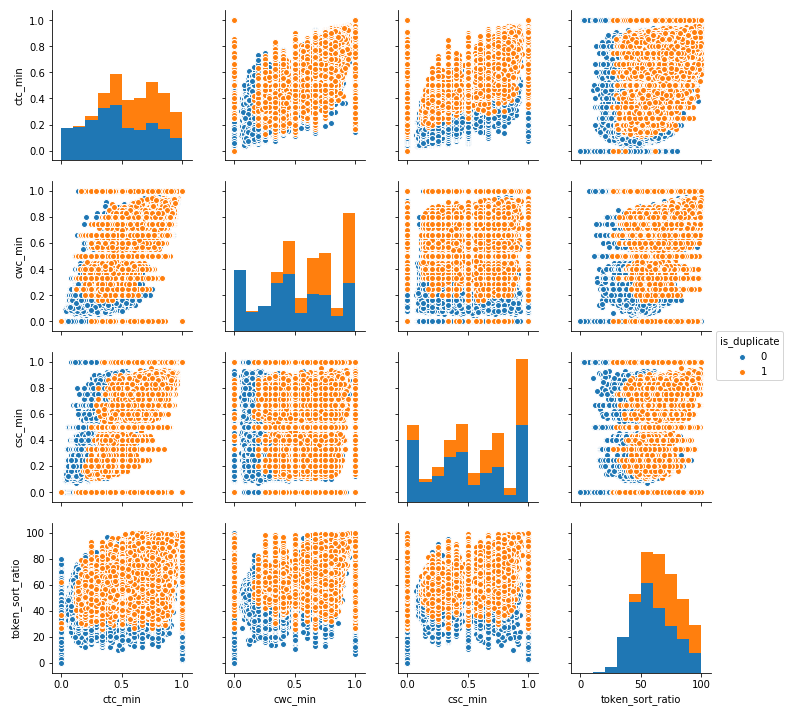

In [18]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

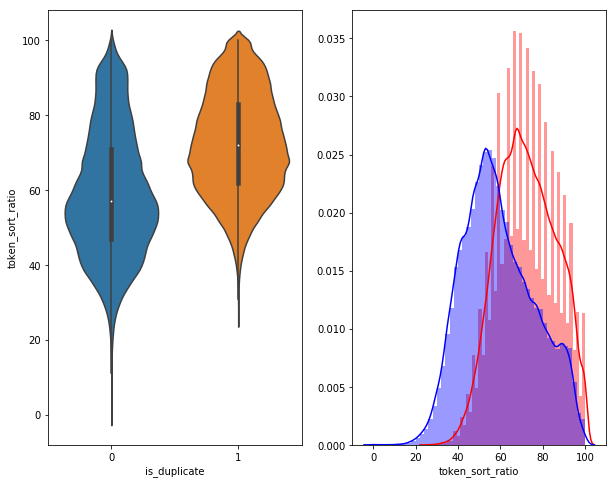

In [20]:
import warnings
warnings.filterwarnings('ignore')
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

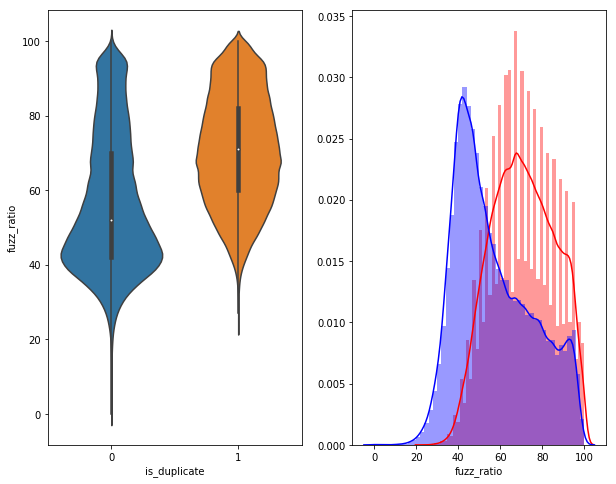

In [21]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [22]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [23]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.142s...
[t-SNE] Computed neighbors for 5000 samples in 0.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.459s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 4.304s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 3.057s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 2.965s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 3.141s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

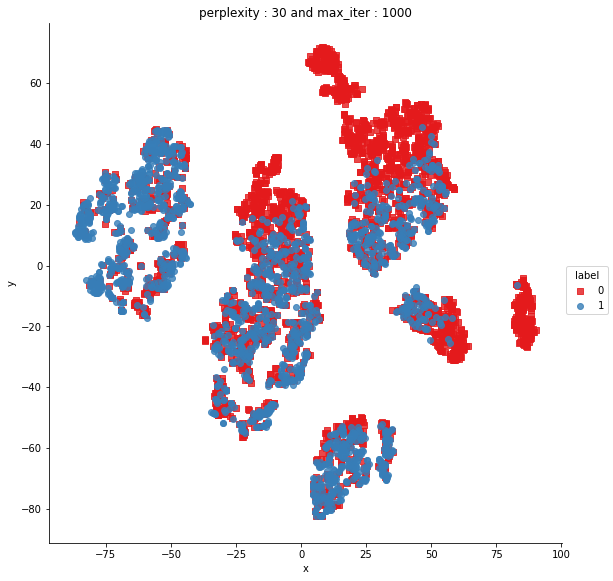

In [24]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [25]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.535s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.408s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 16.454s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 8.609s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 7.891s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 7.480s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.000927

In [26]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')